In [1]:
import logging
logger = logging.getLogger() 
logger.setLevel(logging.CRITICAL)

import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Trajectory import Trajectory
sys.path.insert(1,'../code/data_utils/')
from ConfigDataset import ConfigDataset
from HiCDataset import HiCDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
config_fp = '../data/processed_data.hdf5'
num_bins = 64
resolution = 20_000
mean_dist_fp = '../data/mean_dists.pt'
mean_sq_dist_fp='../data/squares.pt'

mcool_fp = '../data/outside/GM12878_hg19.mcool'
interp_nans = False
balance_hic = True
adaptive_coarsegraining = False
adaptive_coarsegraining_cutoff = 3
adaptive_coarsegraining_max_levels = 8

save_dir = './maps_vs_tan_hic/'

# Gen configs
config_directory = '../data/samples/origami_64_no_embed_reduction/eval_mode/'
aligned_config_directory = '../data/samples/origami_64_no_embed_reduction/eval_mode/aligned/'
cond_scale = 5.0
rescaled_phi = 8.0
milestone = 120
resolution = 20_000

# For loading dcd files
topology_file = aligned_config_directory+'topology.psf'

regions = { # chrom:region_idxs
  '1':[144,200,265,330,395,460,525,590,730,795,860,1260,1325], 
  'X':[100,236,381,445,553,610,675,810,900,965,1060,1125,1200]
}

Load the Dip-C coordinates

In [3]:
config_ds = ConfigDataset(
    config_fp,
    segment_length=num_bins,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=[chrom for chrom in regions],
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)
rosetta = pd.read_pickle(f'../data/embeddings_{num_bins}_after_transformer/rosetta_stone.pkl')

Load the cooler data

In [4]:
exp_hic = HiCDataset(mcool_fp,resolution=resolution)

Support functions

In [5]:
def get_genomic_index(chrom,region_idx,rosetta=rosetta):
    return rosetta[chrom][region_idx][-1]

In [6]:
def get_experimental_hic(
    chrom,
    region_idx,
    exp_hic=exp_hic,
    resolution=resolution,
    num_bins=num_bins,
    balance=balance_hic,
    adaptive_coarsegraining=adaptive_coarsegraining,
    adaptive_coarsegraining_cutoff=adaptive_coarsegraining_cutoff,
    adaptive_coarsegraining_max_levels=adaptive_coarsegraining_max_levels,
    interp_nans=interp_nans
):
    start = get_genomic_index(chrom,region_idx)
    stop = start + resolution * num_bins
    return exp_hic.fetch(
        chrom=chrom,
        start=start,
        stop=stop,
        balance=balance,
        adaptive_coarsegraining=adaptive_coarsegraining,
        adaptive_coarsegraining_cutoff=adaptive_coarsegraining_cutoff,
        adaptive_coarsegraining_max_levels=adaptive_coarsegraining_max_levels,
        interp_nans=interp_nans
    )

In [7]:
def get_gen_dists(filepath,chrom,region_idx,cond_scale,rescaled_phi,milestone):
    if filepath is None:
        filepath = config_directory + f'/sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{milestone}_{chrom}.pt'
    gen_configs = torch.load(filepath)
    gen_configs = gen_configs[gen_configs.isfinite().all(-1).all(-1)]
    if gen_configs.shape[-1] == 3:
        gen_configs = Coordinates(gen_configs).distances
    else:
        gen_configs = Distances(gen_configs)
    return gen_configs.float_().cpu_()

In [8]:
def get_tan_dists(chrom,region_idx,config_ds=config_ds):
    chrom = str(chrom)
    start_idx = get_genomic_index(chrom,region_idx) # Get starting position by bp position
    return Coordinates(config_ds.fetch_specific_coords(chrom=chrom,start_idx=start_idx)[1]).distances.float_().cpu_(), start_idx

#### Plotting function -- Just Hi-C & population-average distances

In [9]:
def gen_vs_tan(
    chrom=None,
    region_idx=None,
    config_directory=config_directory,
    *,
    gen_configs = None,
    tan_configs = None,
    filepath=None,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    resolution=20_000
):

    hic_map = get_experimental_hic(chrom,region_idx)
    
    if gen_configs is None:
        gen_configs = get_gen_dists(filepath,chrom,region_idx,cond_scale,rescaled_phi,milestone)
    gen_mean = gen_configs.mean
    #gen_std = gen_configs.std
    del gen_configs

    if tan_configs is None:
        tan_configs, genomic_index = get_tan_dists(chrom,region_idx)
    else:
        genomic_index = get_genomic_index(chrom,region_idx)
    tan_mean = tan_configs.mean
    #tan_std = tan_configs.std
    del tan_configs

    fig = plt.figure(figsize=(6.5,2.25))

    hic_ax = fig.add_subplot(121)
    _,_,hic_im,hic_cbar = hic_map.plot(fig=fig,ax=hic_ax,vmax=1)
    hic_ax.set_title('Experimental Hi-C')
    #hic_cbar.set_label('')#Experimental Contact\nProbabilities')
    #hic_cbar.set_label('Interaction Frequency')
    
    dist_ax = fig.add_subplot(122)
    _,_,dist_im,dist_cbar = tan_mean.plot_with(gen_mean,fig=fig,ax=dist_ax)
    dist_ax.set_title('Population Average')
    #dist_cbar.set_label('')

    '''
    std_ax = fig.add_subplot(133)
    _,_,std_im,std_cbar = tan_std.plot_with(gen_std,fig=fig,ax=std_ax)
    '''

    n = tan_mean.num_beads
    fig.suptitle(
        #'Distance Statistics Comparison:\n'+\
        f'Chromosome {chrom}: {genomic_index:,}-{genomic_index+resolution*n:,}',
        verticalalignment='bottom'
    )

    for ax in [dist_ax]:#,std_ax]:
        
        ax.text(.995*n-1,.005*n,'Dip-C',horizontalalignment='right',verticalalignment='top',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
        
        ax.text(.005*n,.995*n-1,'Generated',horizontalalignment='left',verticalalignment='baseline',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

    return fig, dist_ax, dist_im, dist_cbar, hic_ax, hic_im, hic_cbar
    

Make all of the plots

In [10]:
if save_dir == '':
    save_dir = './'
if save_dir[-1] != '/':
    save_dir+= '/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for chrom in regions:
    for region_idx in regions[chrom]:
        try:
            fig,*_ = gen_vs_tan(
                chrom,
                region_idx,
                cond_scale=cond_scale,
                rescaled_phi=rescaled_phi
            )
            #fig.savefig(save_dir + f'chrom_{chrom}_region_{region_idx}_nbins_{num_bins}_scale_{cond_scale}_phi_{rescaled_phi}.pdf',bbox_inches='tight');
        except:
            pass
        break

#### Also show distance map from aligned structures

In [11]:
def get_gen_coords(chrom=None,region_idx=None,cond_scale=cond_scale,rescaled_phi=rescaled_phi,milestone=milestone,filepath=None):
    if filepath is None:
        filepath = config_directory + f'/sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{milestone}_{chrom}.pt'
    gen_configs = torch.load(filepath)
    gen_configs = gen_configs[gen_configs.isfinite().all(-1).all(-1)]
    assert gen_configs.shape[-1] == 3, 'Not coordinates'
    gen_configs = Coordinates(gen_configs)
    return gen_configs


In [12]:
def get_genomic_index(chrom,region_idx,rosetta=rosetta):
    return rosetta[chrom][region_idx][-1]
    
def get_tan_coords(chrom,region_idx,config_ds=config_ds):
    chrom = str(chrom)
    start_idx = get_genomic_index(chrom,region_idx) # Get starting position by bp position
    return Coordinates(config_ds.fetch_specific_coords(chrom=chrom,start_idx=start_idx)[1]).float_(), start_idx

In [13]:
def get_best_match(tan_configs,gen_configs):

    rmsd_index,aligned_configs = gen_configs.trajectory.get_best_superpositions(tan_configs.trajectory)
    rmsd = rmsd_index['RMSD']
    #index = rmsd_index['Index'] # Index in context of larger gen_configs object, which isn't strictly necessary anymore

    idx = torch.where(rmsd==rmsd.min())[0]
    tan_config = tan_configs[idx].trajectory
    aligned_config = aligned_configs[idx].trajectory

    tan_config.mdtraj.center_coordinates()
    aligned_config.superpose(tan_config)

    return aligned_config, tan_config
    

In [14]:
def get_filename(
    chrom,
    region_idx,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone
):
    return f'sample_{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}.pt'

In [15]:
def load_get_save_best_match(
    chrom,
    region_idx,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    num_bins=num_bins,
    config_directory=config_directory,
    aligned_config_directory=aligned_config_directory,
):
    f = get_filename(chrom,region_idx,cond_scale,rescaled_phi,milestone)
    f = f.replace('.pt','.dcd')
    tan_f = f.replace('.dcd','_tan.dcd')
    acd = aligned_config_directory
    if os.path.exists(acd+f) and os.path.exists(acd+tan_f):
        gen_config = Trajectory(acd+f,num_beads=num_bins)
        tan_config = Trajectory(acd+tan_f,num_beads=num_bins)
        genomic_index = get_genomic_index(chrom,region_idx)
        return gen_config, tan_config, genomic_index

    elif not os.path.exists(acd):
        os.makedirs(acd)

    # The files didn't exist; must load all coordinates and align them
    gen_configs = get_gen_coords(filepath=config_directory+f.replace('.dcd','.pt'))
    tan_configs, genomic_index = get_tan_coords(chrom,region_idx)

    gen_config,tan_config = get_best_match(tan_configs,gen_configs)
    
    gen_config.trajectory.save_dcd(acd+f)
    tan_config.trajectory.save_dcd(acd+tan_f)

    return gen_config, tan_config, genomic_index

In [16]:
def plot_best_match(
    chrom,
    region_idx,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    num_bins=num_bins,
    resolution=resolution,
    fig=None,
    ax=None
):
    gen_config,tan_config,start = load_get_save_best_match(chrom,region_idx,cond_scale,rescaled_phi,milestone)

    if fig is None or ax is None:
        fig = plt.figure(figsize=(3.25,2.1))
        ax = fig.add_subplot(111)
    
    _,_,im,cbar = tan_config.distances.plot_with(gen_config.distances,fig=fig,ax=ax)

    ''' # Performed in gen_vs_tan_2()
    n = gen_config.num_beads
    ax.text(.995*n-1,.005*n,'Dip-C',horizontalalignment='right',verticalalignment='top',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
    
    ax.text(.005*n,.995*n-1,'Generated',horizontalalignment='left',verticalalignment='baseline',
            color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
    '''
    
    '''
    stop = start + num_bins*resolution
    start//= 1e6
    stop//= 1e6
    ax.set_title(f'Chromosome {chrom}:'+'\n'+f'{start}-{stop} Mb')
    '''
    ax.set_title('Aligned Conformation')

    return fig, ax, im, cbar
    
    

#### Updated plotting function -- Hi-C, population-averaged distances, and aligned single-cell distances

In [17]:
def gen_vs_tan_2(
    chrom=None,
    region_idx=None,
    *,
    gen_configs = None,
    tan_configs = None,
    filepath=None,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    resolution=20_000,
    config_directory=config_directory,
):

    hic_map = get_experimental_hic(chrom,region_idx)
    
    if gen_configs is None:
        gen_configs = get_gen_dists(filepath,chrom,region_idx,cond_scale,rescaled_phi,milestone)
    gen_mean = gen_configs.mean
    #gen_std = gen_configs.std
    del gen_configs

    if tan_configs is None:
        tan_configs, genomic_index = get_tan_dists(chrom,region_idx)
    else:
        genomic_index = get_genomic_index(chrom,region_idx)
    tan_mean = tan_configs.mean
    #tan_std = tan_configs.std
    del tan_configs

    fig = plt.figure(figsize=(6.75,5.4))

    hic_ax = fig.add_subplot(221)
    _,_,hic_im,hic_cbar = hic_map.plot(fig=fig,ax=hic_ax,vmax=1)
    hic_ax.set_title('Experimental Hi-C')
    #hic_cbar.set_label('')#Experimental Contact\nProbabilities')
    #hic_cbar.set_label('Interaction Frequency')
    
    dist_ax = fig.add_subplot(222)
    _,_,dist_im,dist_cbar = tan_mean.plot_with(gen_mean,fig=fig,ax=dist_ax)
    dist_ax.set_title('Population Average')
    #dist_cbar.set_label('')

    fit_ax = fig.add_subplot(223)
    _,_,fit_im,fit_cbar = plot_best_match(chrom,region_idx,cond_scale,rescaled_phi,milestone,fig=fig,ax=fit_ax)

    '''
    std_ax = fig.add_subplot(133)
    _,_,std_im,std_cbar = tan_std.plot_with(gen_std,fig=fig,ax=std_ax)
    '''

    n = tan_mean.num_beads
    fig.suptitle(
        #'Distance Statistics Comparison:\n'+\
        '\n'+f'Chromosome {chrom}: {genomic_index:,}-{genomic_index+resolution*n:,}',
        verticalalignment='center'
        #verticalalignment='bottom'
    )

    for ax in [dist_ax,fit_ax]:
        
        ax.text(.995*n-1,.005*n,'Dip-C',horizontalalignment='right',verticalalignment='top',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
        
        ax.text(.005*n,.995*n-1,'Generated',horizontalalignment='left',verticalalignment='baseline',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

    return fig, dist_ax, dist_im, dist_cbar, hic_ax, hic_im, hic_cbar
    

#### Create the plots

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 48 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'M', 'P', 'a', 'c', 'colon', 'comma', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'q', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 36, 38, 39, 40, 41, 42, 43, 44, 48, 51, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 1894]
INFO:fontTools.su

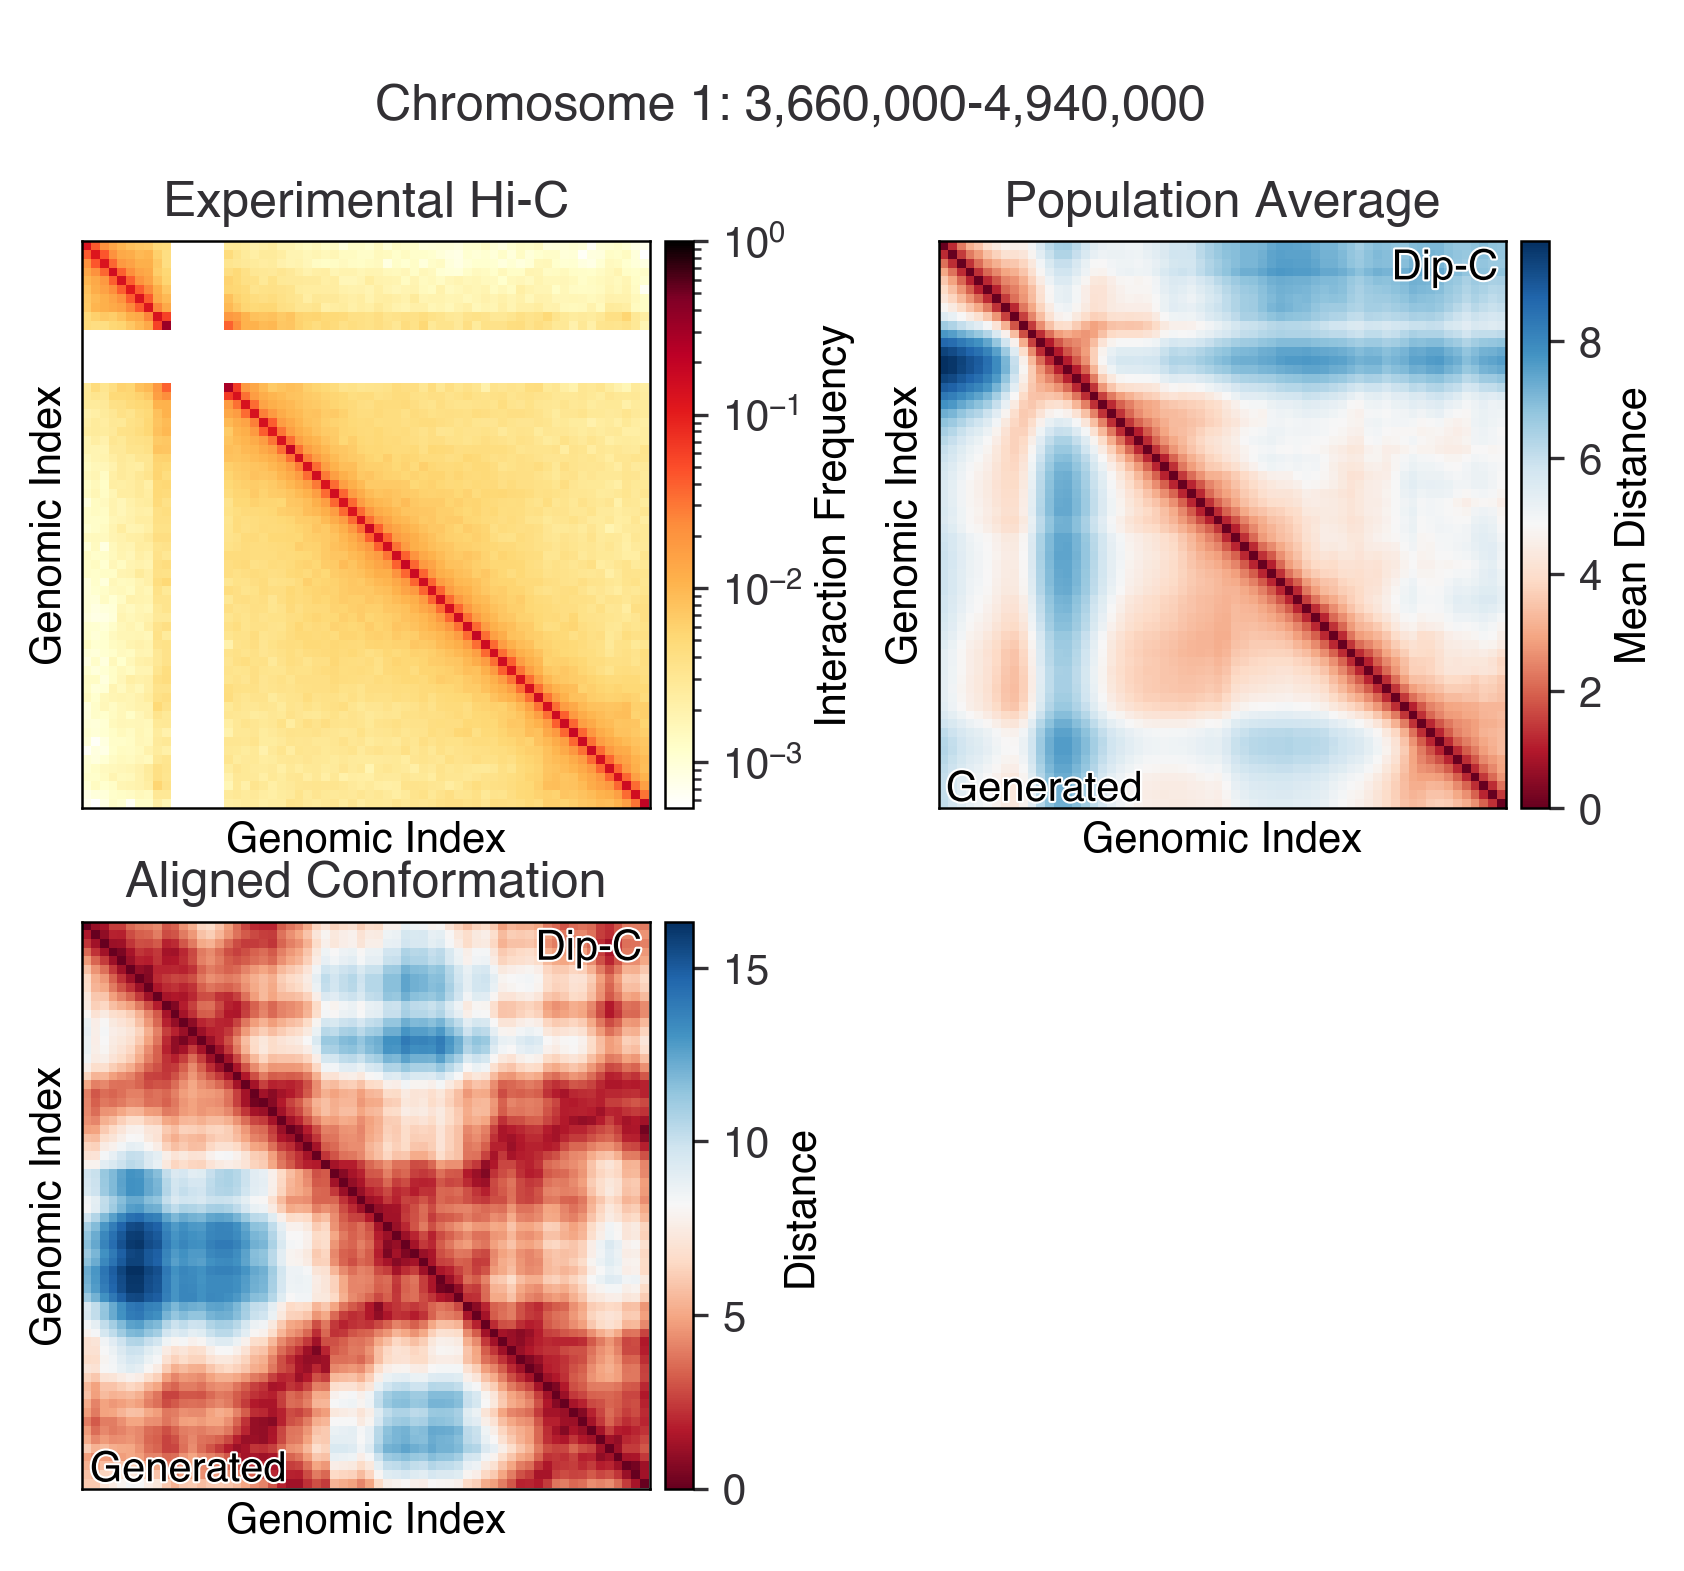

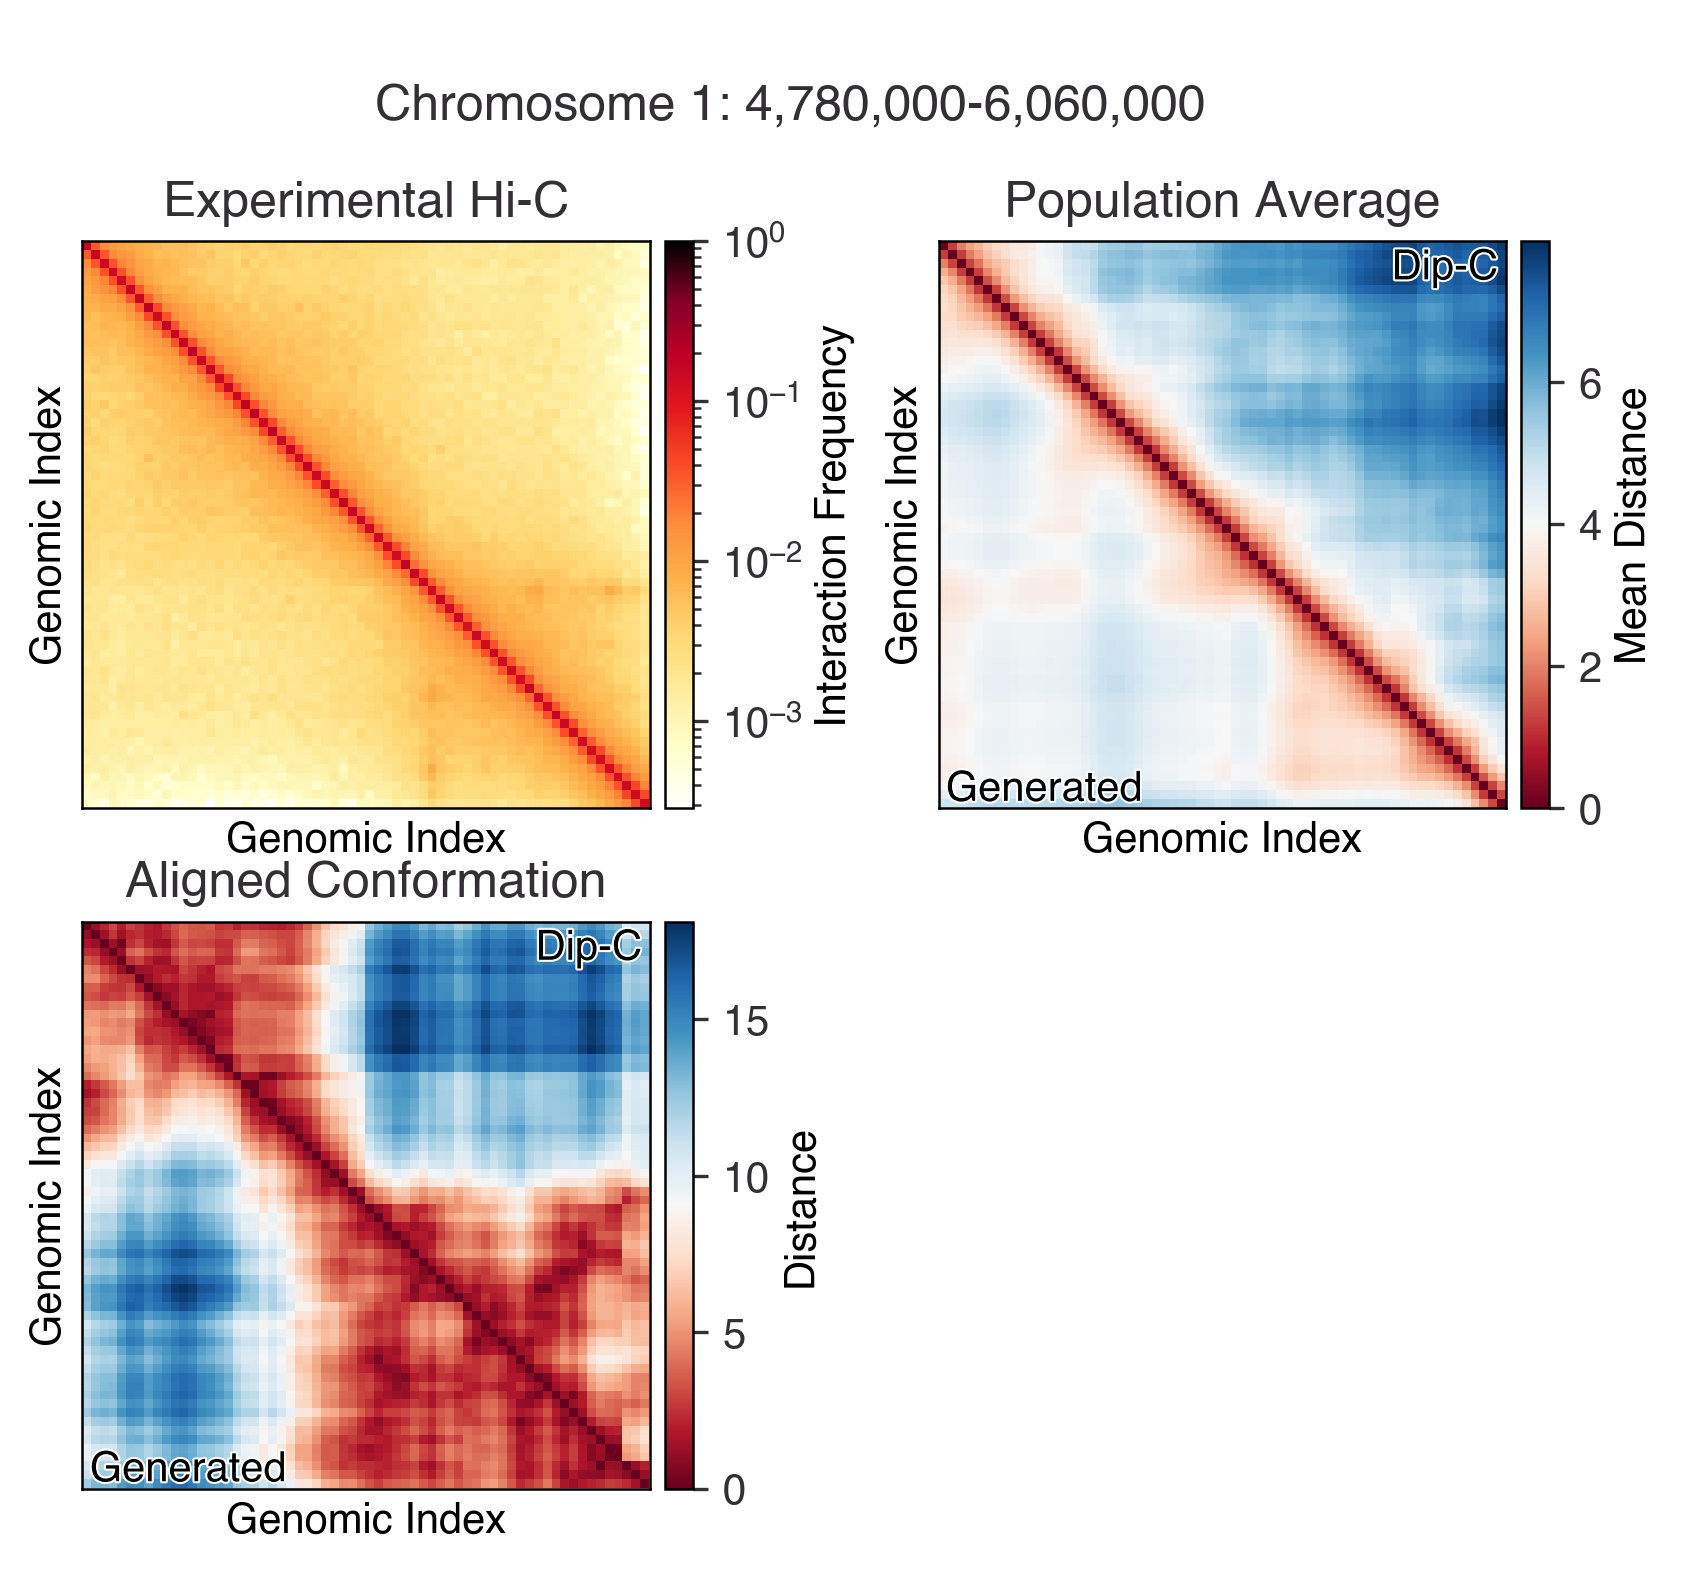

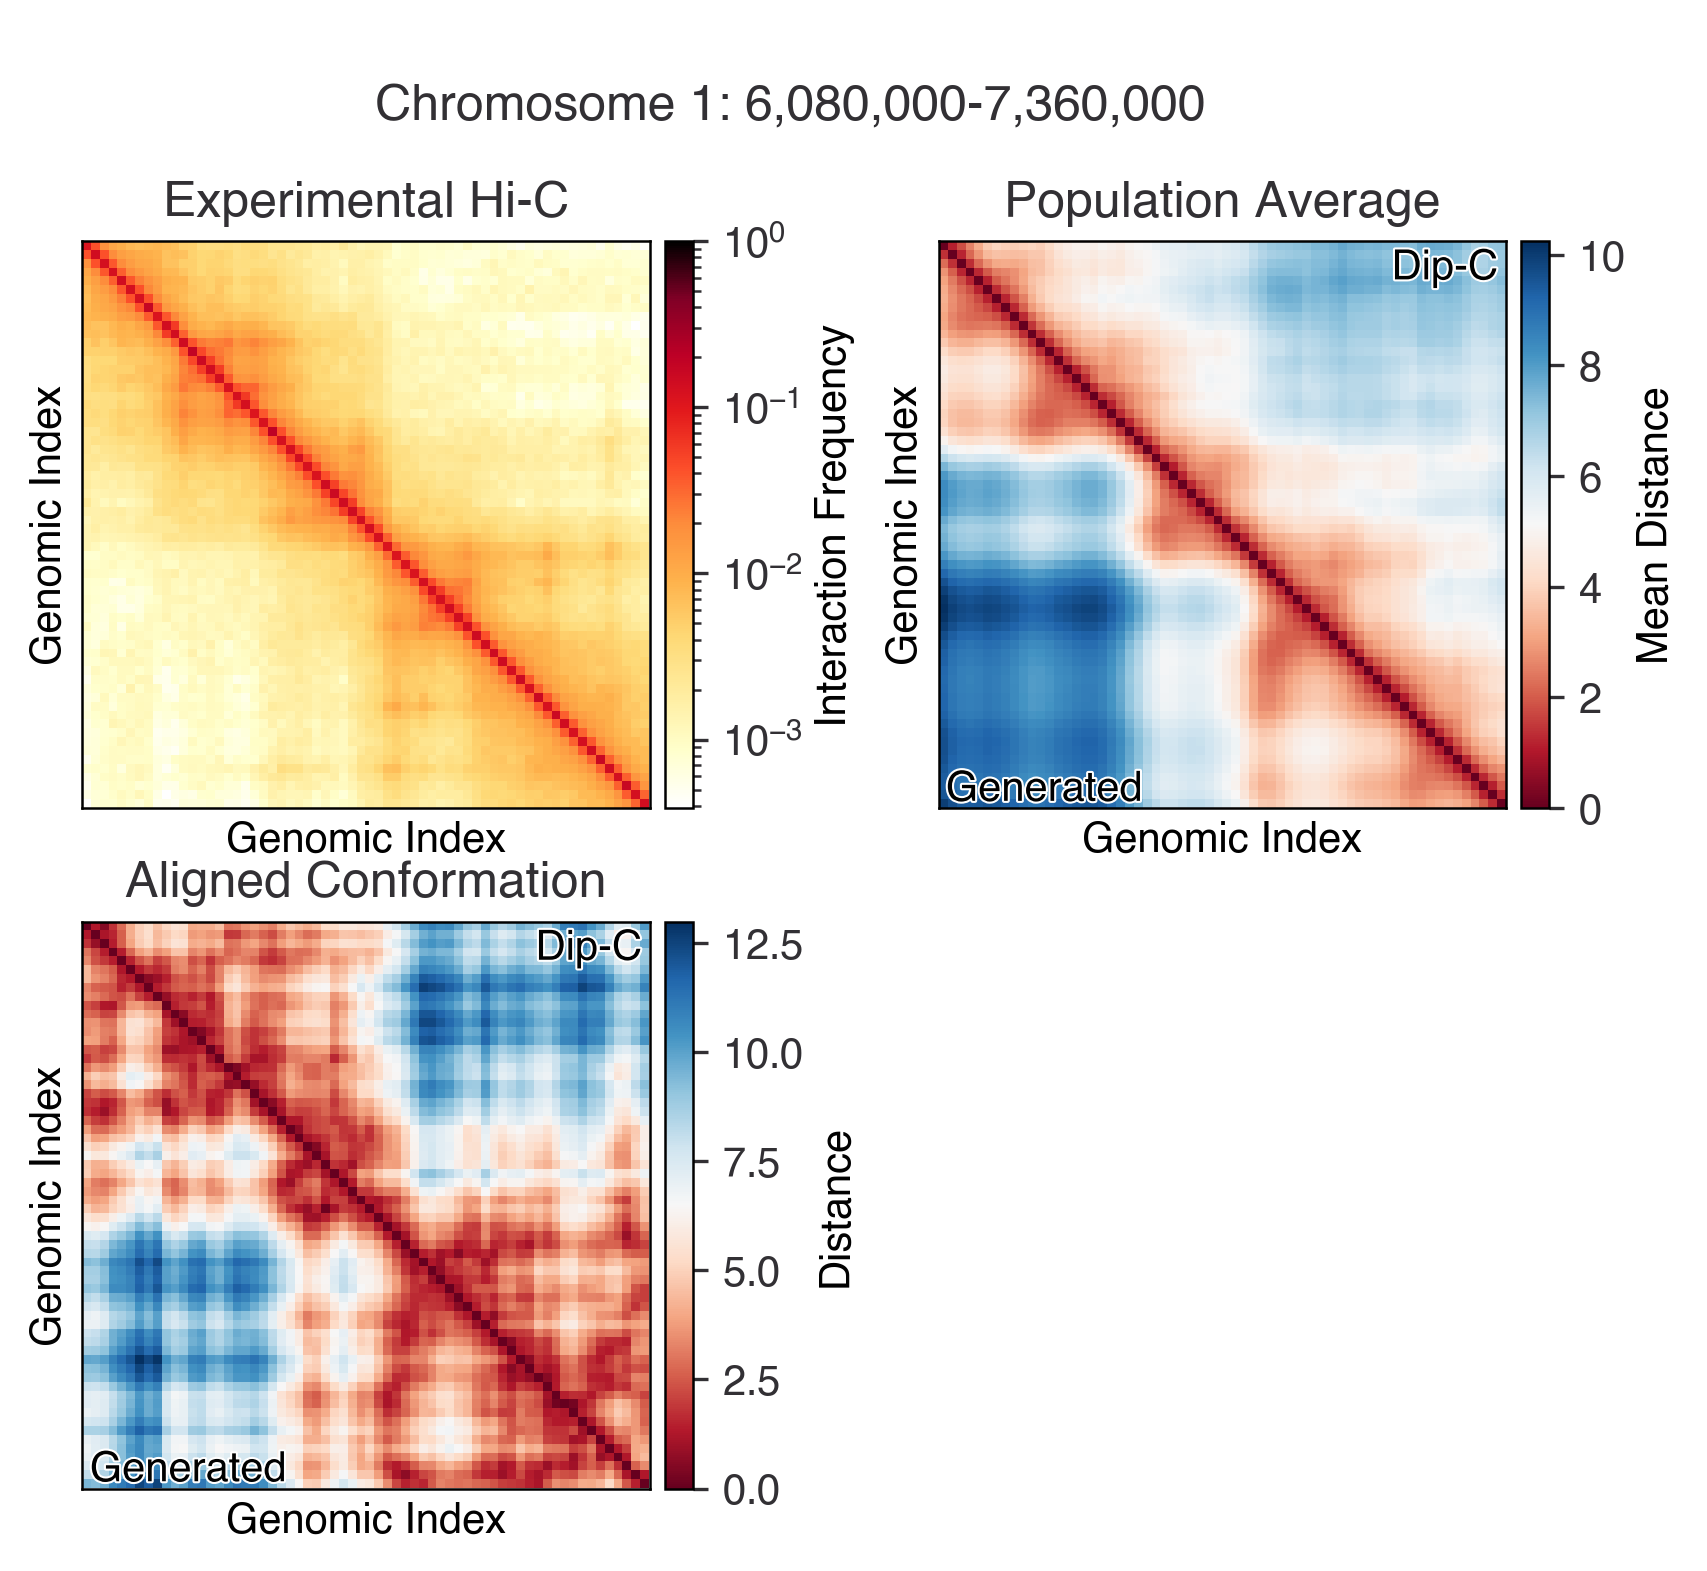

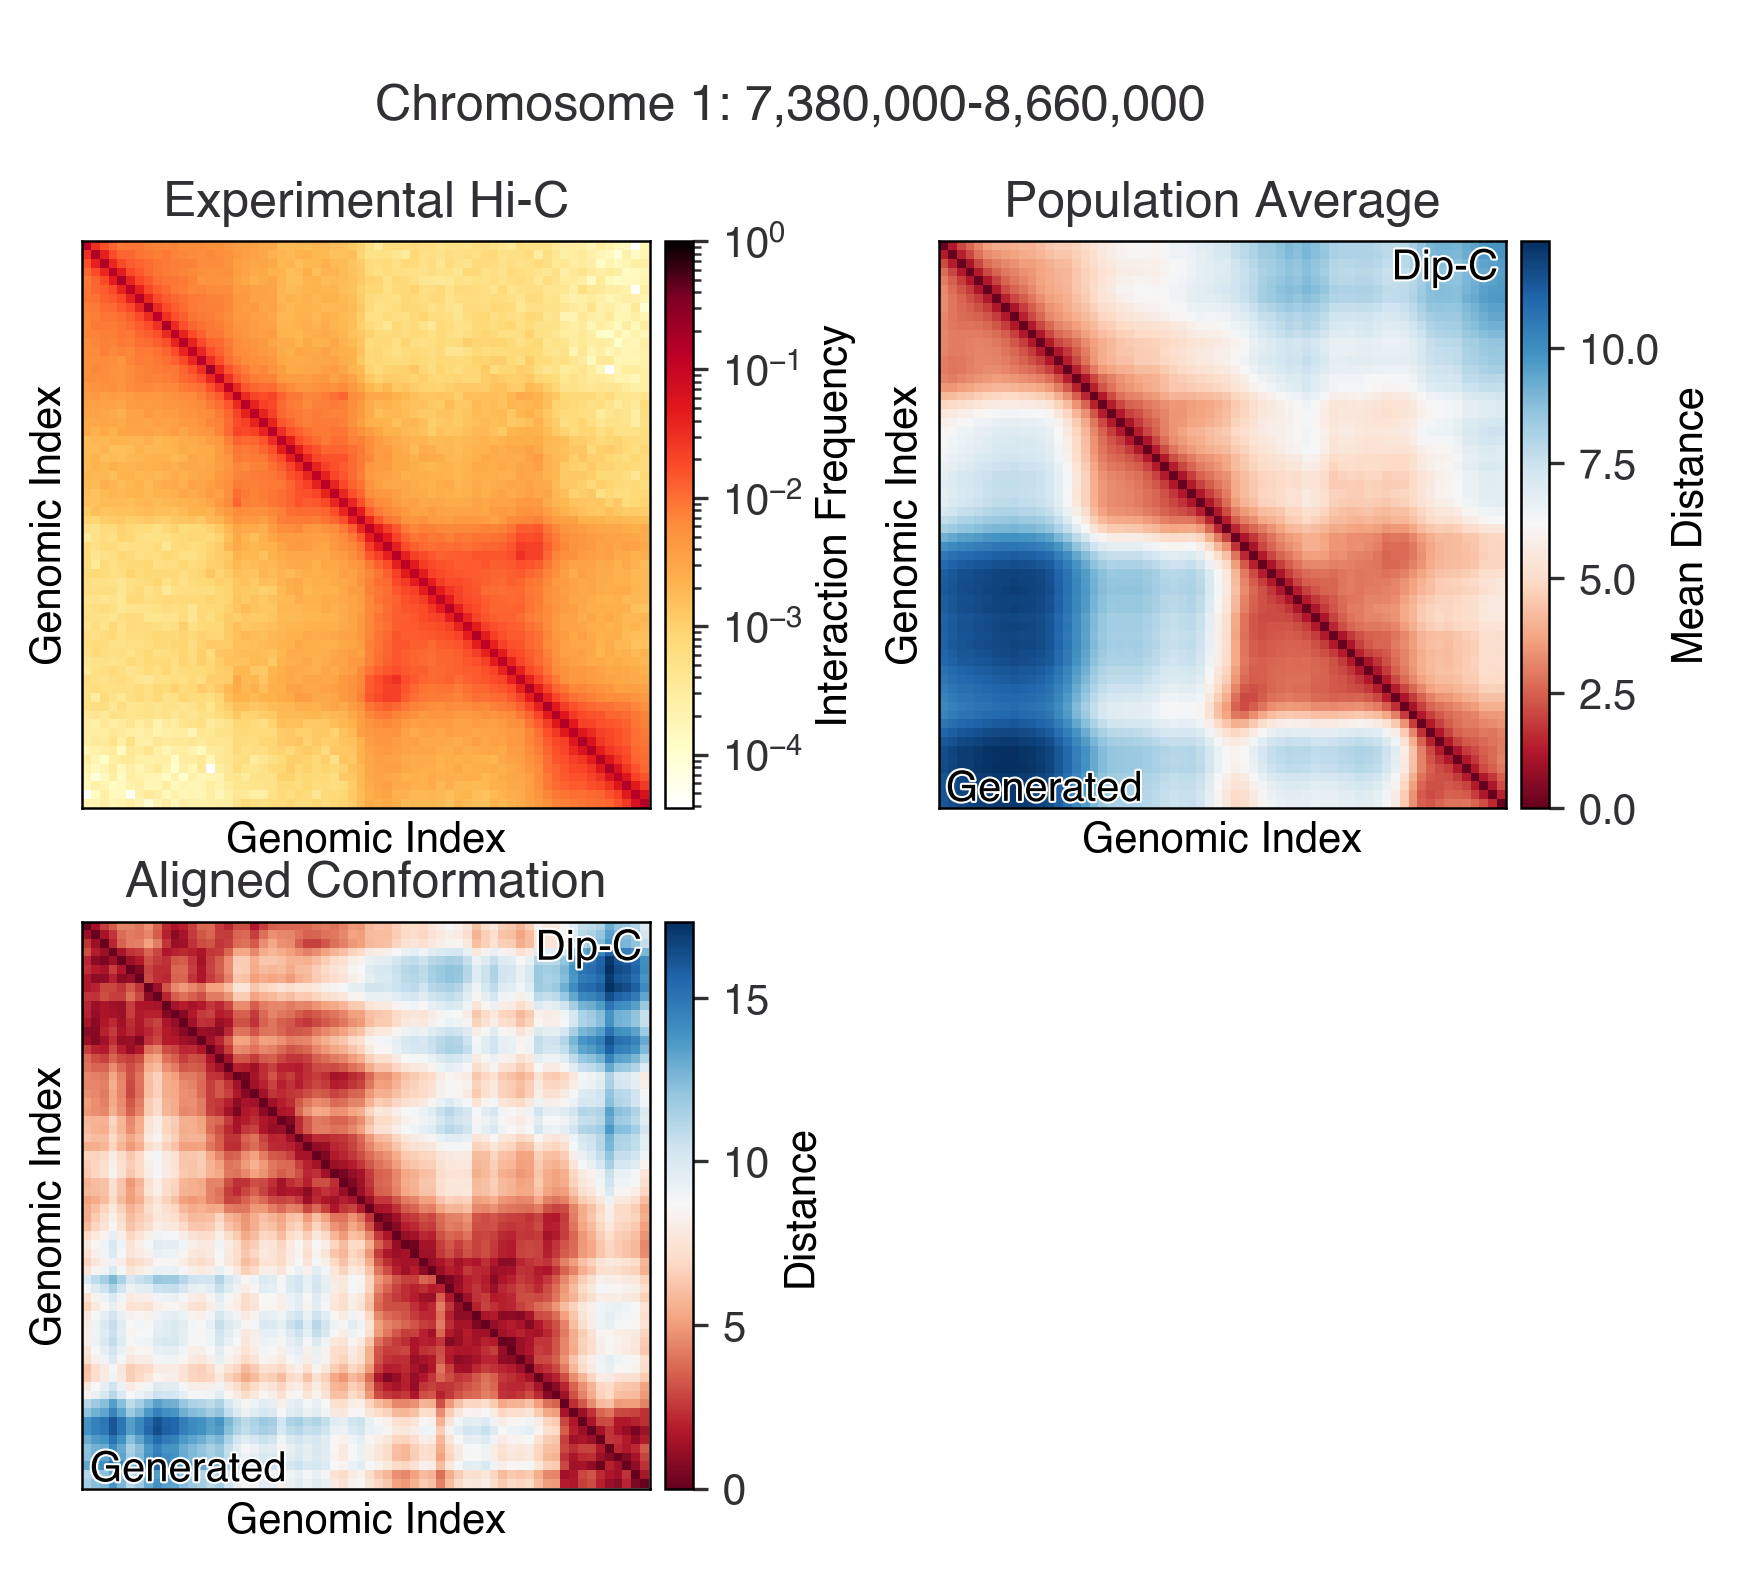

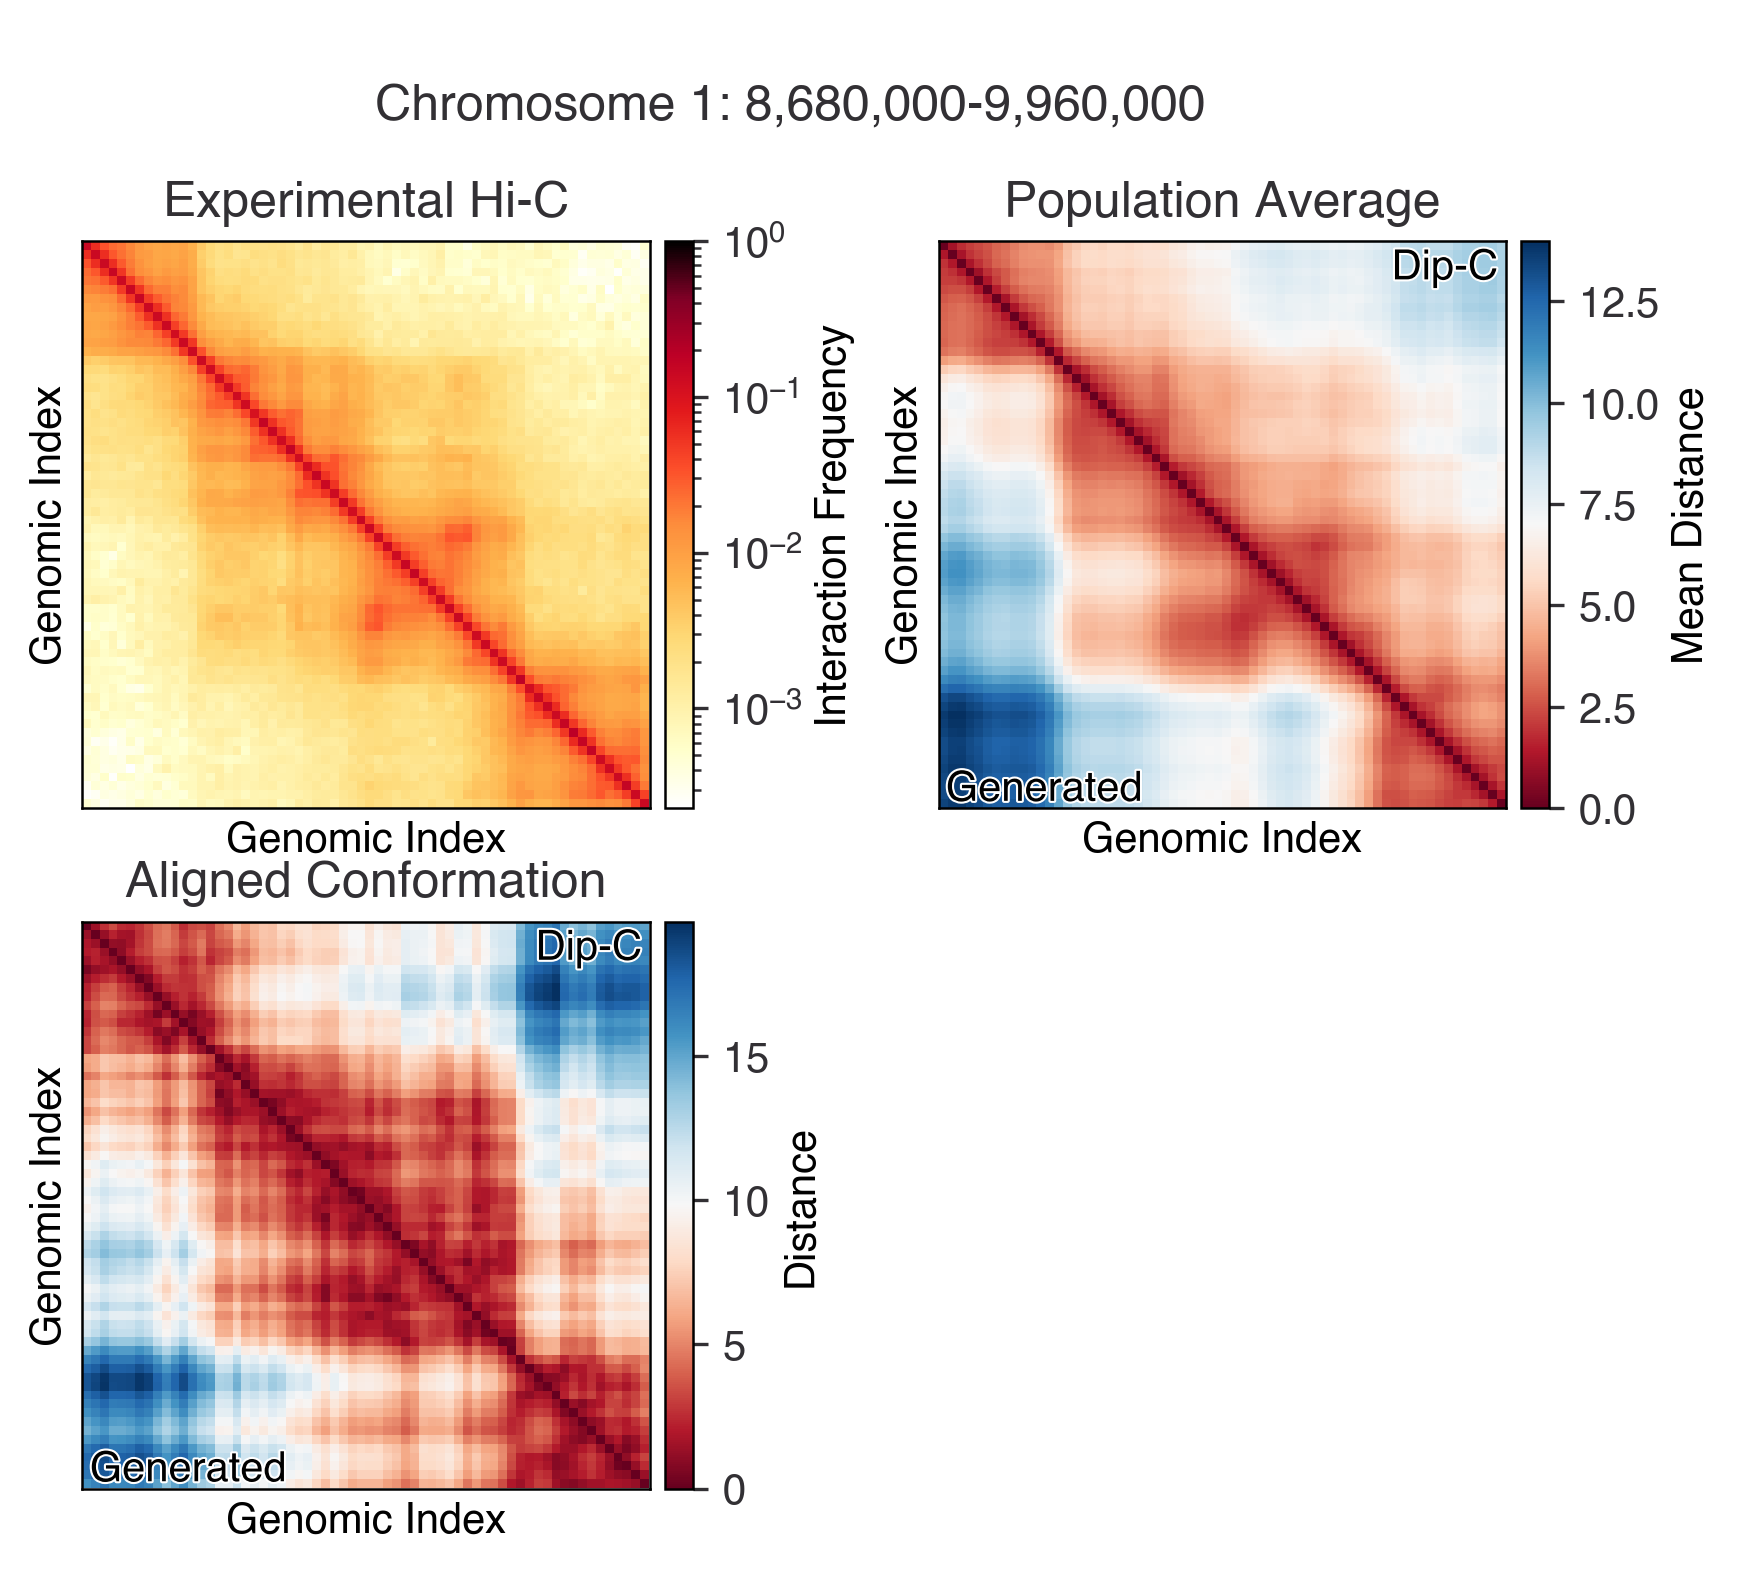

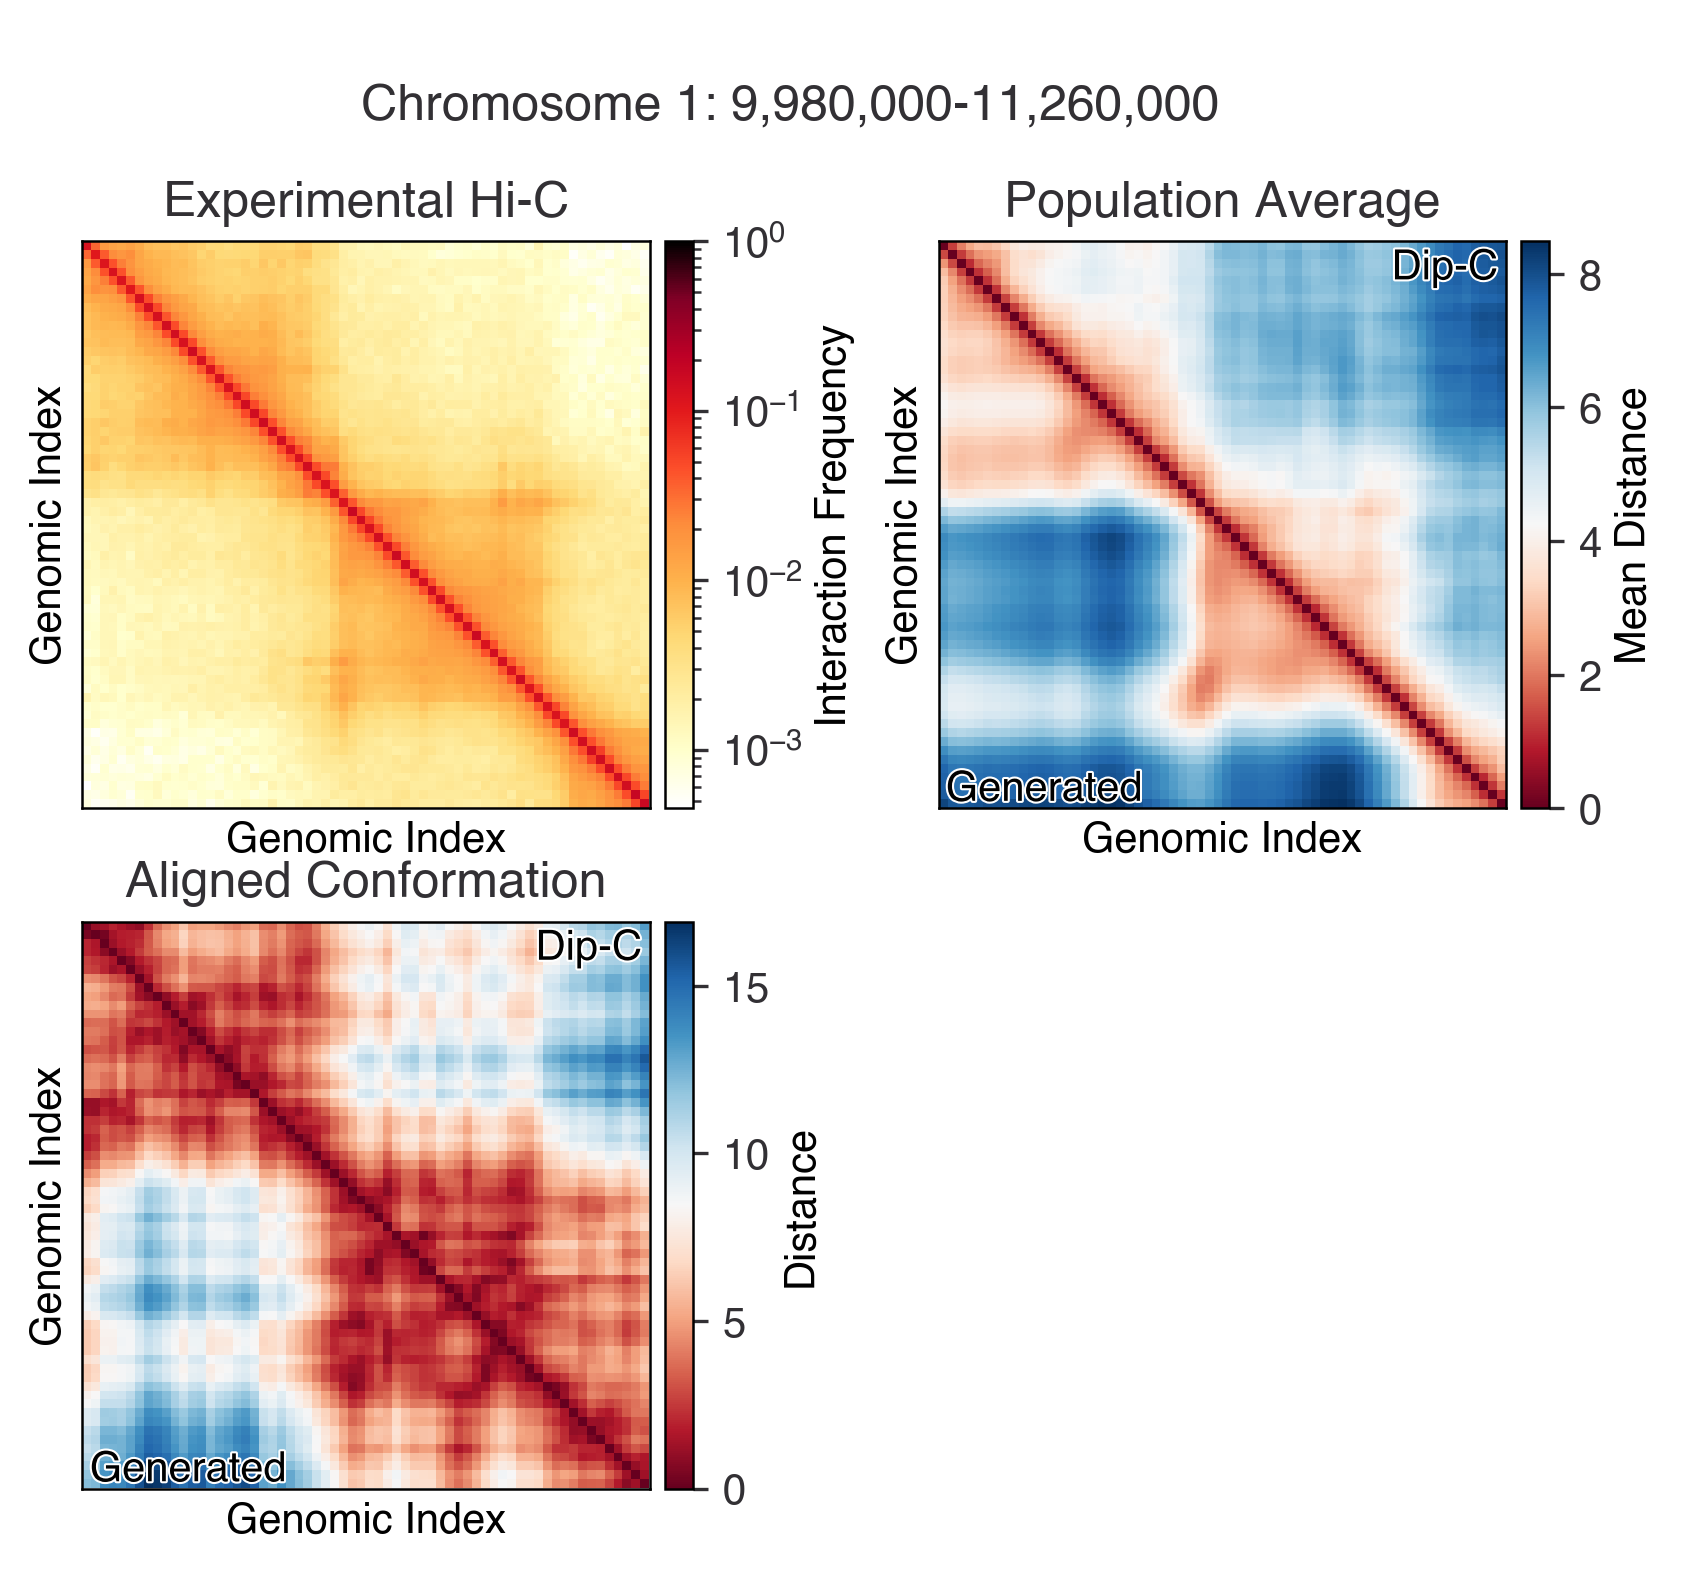

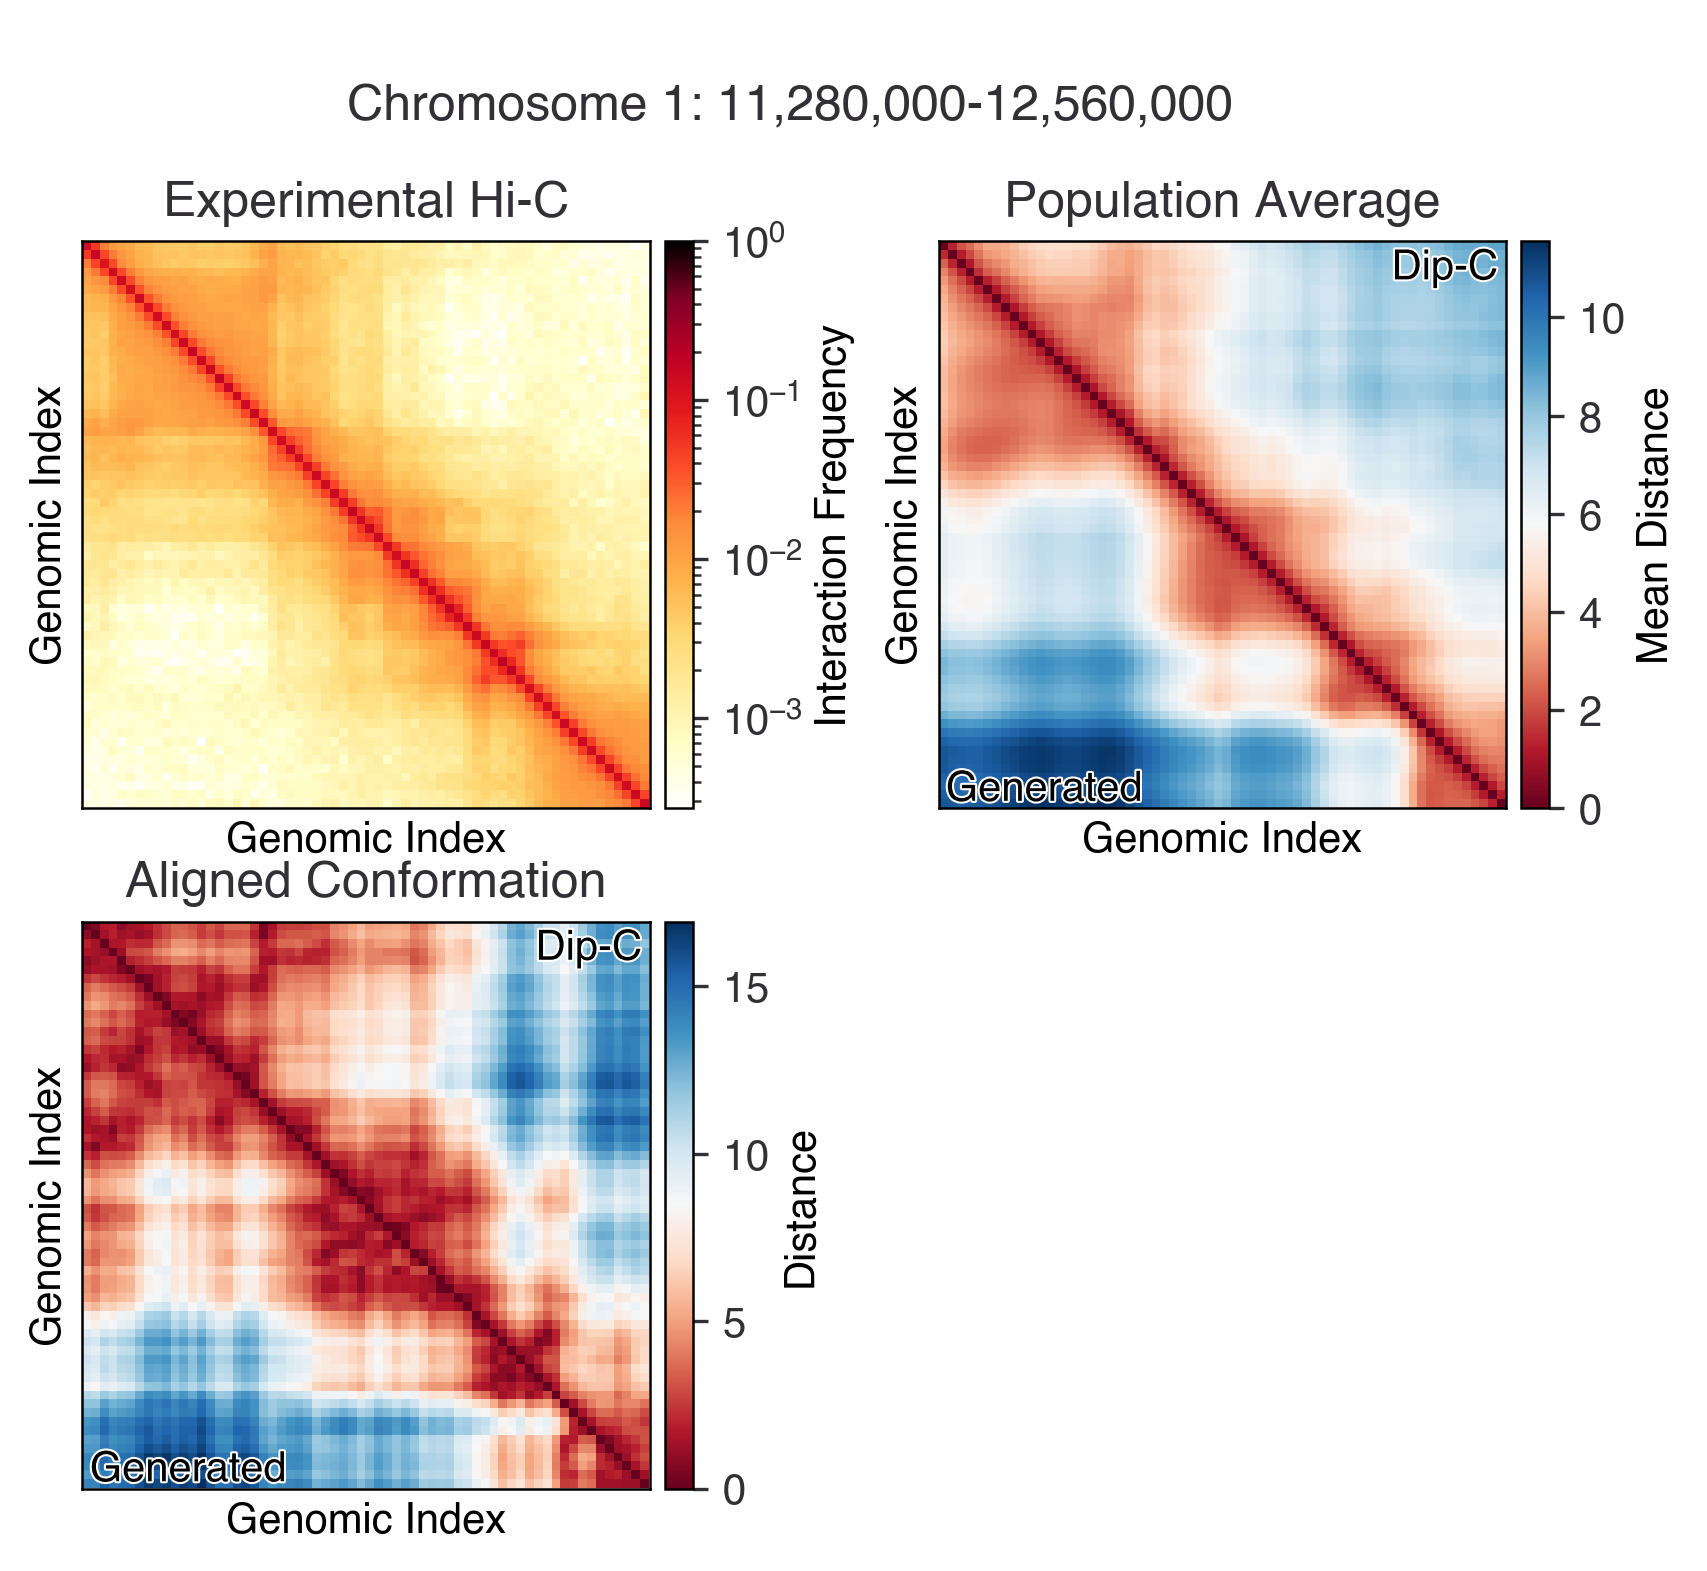

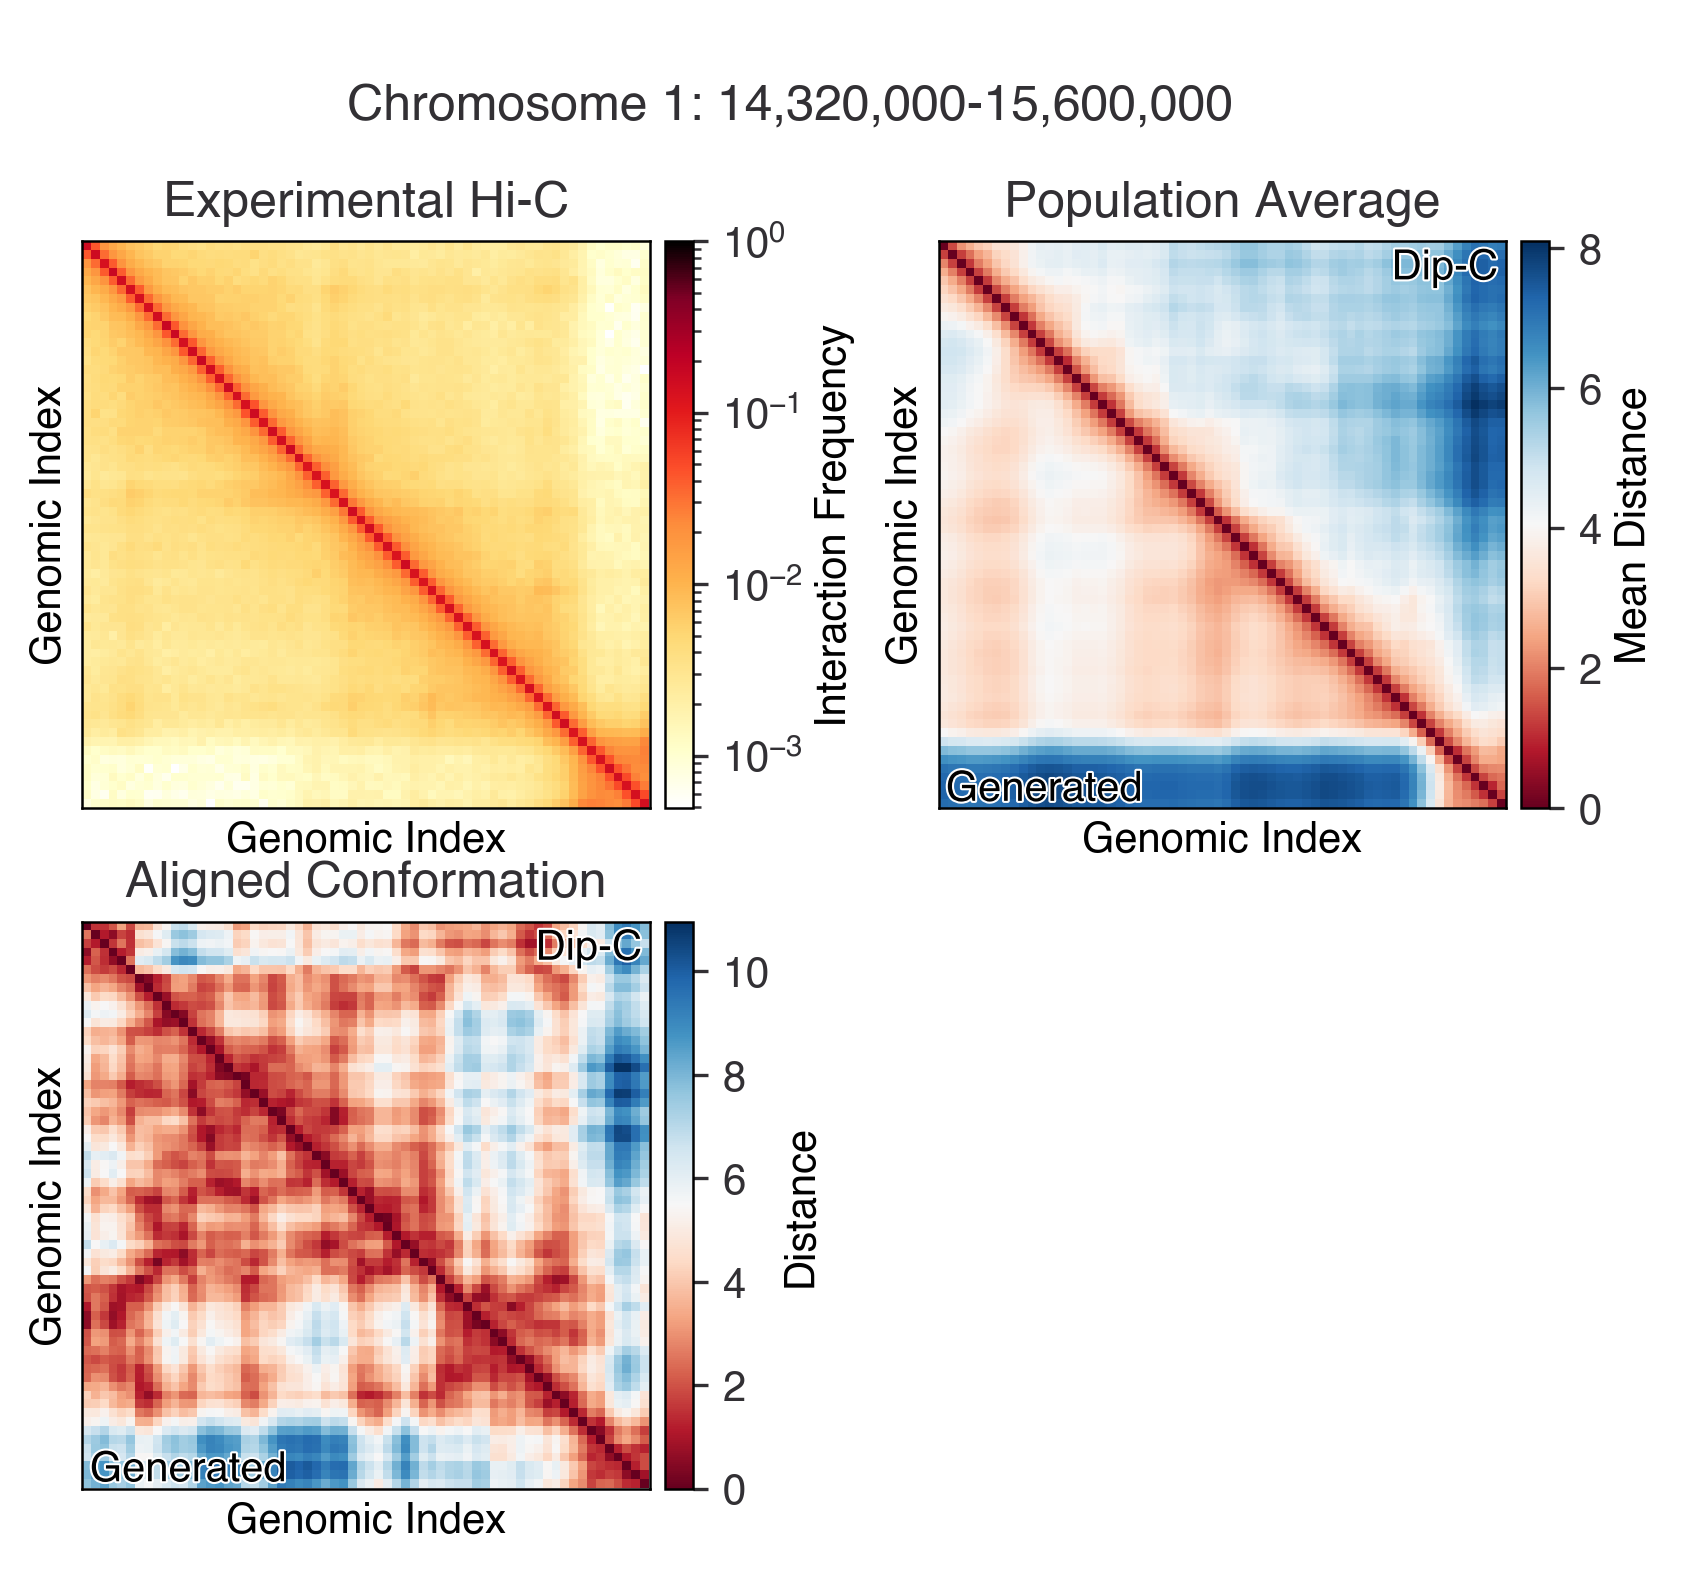

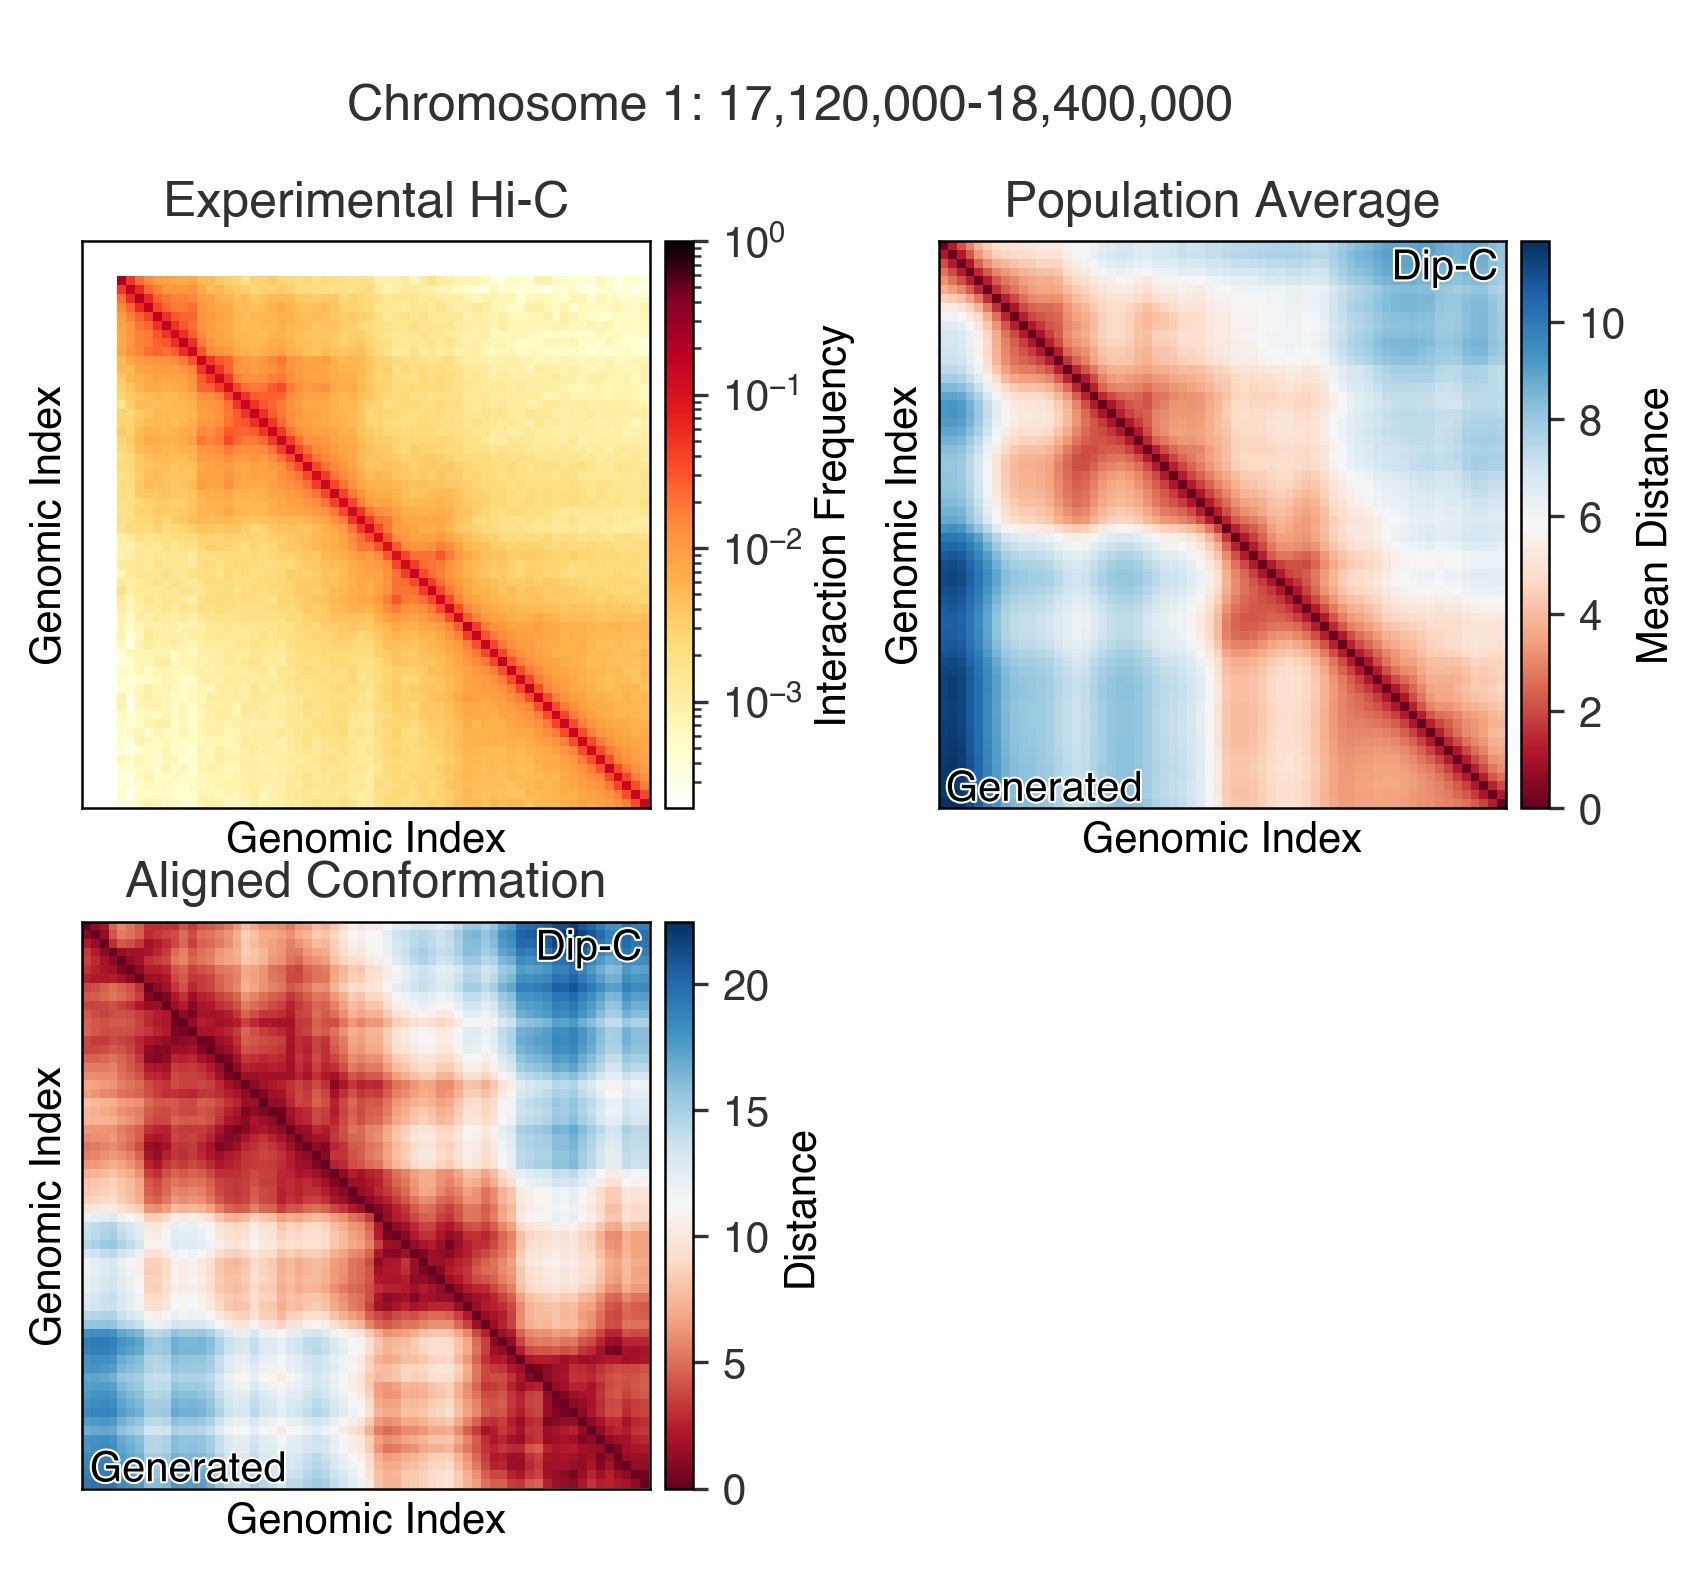

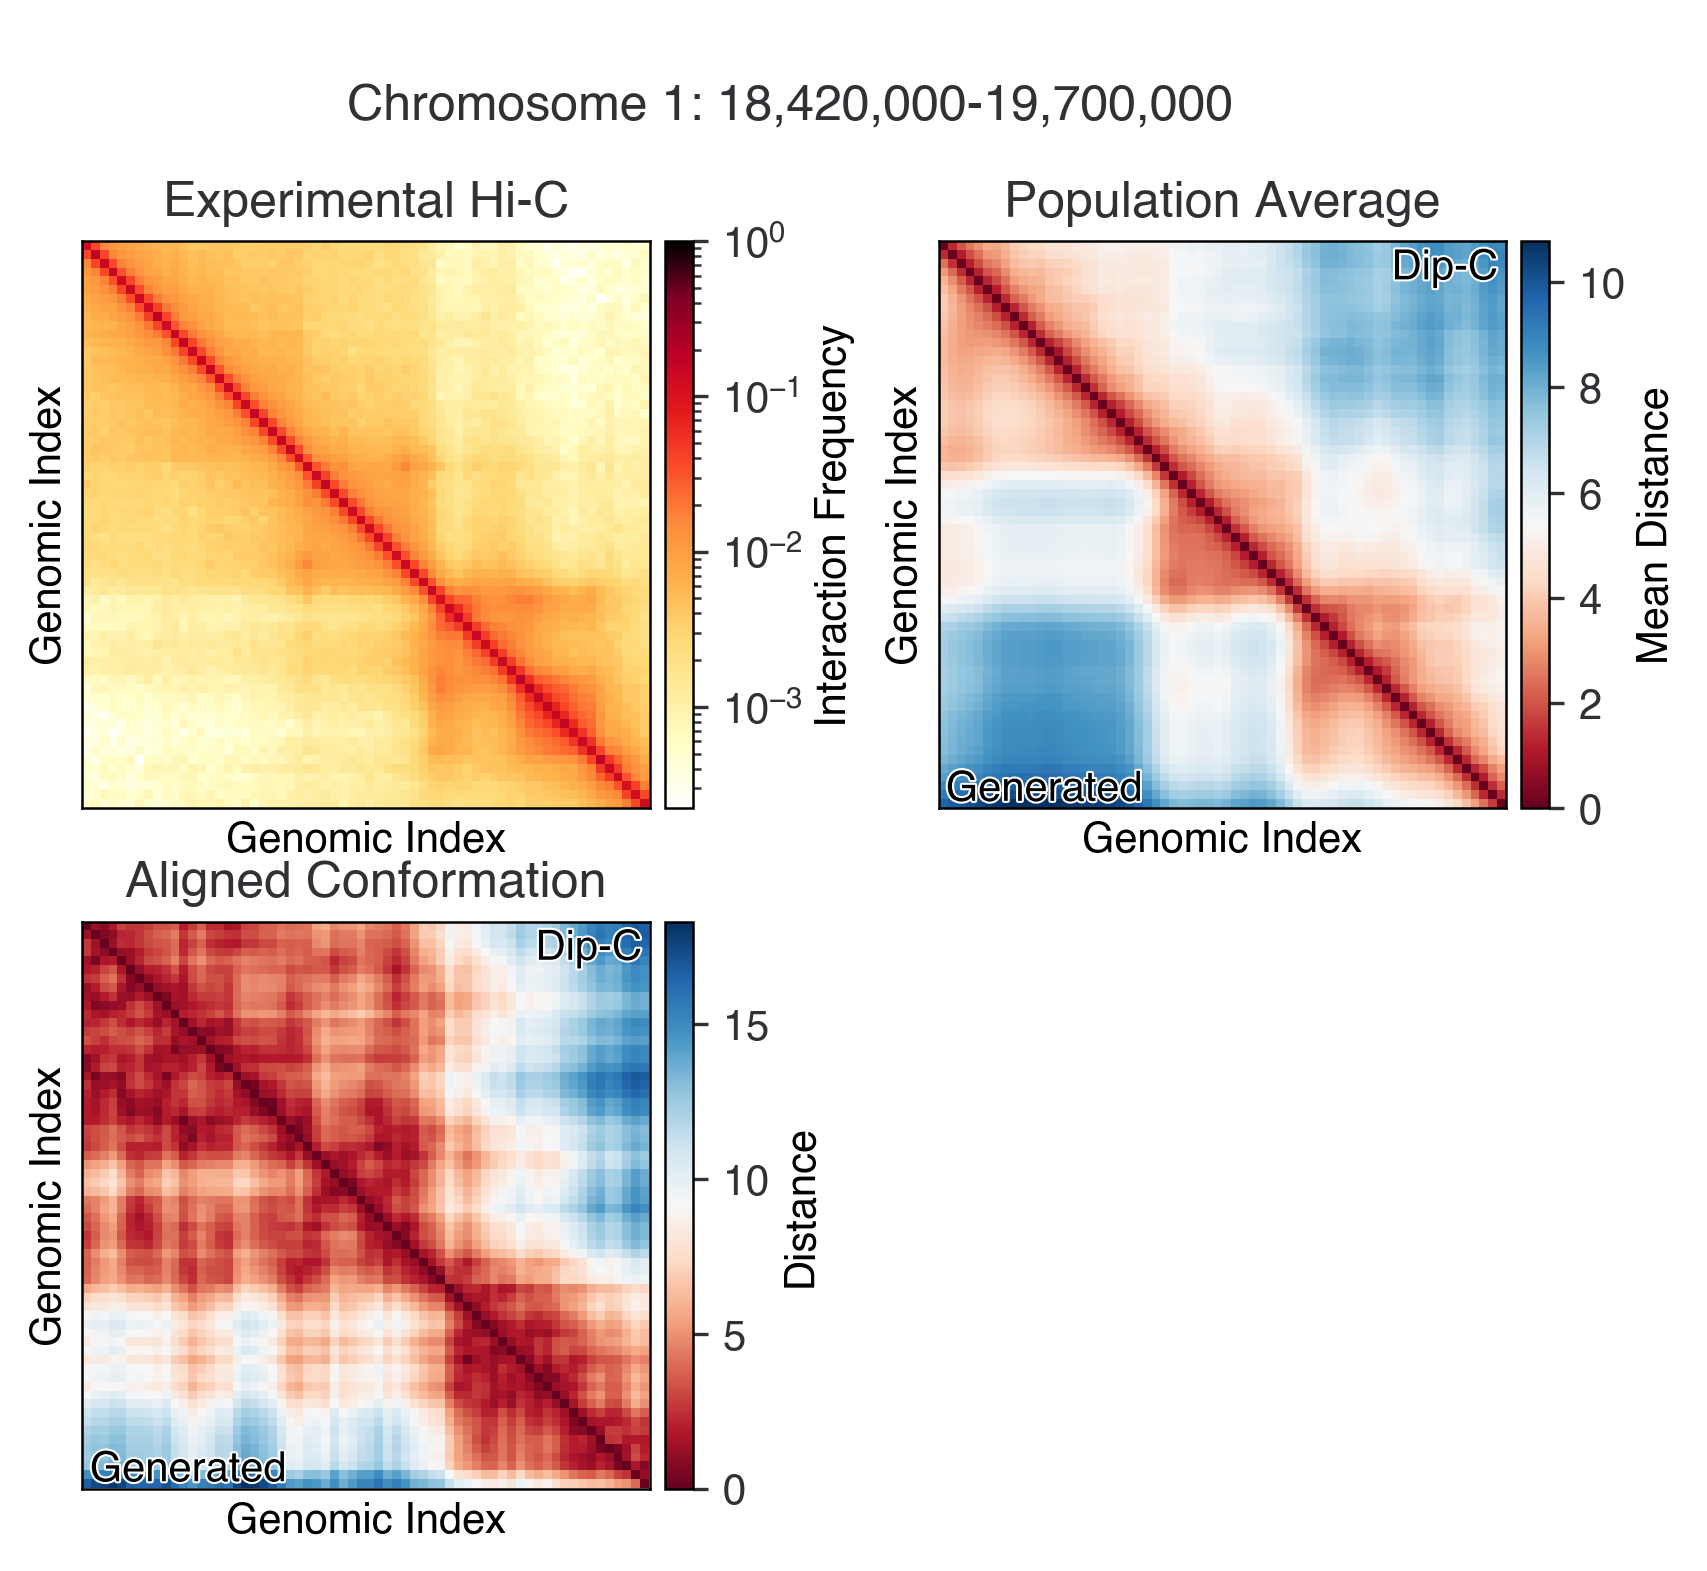

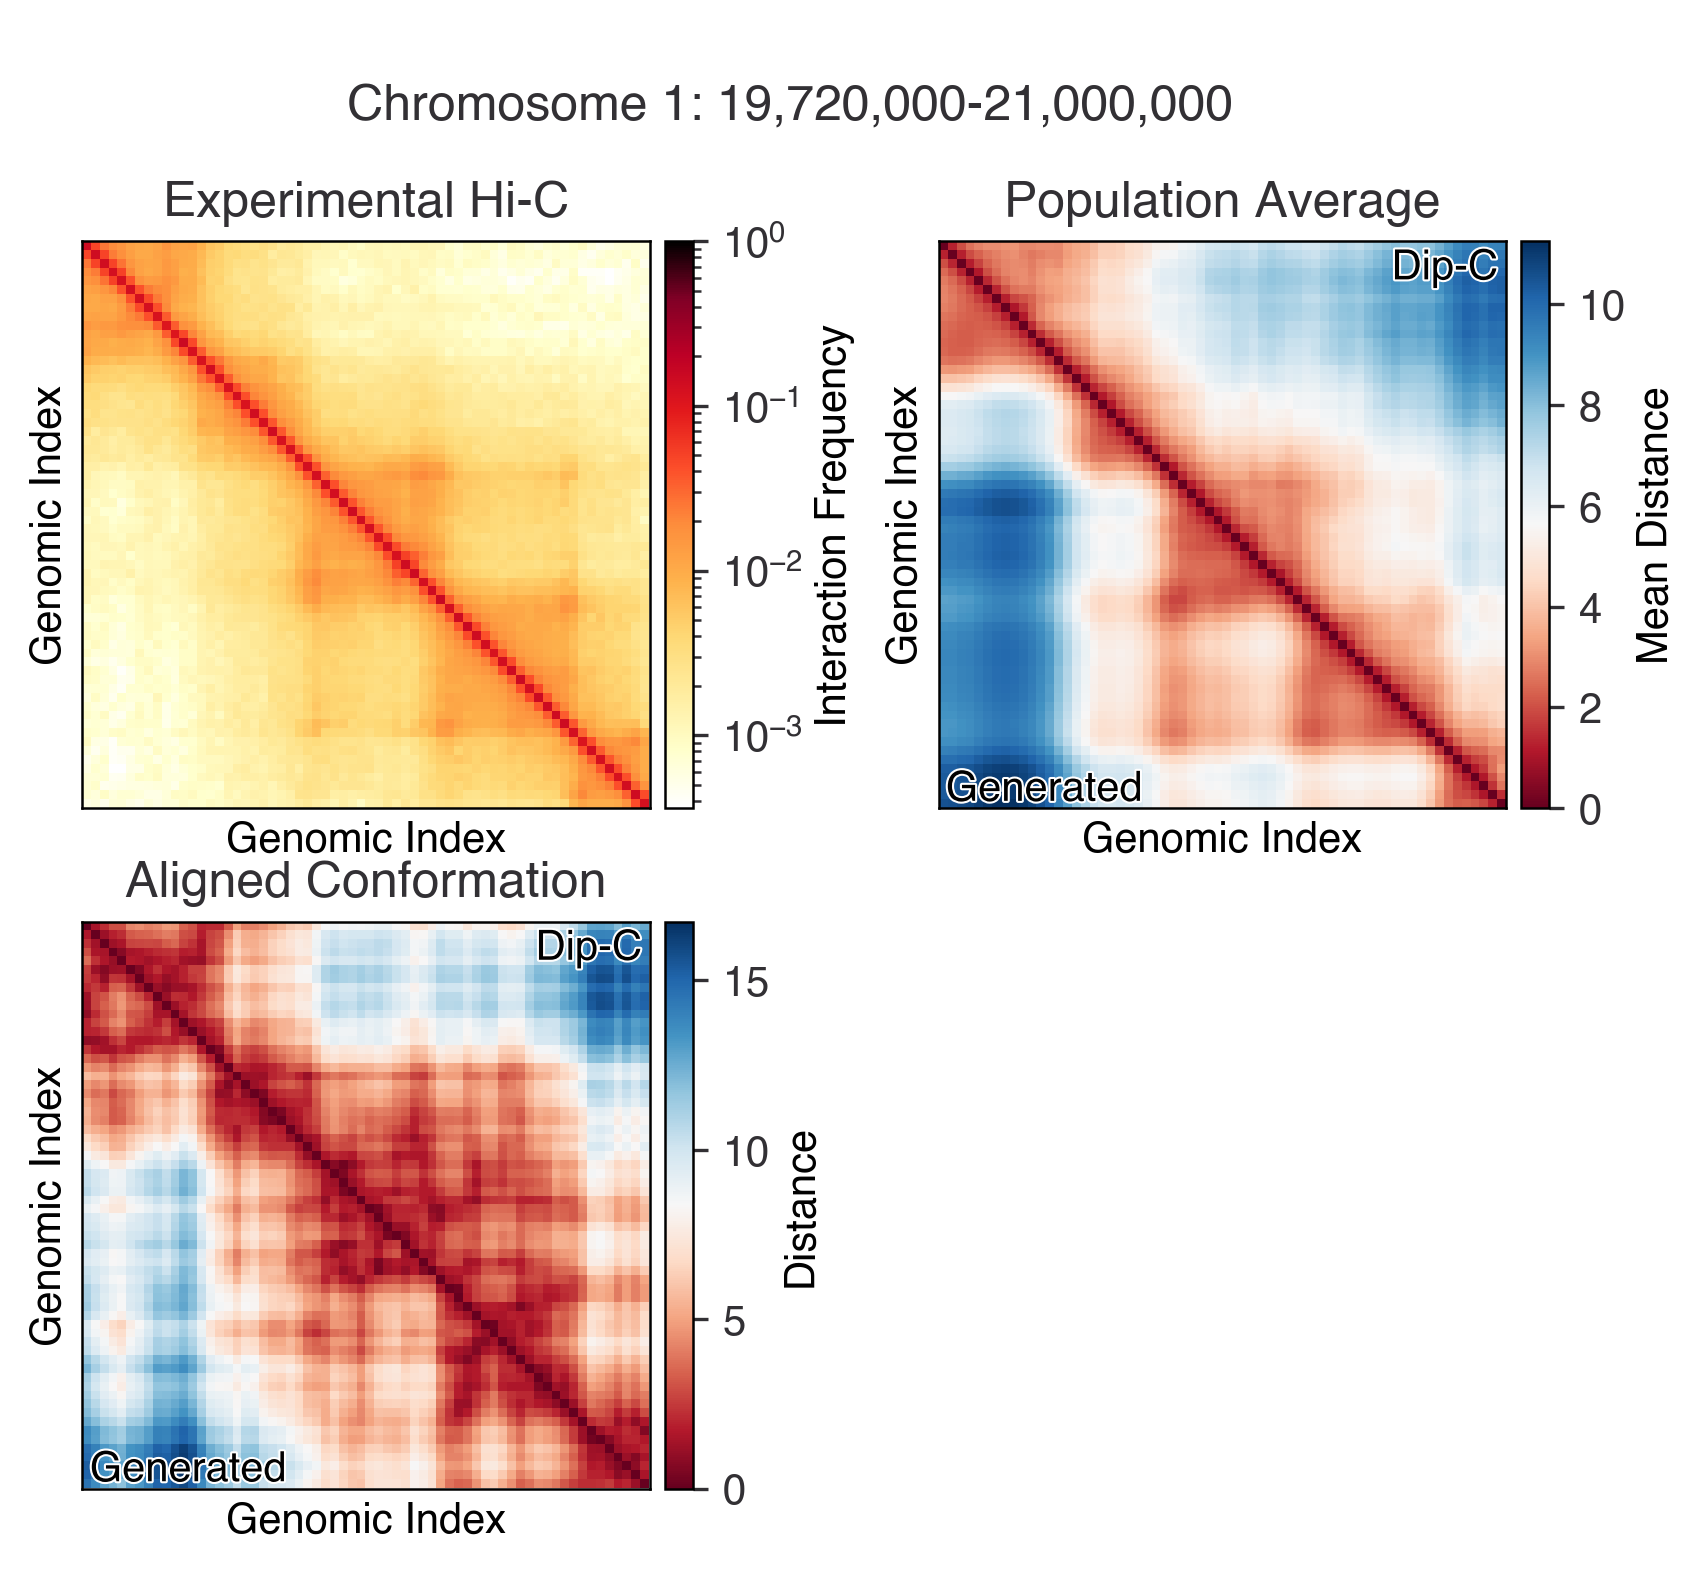

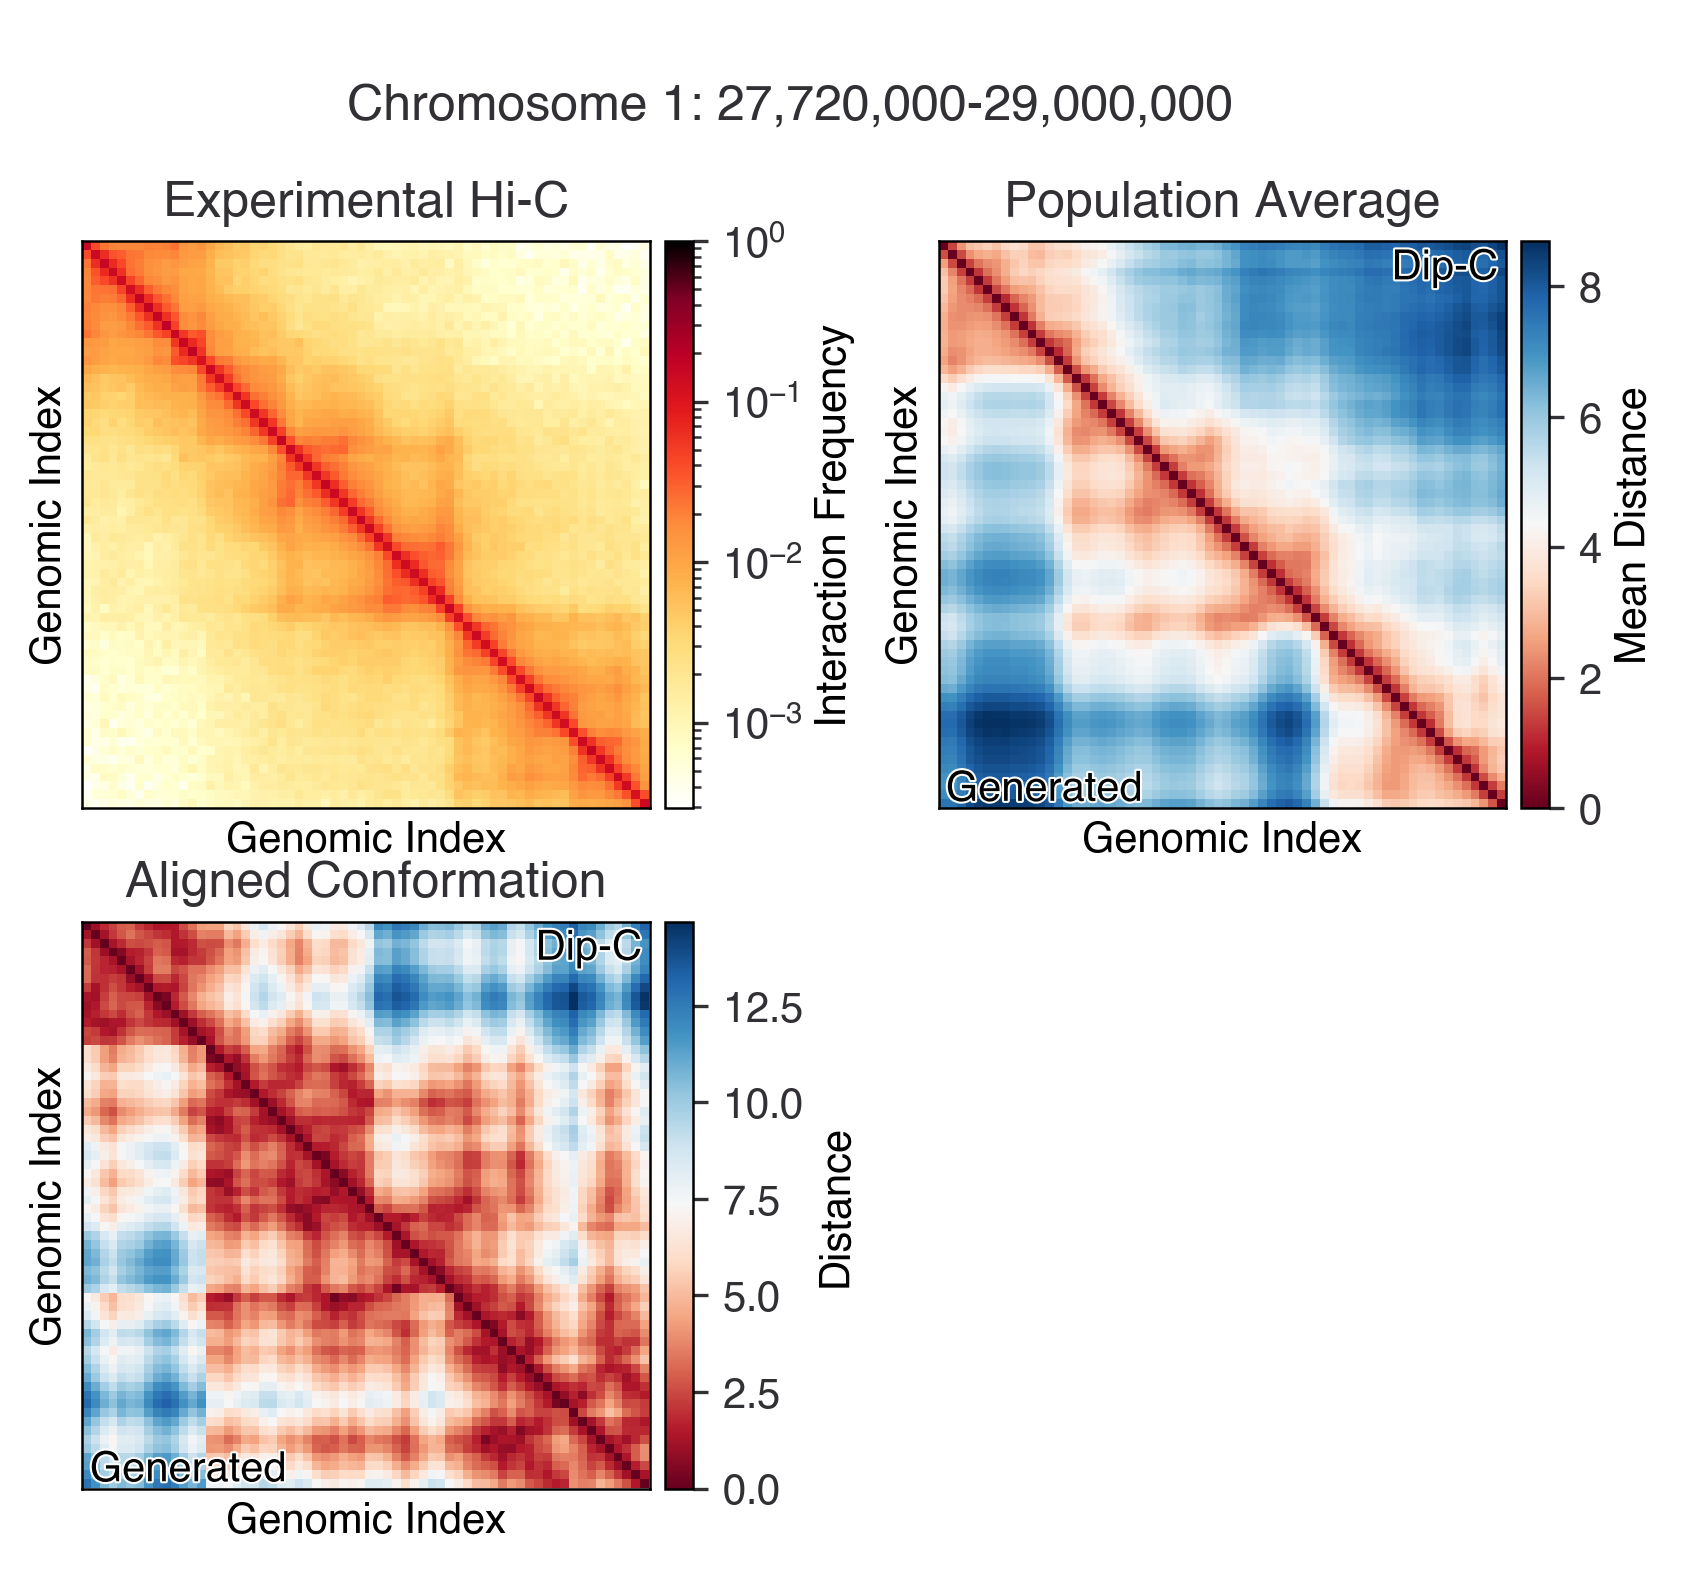

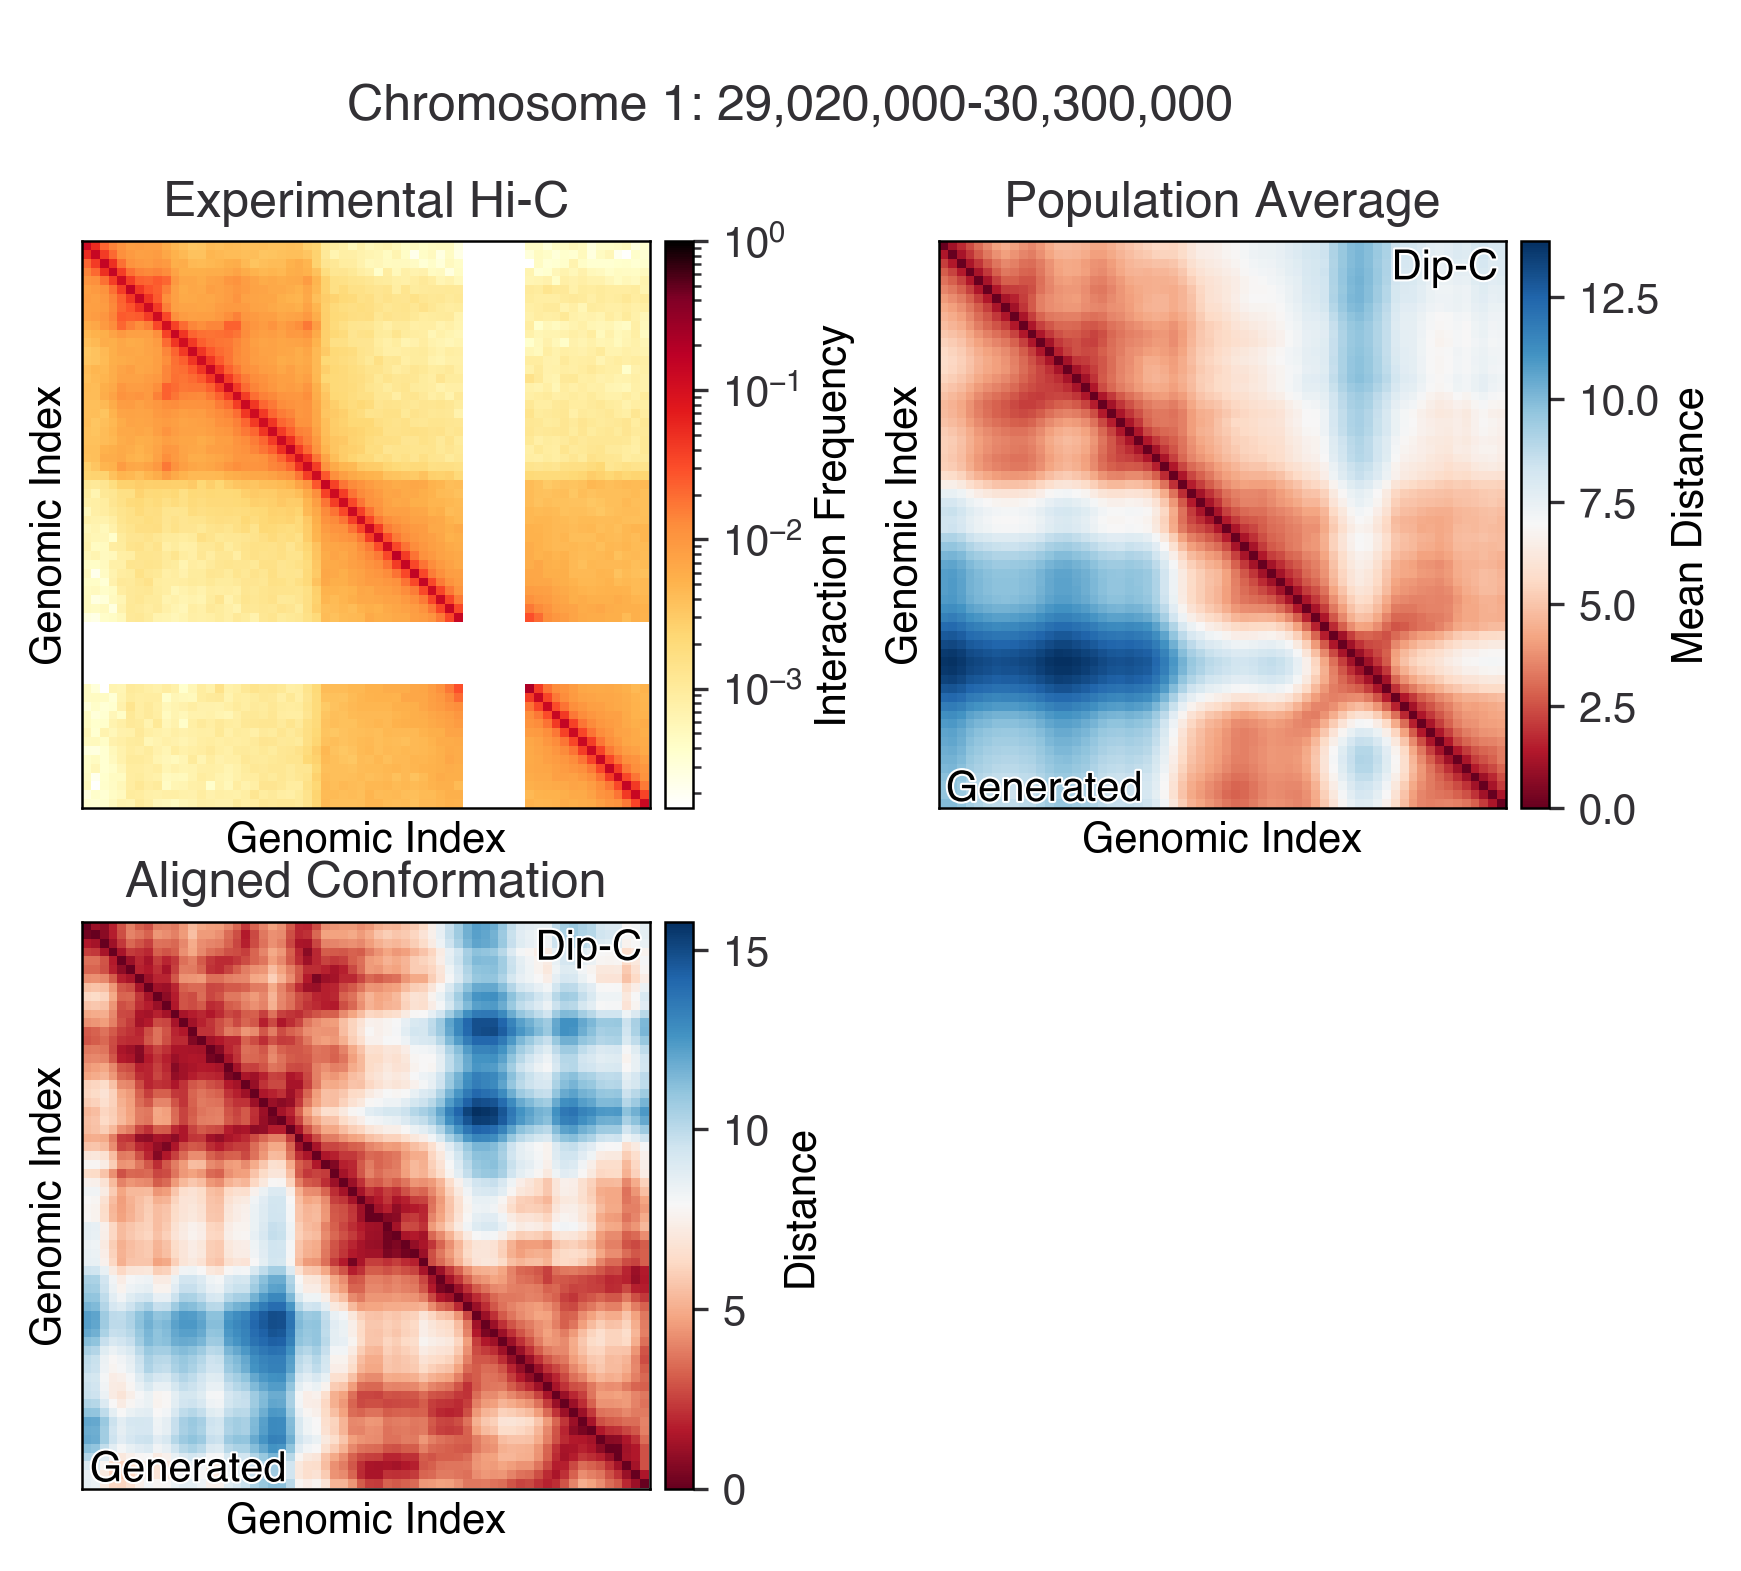

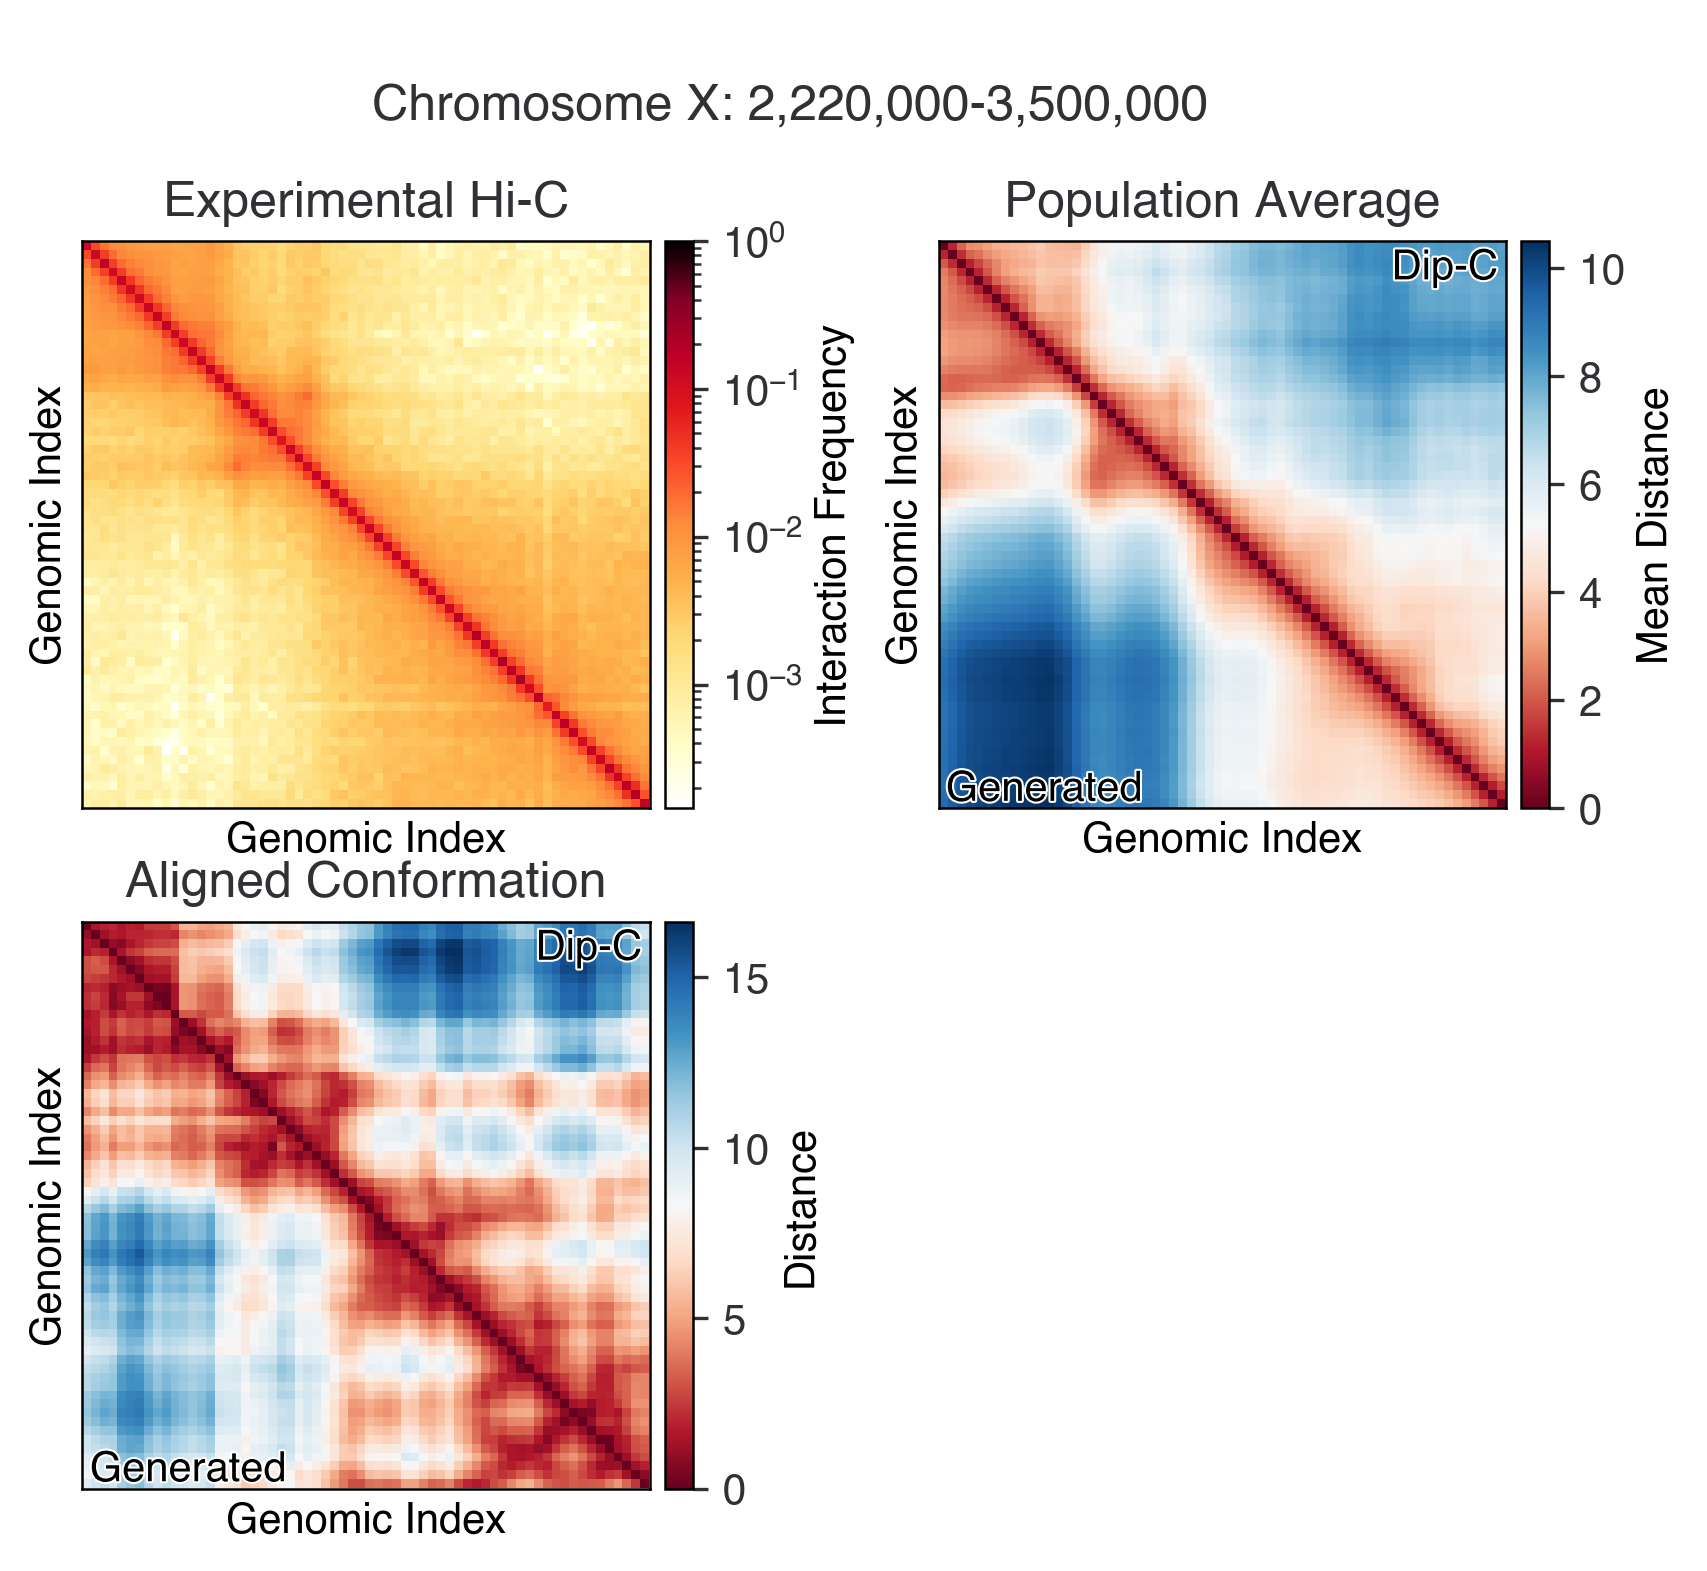

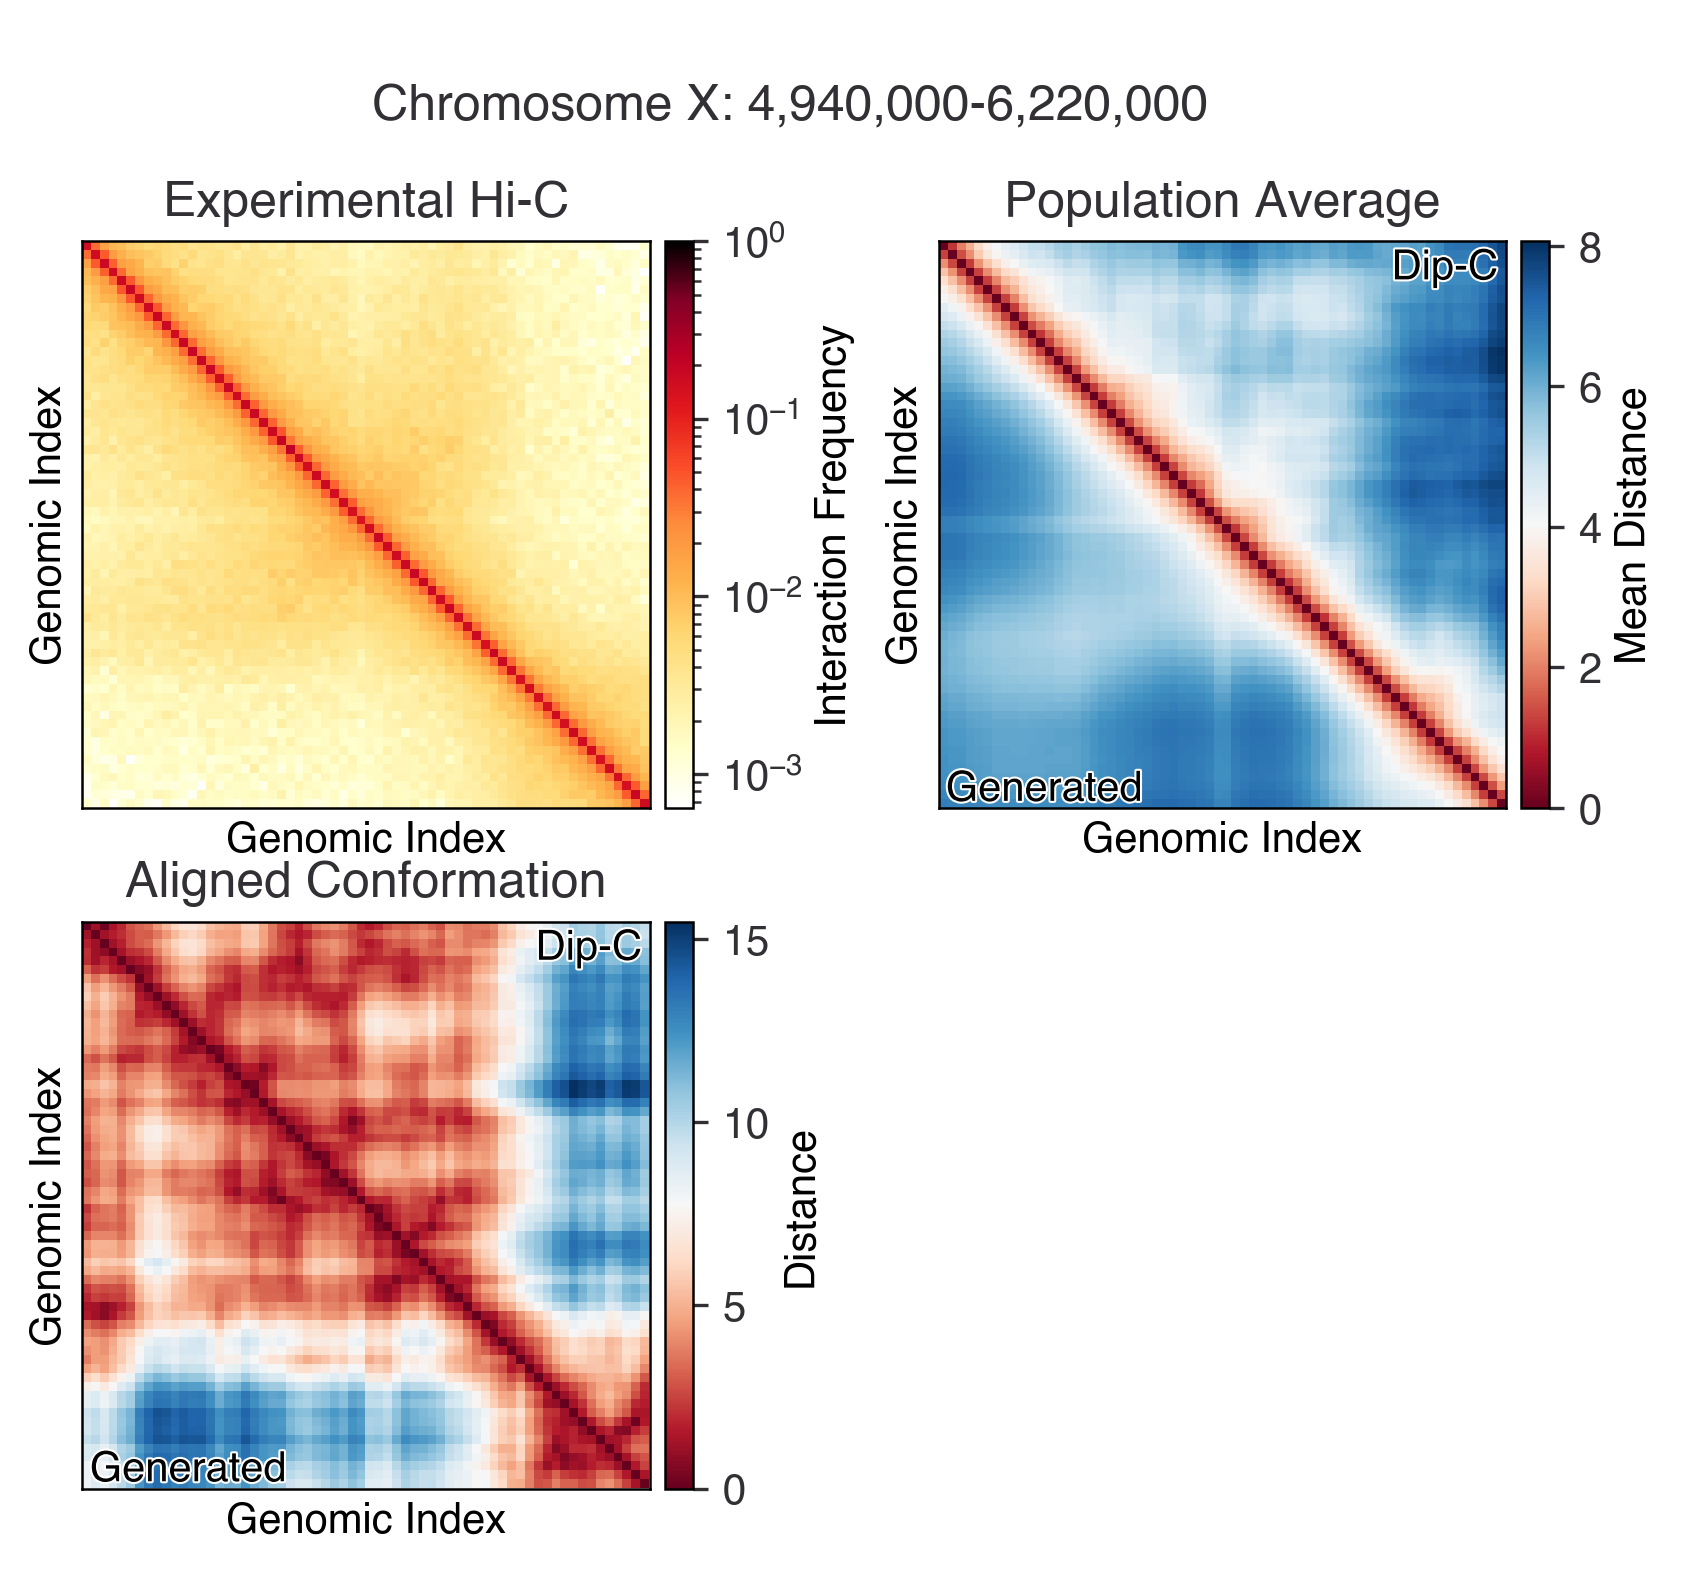

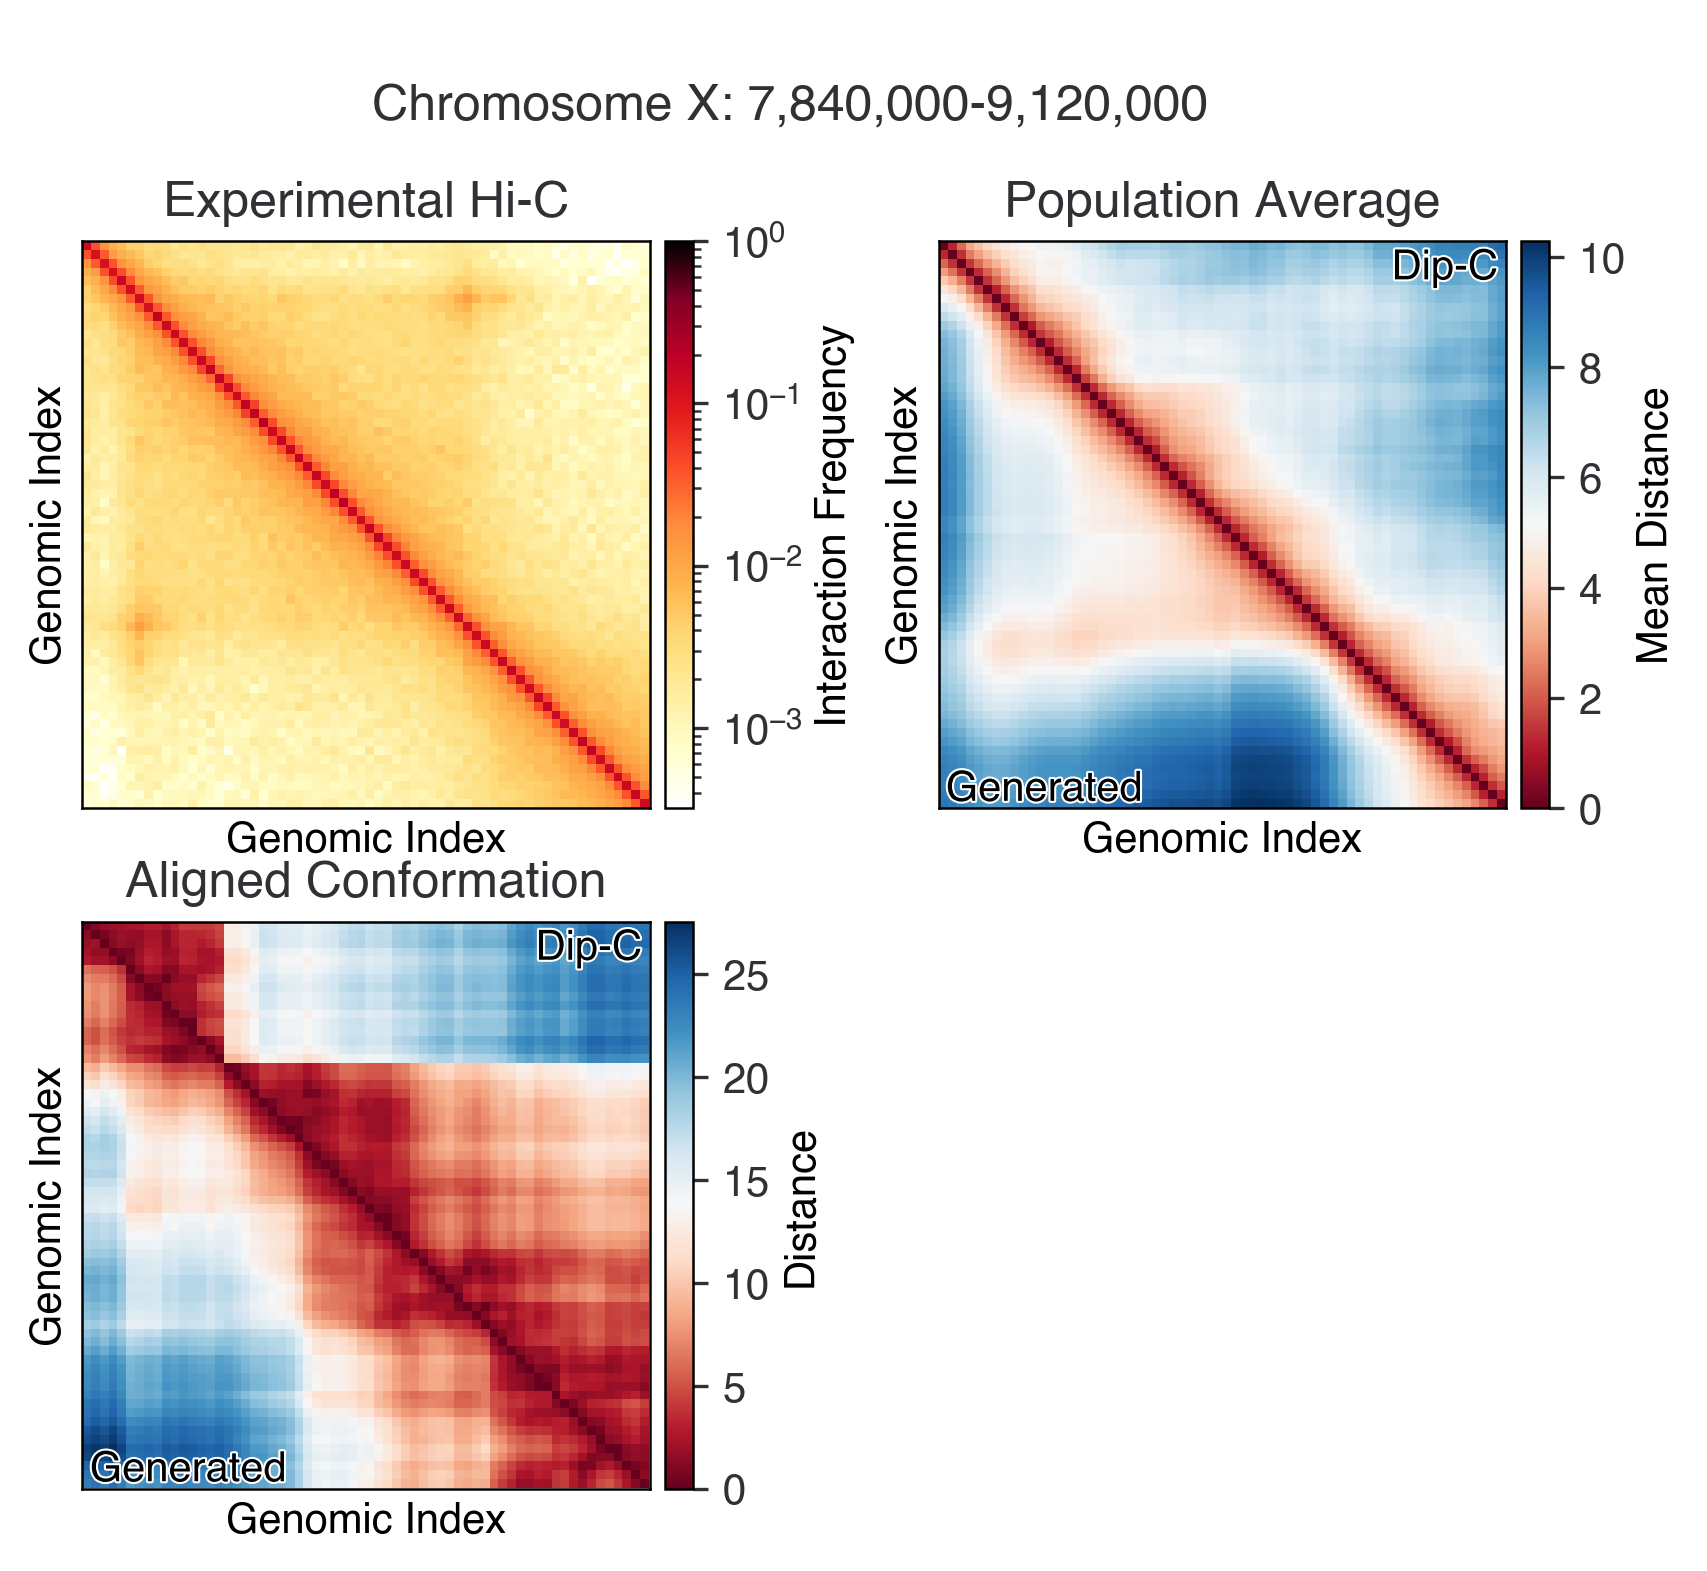

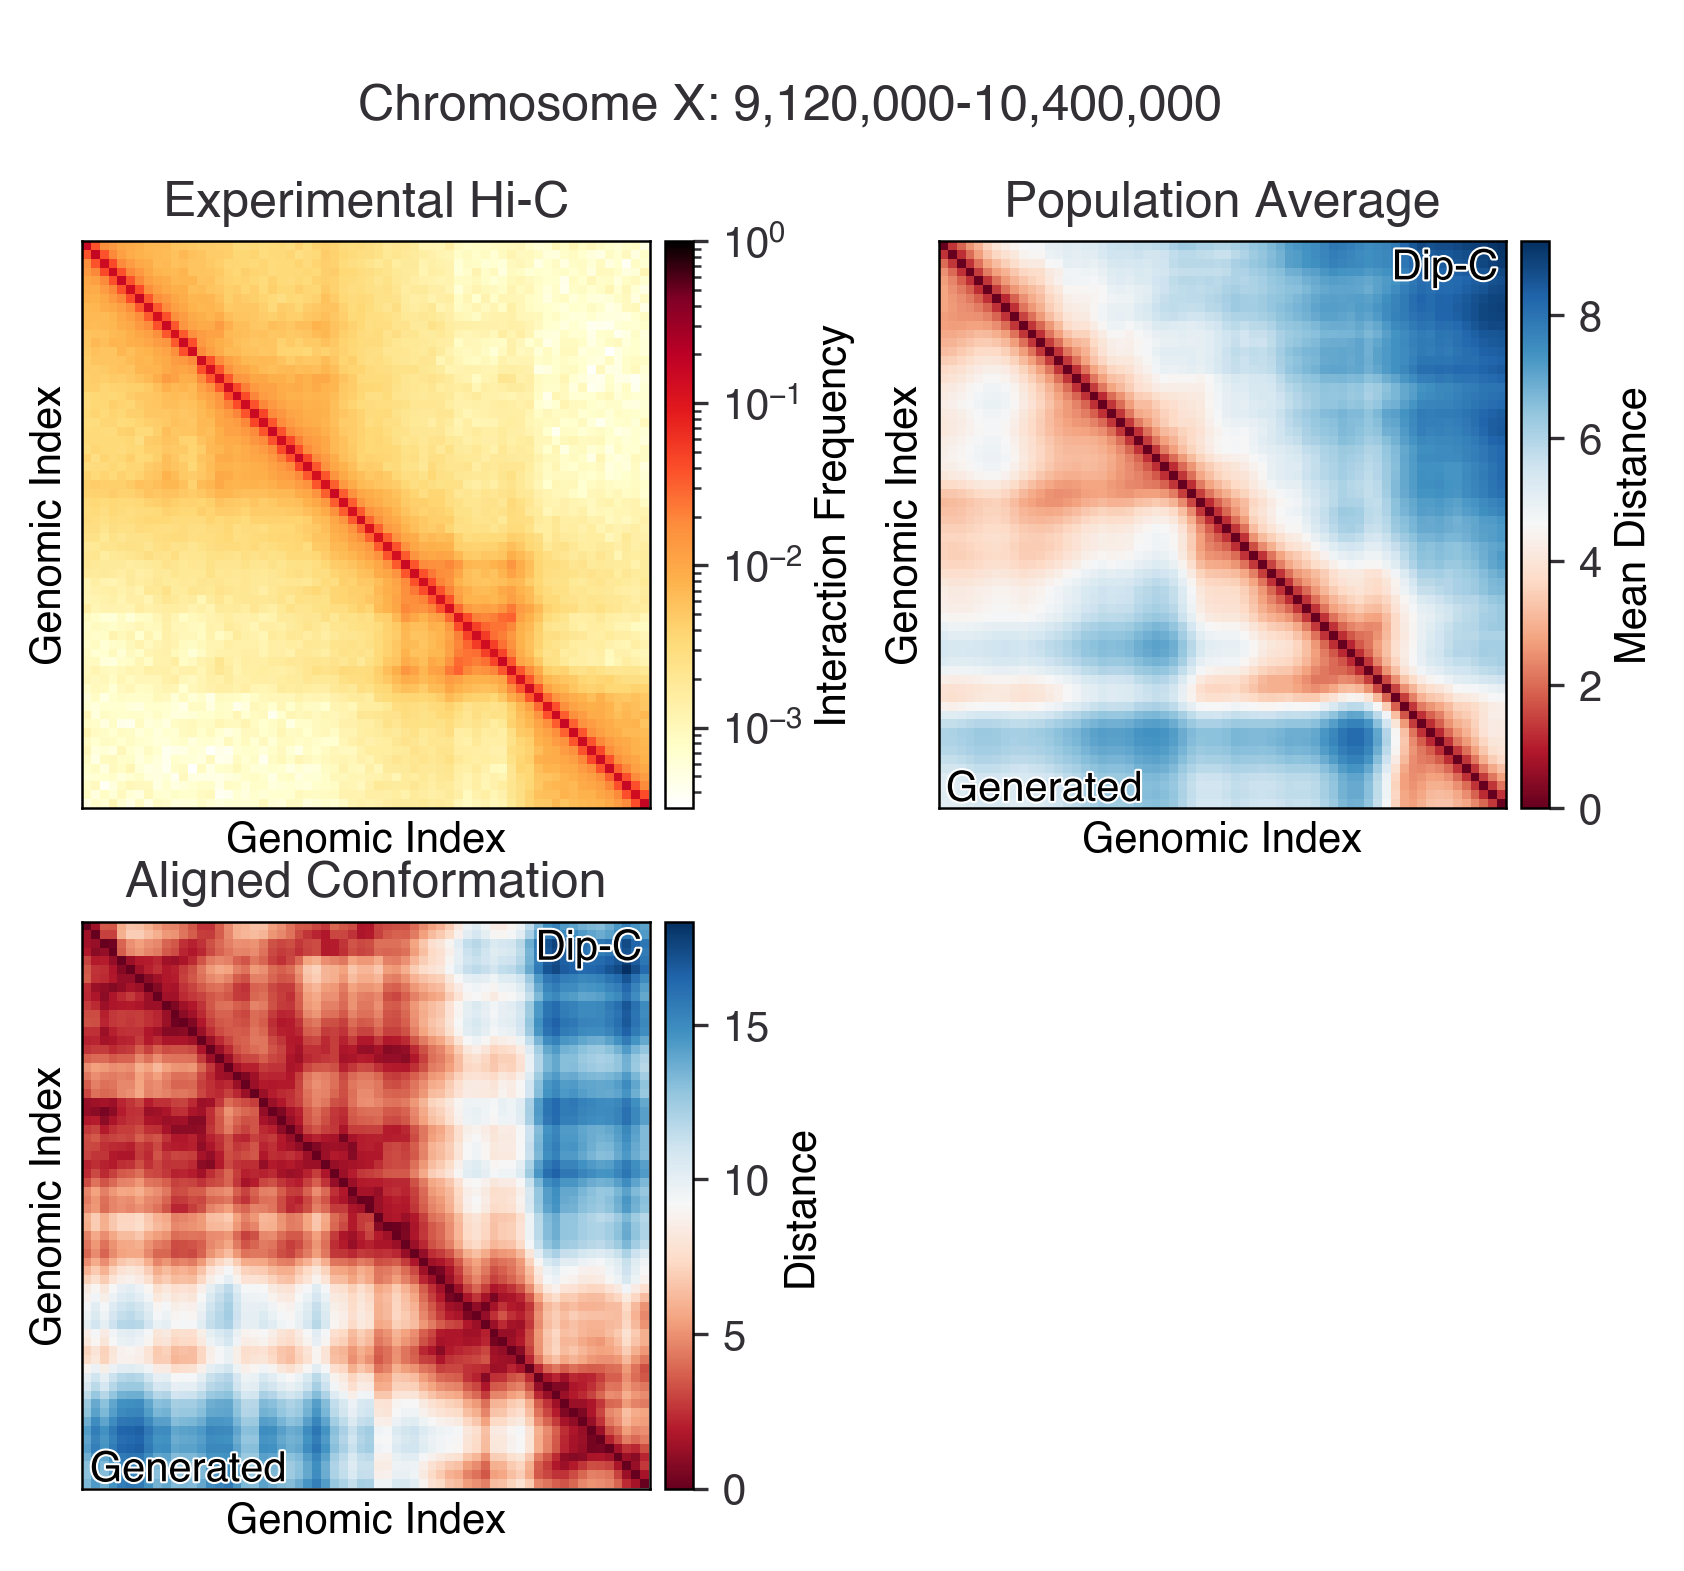

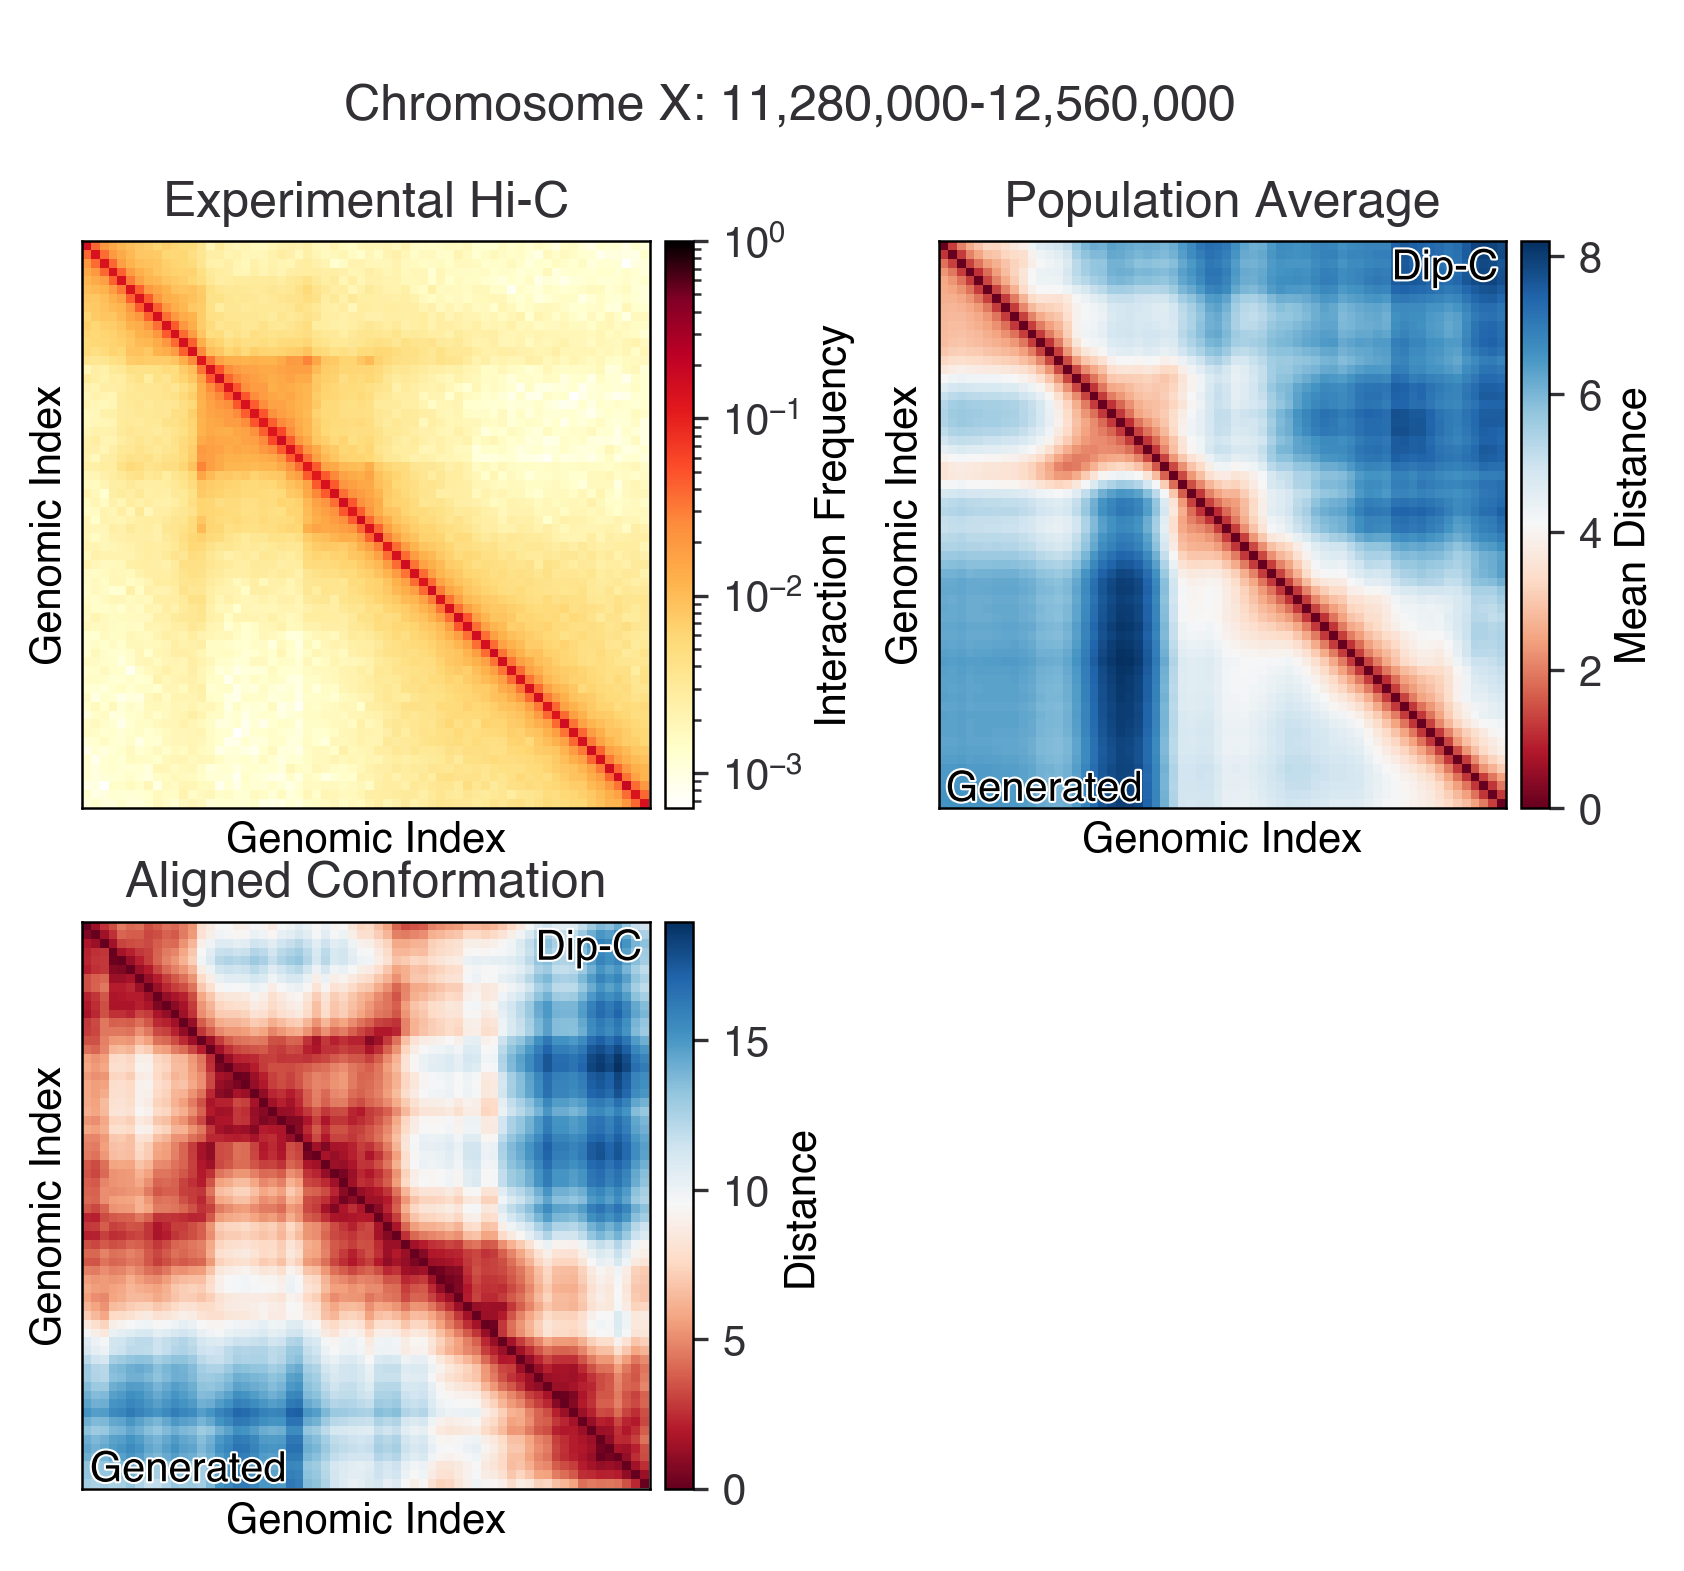

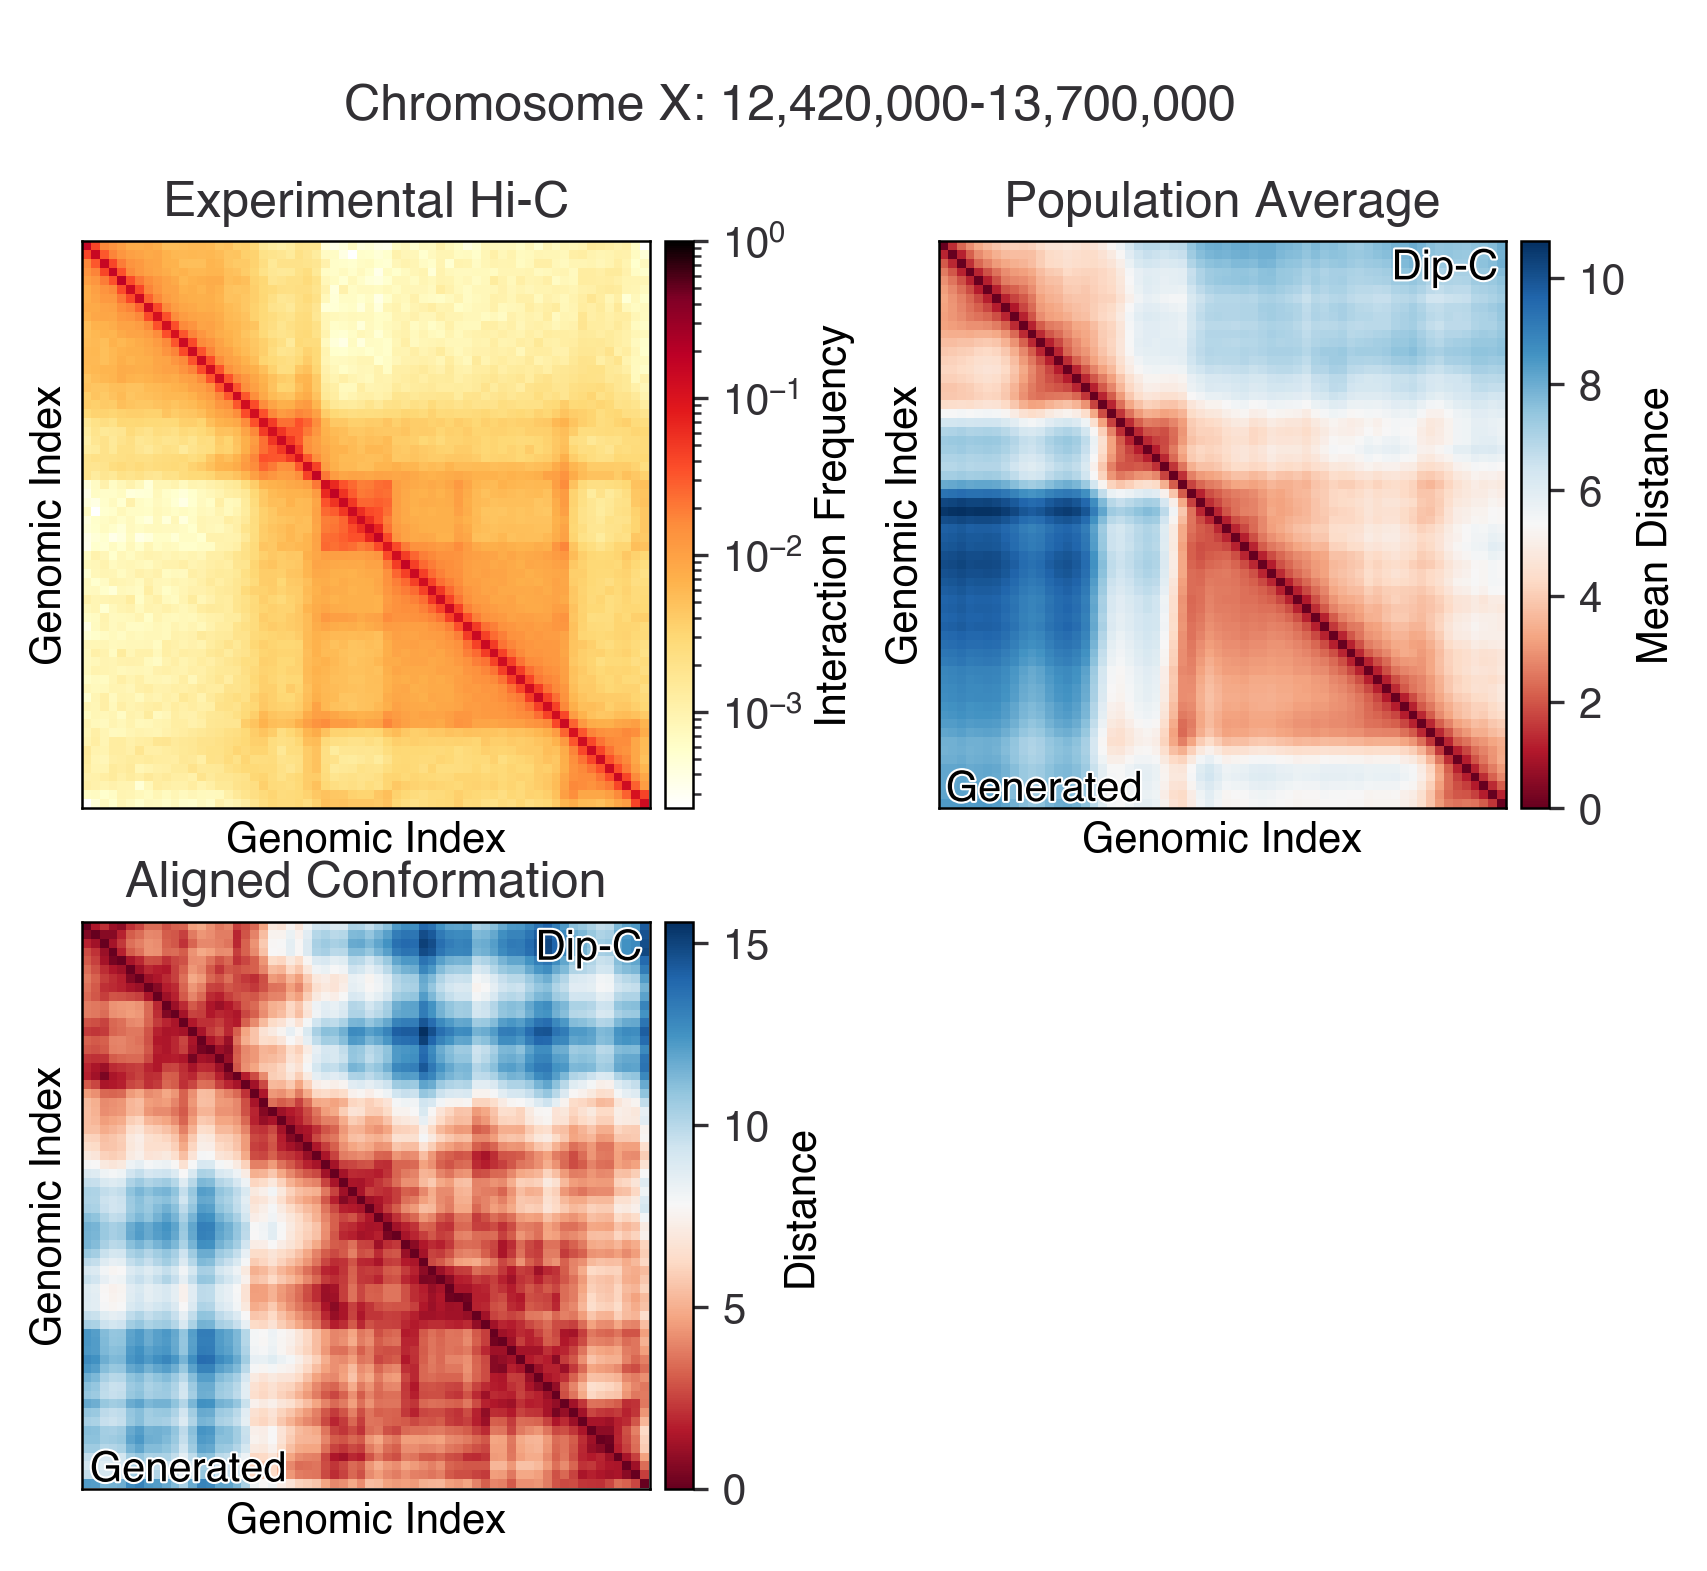

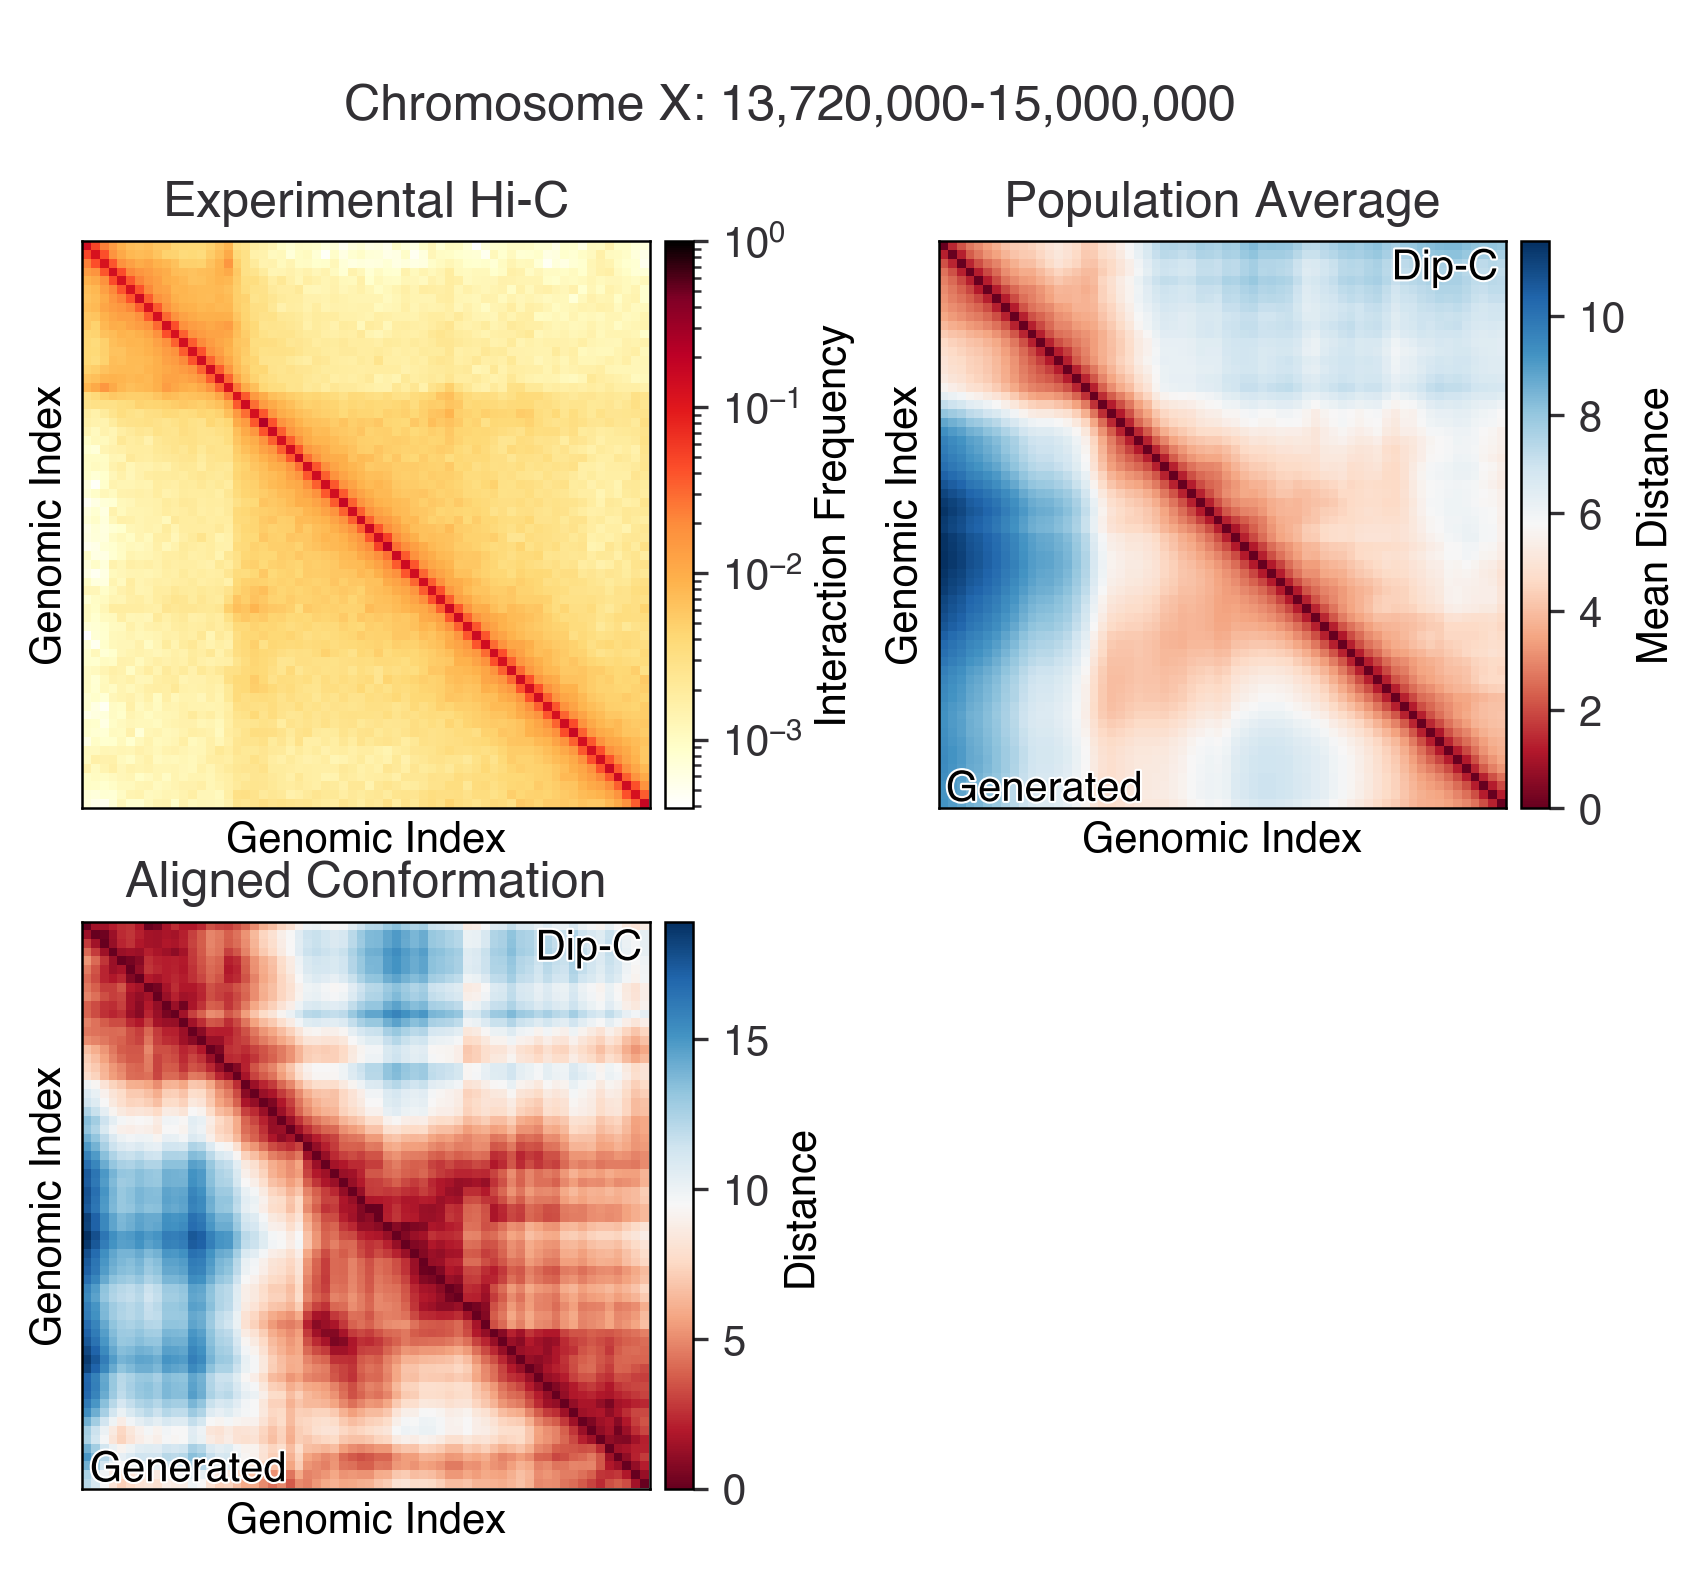

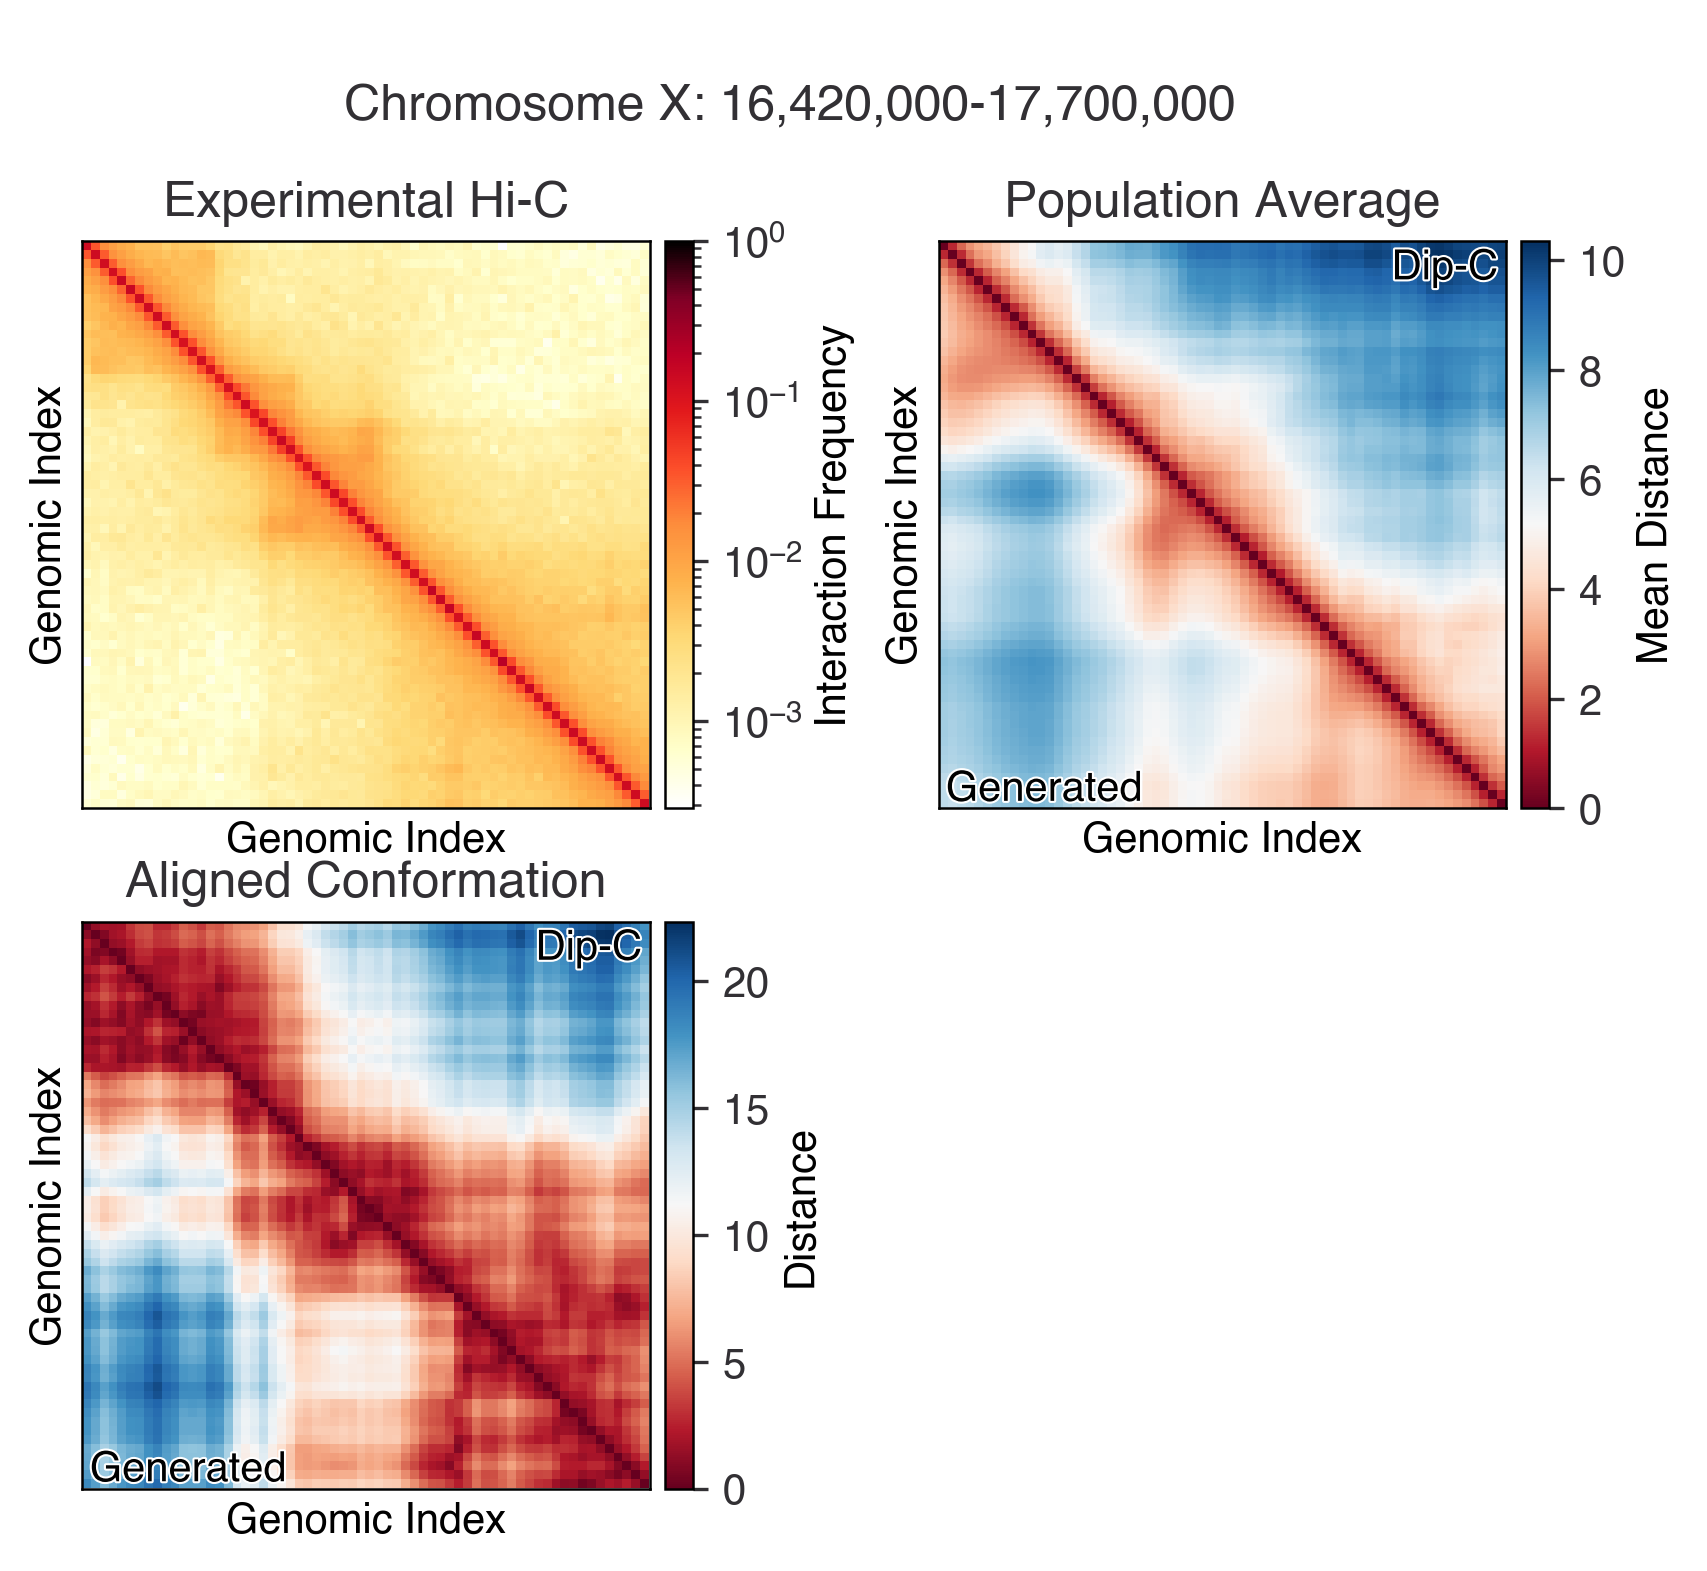

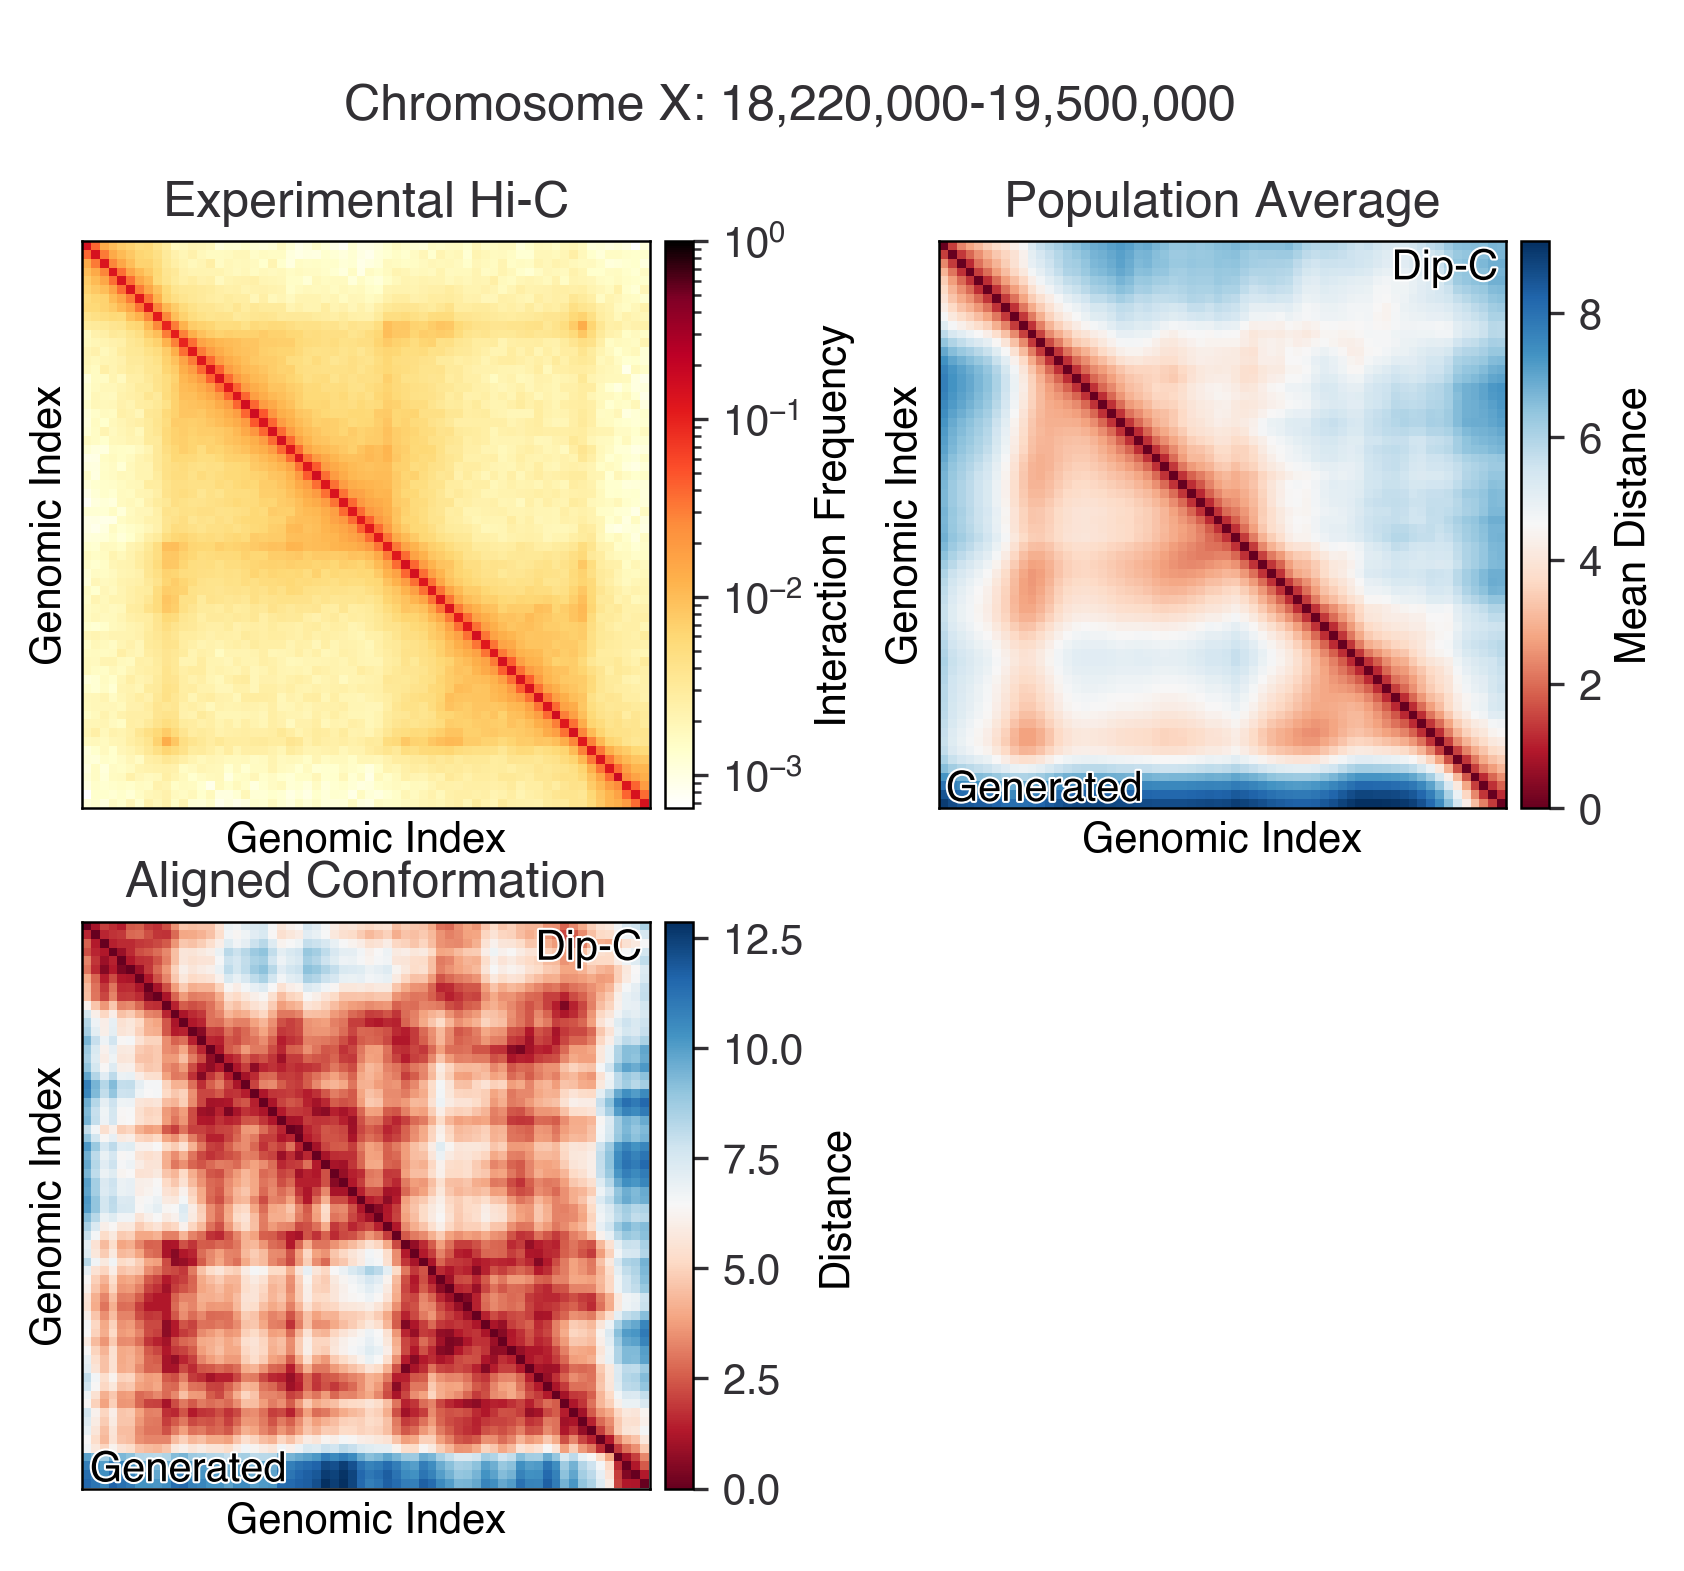

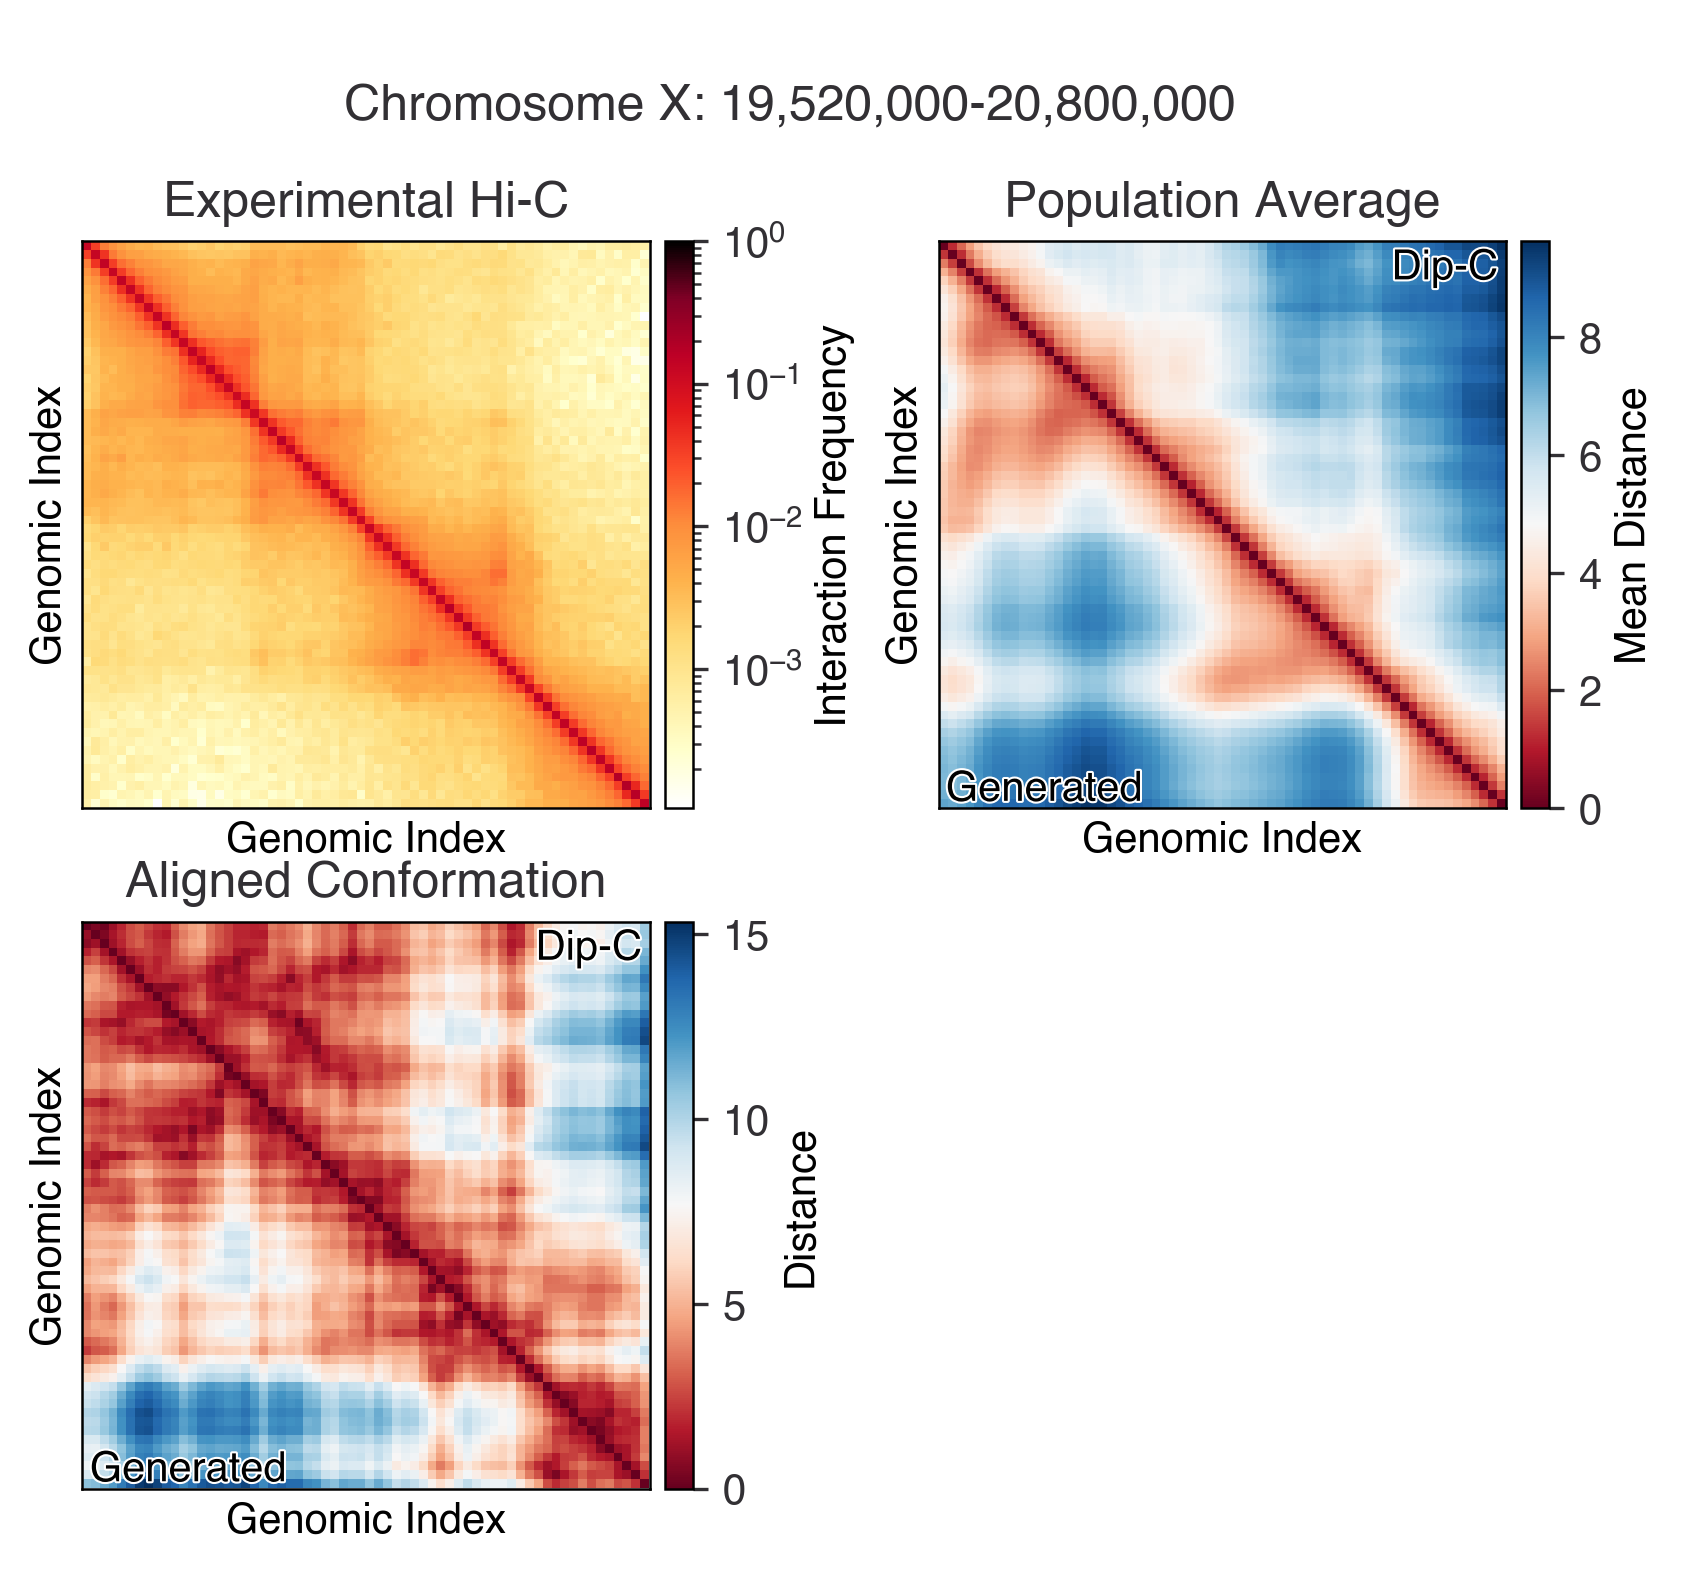

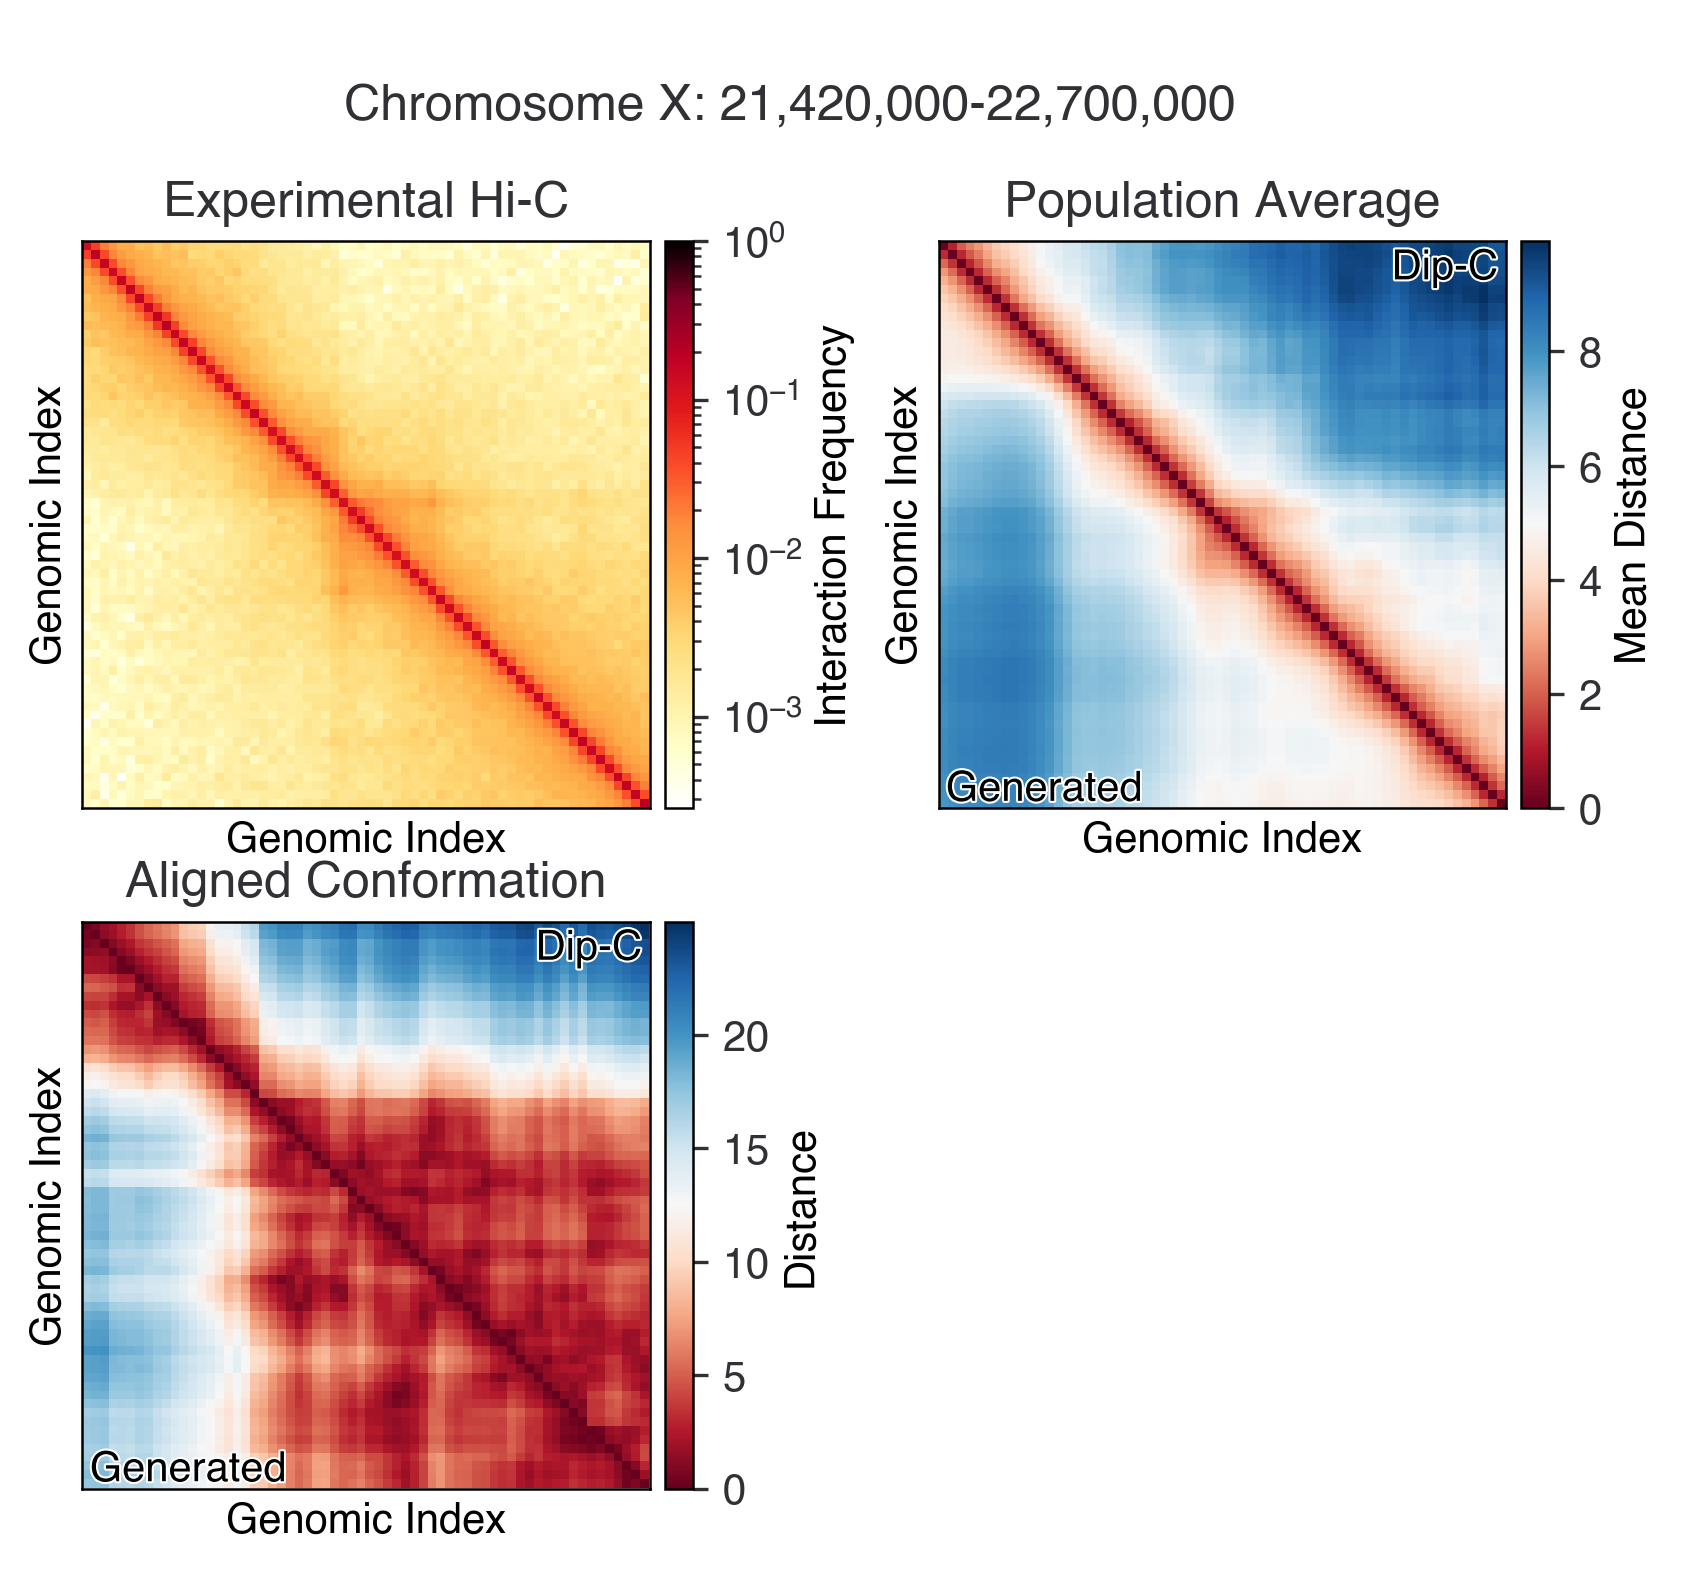

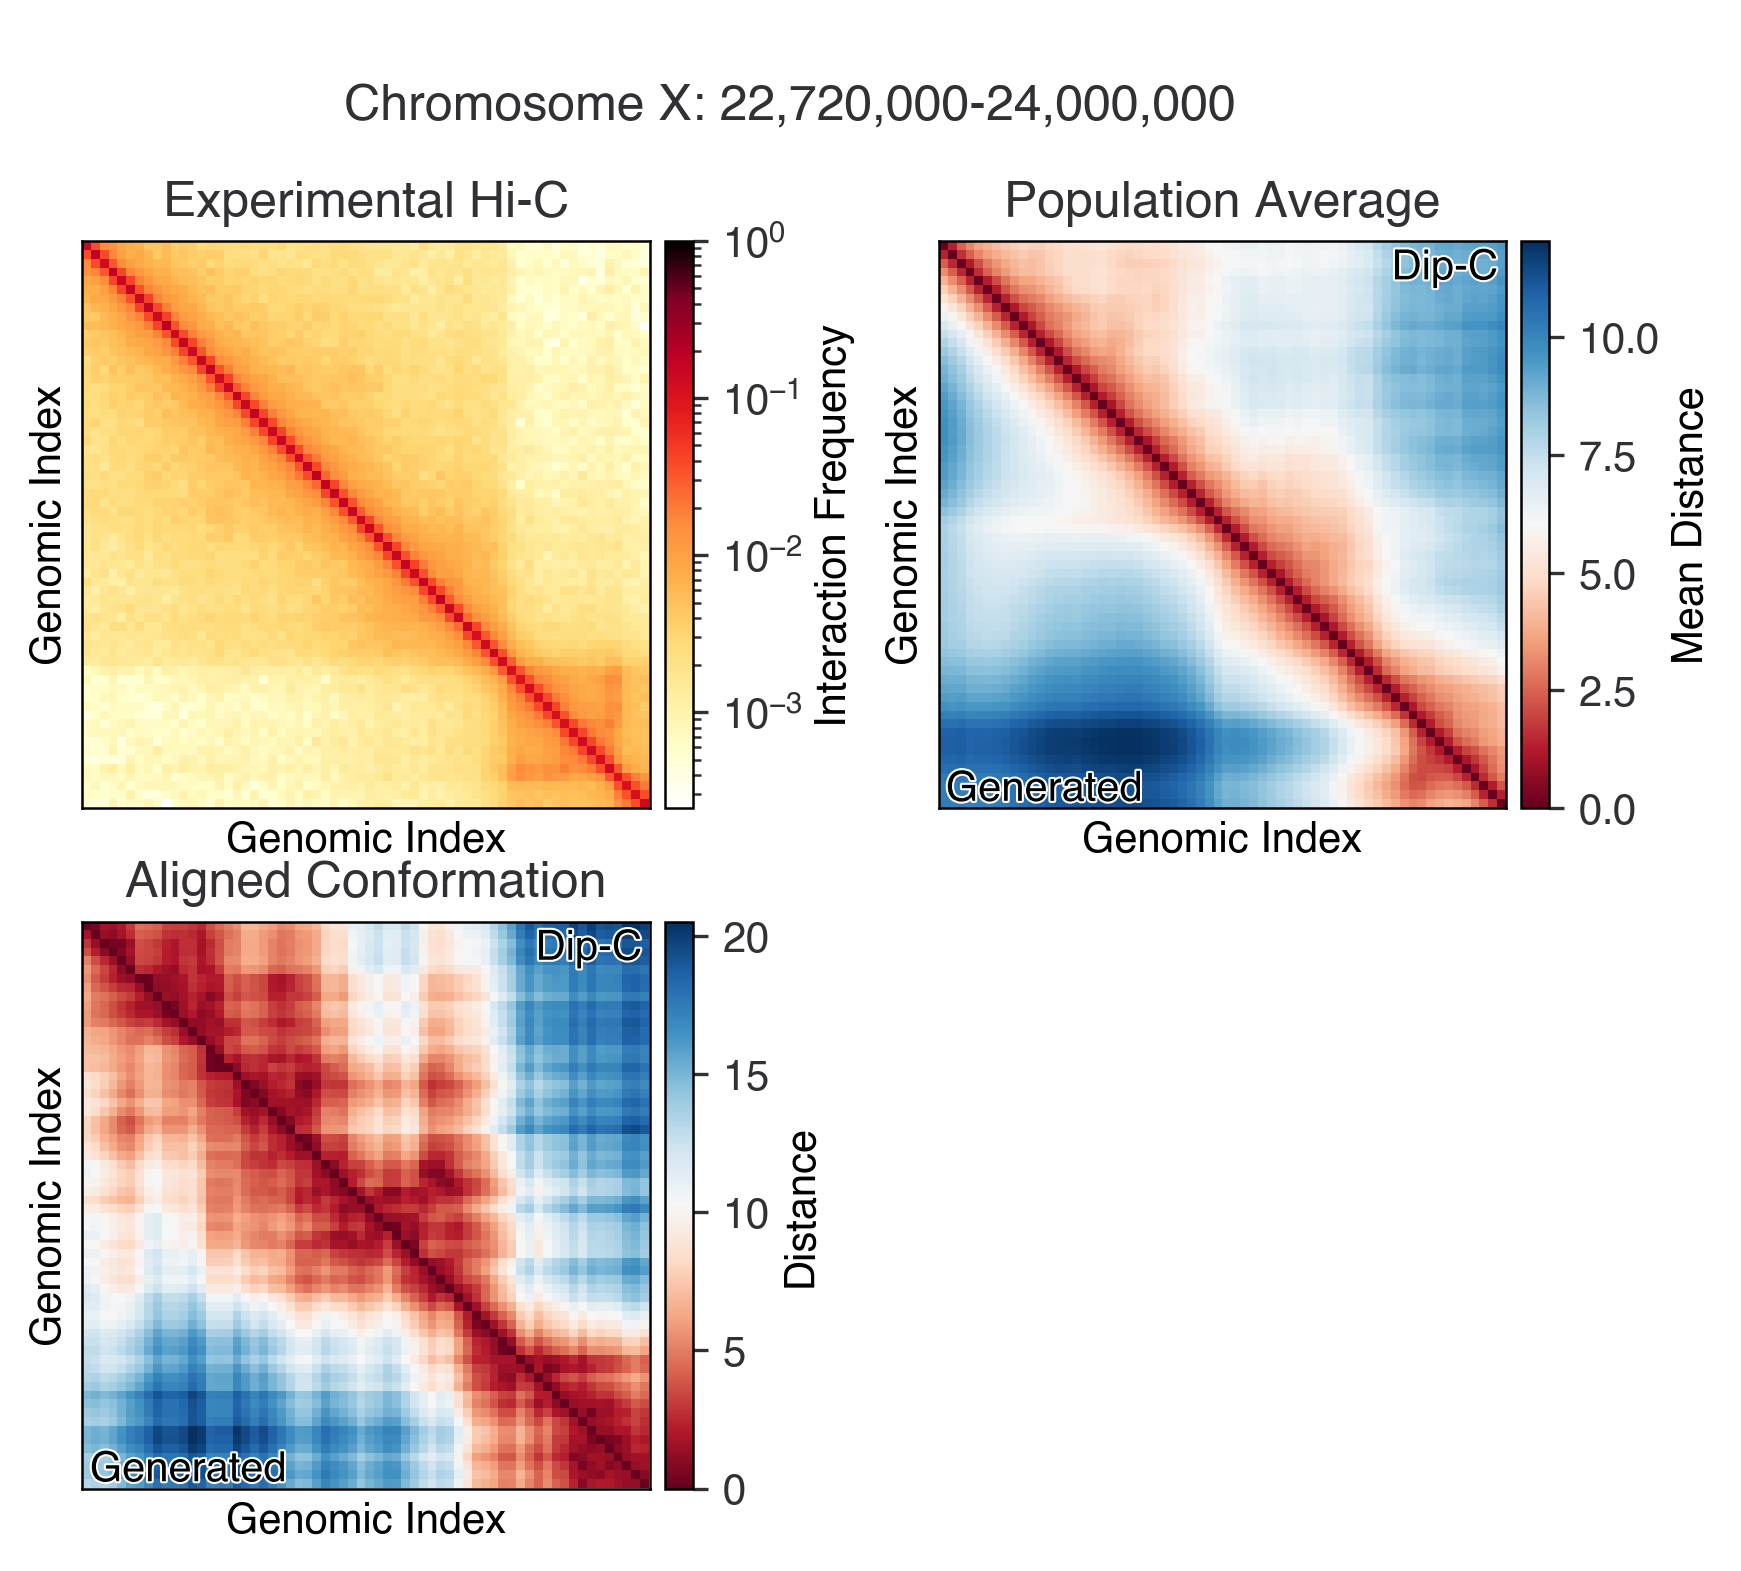

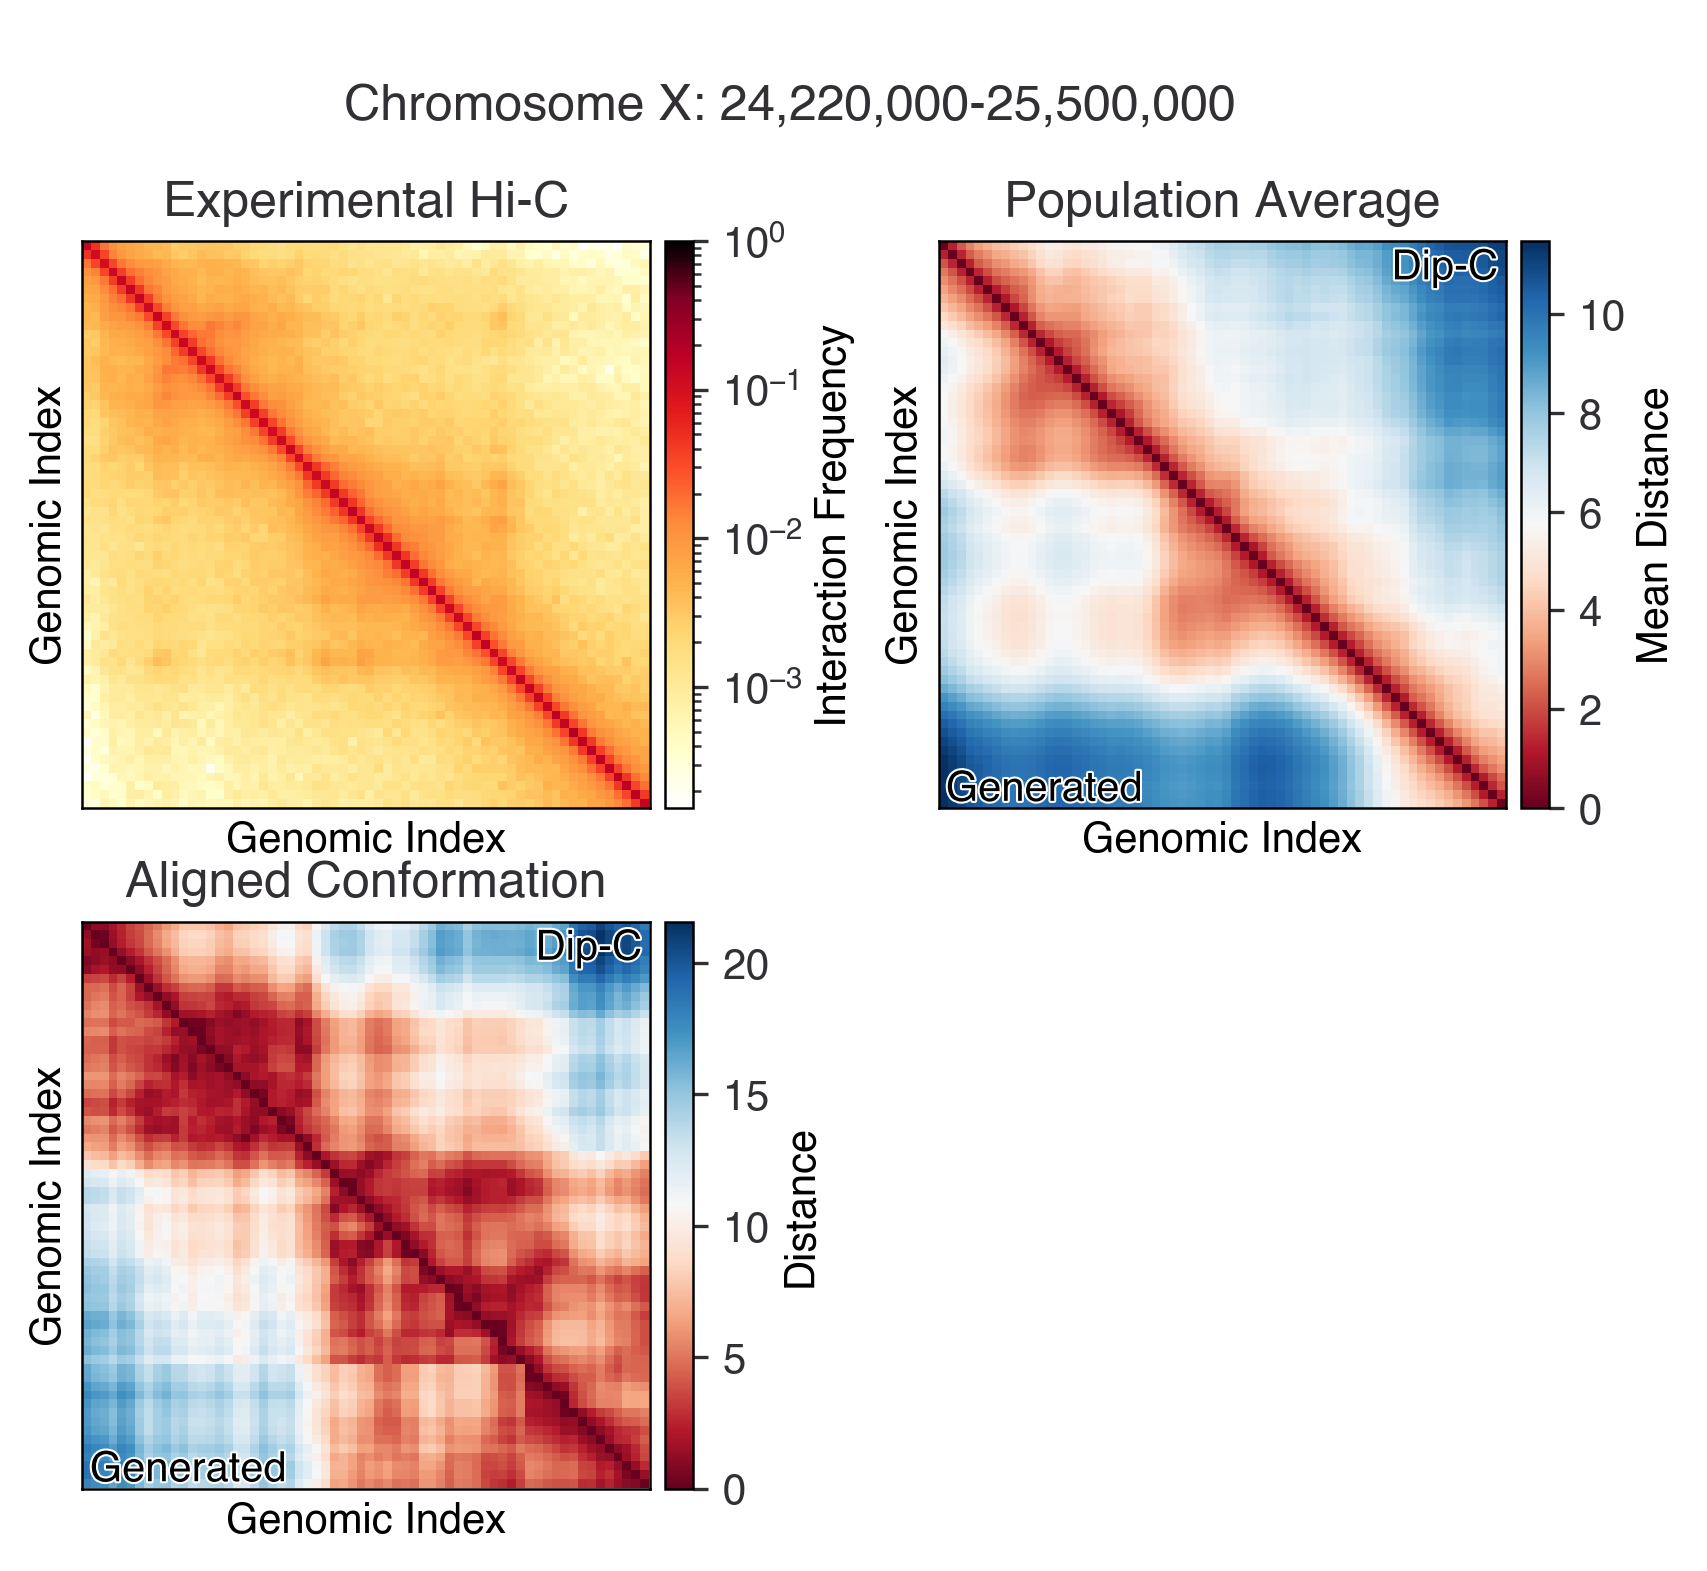

In [18]:
for chrom in regions:
    for region_idx in regions[chrom]:
        fig,*_ = gen_vs_tan_2(
                chrom,
                region_idx,
                cond_scale=cond_scale,
                rescaled_phi=rescaled_phi
            )
        fig.savefig(save_dir + f'chrom_{chrom}_region_{region_idx}_nbins_{num_bins}_scale_{cond_scale}_phi_{rescaled_phi}.pdf',bbox_inches='tight');
        

In [19]:
asfd

NameError: name 'asfd' is not defined

In [ ]:
rosetta['1'][395]

In [ ]:
regions['1'][4]

In [ ]:
regions

In [ ]:
chrom = '1'
region_idx = 144
tan = get_tan_coords(chrom,region_idx)[0].trajectory
gen = get_gen_coords(chrom,region_idx).trajectory

In [ ]:
tan1,gen1 = score_match(tan,gen)

In [ ]:
tan1.distances.plot_with(gen1.distances)

In [21]:
for i in regions['X']:
    if rosetta['X'][i][-1] == 19_520_000:
        print(i)

965


In [ ]:
scores